In [21]:
import jax.numpy as jnp
import numpy as np
from jax import grad, jit, vmap
from jax import random
from functools import partial

from numba import vectorize, float64, guvectorize, njit

import time
import math
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from jax.scipy.stats import multivariate_normal
import scipy
from scipy import stats

In [2]:
key = random.PRNGKey(68981998)
key1 = random.PRNGKey(69988)
key2 = random.PRNGKey(6199998)
subkeys = random.split(key, 5000)

In [3]:
import jax
jax.devices()

[CpuDevice(id=0)]

In [4]:
# Generate data from stable distribution
@partial(jit, static_argnames=['dataset_size', 'num_datasets'])
def simulate_gandk(theta, dataset_size, num_datasets, c = 0.8):
    zu = random.normal(key, shape = (num_datasets, dataset_size))
    f = (theta[0] + theta[1] * (1 + c * (1 - jnp.exp(-theta[2] * zu)) / (1 + jnp.exp(-theta[2] * zu))) * (1 + zu**2)**theta[3] * zu)
    return f

In [5]:
true_theta = jnp.array([3, 1, 2, 0.5])
num_coeffs = 4
num_latent = 4
num_samples = 100
num_datasets = 100
lambda_dim = num_coeffs + int((num_coeffs * (num_coeffs + 1)) / 2)

sigma_theta = 4

In [6]:
actual_data = simulate_gandk(true_theta, num_samples, 1)
actual_data

Array([[ 2.482515 ,  1.3518647,  2.8636947,  2.1269476,  2.4856527,
         4.8631005,  3.8174963,  3.013932 ,  5.740586 ,  2.3473065,
         3.529538 ,  2.277744 ,  2.689123 ,  3.199136 ,  2.5330603,
         4.1642914,  9.189451 ,  6.285255 ,  4.1081357,  6.5867105,
         2.6491334,  2.238831 ,  2.2460268,  5.546506 ,  2.3508346,
         2.611294 ,  3.9697745,  2.765585 , 10.173696 ,  2.6437466,
         3.5968933,  2.3589137,  2.4244227,  2.5102649,  3.1303935,
         2.554019 ,  2.3065908,  2.7600698,  4.2099886,  8.212257 ,
         2.562762 ,  2.4751391,  2.7670803,  2.3467064,  4.981174 ,
         4.629375 ,  3.1290188,  2.6975565,  2.1363802,  3.9612474,
         2.3996768,  3.382027 ,  9.079671 ,  6.6432257,  6.440662 ,
         6.7752633,  3.0427144,  3.9464335,  3.1612146,  4.7513175,
         2.6353414,  2.4426286,  2.6980019,  3.0774739,  5.498164 ,
         1.8374782,  2.4608872,  8.161454 ,  2.5142748,  3.8703685,
         2.0090973,  2.5975134,  2.674843 ,  3.5

In [7]:
# CALCULATE SUMMARY STATS
@jit
def compute_summary_statistics(y):
    quant_y = []
    for i in jnp.arange(0.125, 1, 0.125):
        quant_y.append(jnp.quantile(y, i))
    Sa = quant_y[3]
    Sb = quant_y[5] - quant_y[1]
    Sc = (quant_y[6] - quant_y[4] + quant_y[2] - quant_y[0]) / Sb
    Sd = (quant_y[5] + quant_y[1] - 2 * quant_y[3]) / Sb
    return jnp.array([Sa, Sb, Sc, Sd])

In [11]:
actual_summary_statistics = compute_summary_statistics(actual_data)
actual_summary_statistics

Array([2.7815332 , 1.6291151 , 1.639214  , 0.63064325], dtype=float32)

In [9]:
def summary_statistics(theta, n_samples, n_datasets):
    datasets = simulate_gandk(true_theta, n_samples, n_datasets)
    n_summary_statistics = jnp.array([compute_summary_statistics(datasets[i,:]) for i in range(n_datasets)])

    sample_mean = jnp.mean(n_summary_statistics, axis = 0)
    sample_variance = jnp.cov(n_summary_statistics.T)
    return sample_mean, sample_variance

In [10]:
def my_inv(x):
    return jnp.linalg.inv(x + (jnp.eye(x.shape[0]) * 1e-7))

In [12]:
@jit
def prior(theta):
    log_prior = multivariate_normal.logpdf(theta, mean = jnp.array([0] * num_coeffs), cov= 10 * jnp.identity(num_coeffs))
    return log_prior

In [13]:
def unbiased_log_likelihood(theta, n_samples, num_datasets):
    ss = summary_statistics(theta, n_samples, num_datasets)
    sample_mean = ss[0]
    sample_variance = ss[1]
    u_est_log_likelihood = multivariate_normal.logpdf(actual_summary_statistics, mean = sample_mean, cov= sample_variance)
    return u_est_log_likelihood

In [14]:
@jit
def fun_log_q(theta, mu, l):
    log_q = multivariate_normal.logpdf(theta, mean = mu, cov= my_inv(l @ l.T))
    return log_q

In [15]:
@partial(jit, static_argnames=['num_coeffs'])
def gradient_log_q(theta, mu, l, num_coeffs): #indep theta
    gradient_log_q_mu = l @ l.T @ (theta - mu)
    # gradient_log_q_l = (np.diag(np.linalg.inv(l)) - np.matmul(((np.reshape(theta - mu, (num_coeffs,1))) * theta - mu), l)).T[np.triu_indices(num_coeffs)] #use * because matmul gives scalar
    diag_inv_l = jnp.zeros_like(l, shape=(num_coeffs,num_coeffs)).at[jnp.diag_indices_from(l)].set(jnp.diag(l))
    gradient_log_q_l = (diag_inv_l - jnp.reshape(theta - mu, (num_coeffs,1)) @ jnp.reshape(theta - mu, (1,num_coeffs)) @ l).T[jnp.triu_indices(num_coeffs)] #use * because matmul gives scalar
    return gradient_log_q_mu, gradient_log_q_l

In [16]:
@jit
def control_variates(Flat_grad_log_q, Flat_grad_lb):
    c = []
    stacked_gradient_lb = jnp.stack(Flat_grad_lb)
    stacked_gradient_log_q = jnp.stack(Flat_grad_log_q)
    for i in range(lambda_dim):
        sample_cov = jnp.cov(stacked_gradient_lb[:, i], stacked_gradient_log_q[:, i])
        c_i = sample_cov[0, 1] / sample_cov[1, 1]
        c.append(c_i)
    c_mu = jnp.array(c[0:num_coeffs])
    c_vech_l = jnp.array(c[num_coeffs:])
    return c_mu, c_vech_l

In [25]:
class GVB:
    def __init__(self, samples, actual_summary_statistics, learning_rate, threshold, l_threshold, adaptive_lr_1, adaptive_lr_2, t_w, Patience):
        self.samples = samples
        self.actual_summary_statistics = actual_summary_statistics
        self.num_coeffs = np.shape(actual_summary_statistics)[0] # number of coeffs
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.l_threshold = l_threshold
        self.adaptive_lr_1 = adaptive_lr_1
        self.adaptive_lr_2 = adaptive_lr_2
        self.t_w = t_w
        self.Patience = Patience

    def fun_gradient_lb(self, theta_tilde_q, mu_q, l_q, c_mu, c_l):
        # Calculate theta from mu, l (lambda)

        alpha_q = (5 * jnp.exp(theta_tilde_q[0]) + 0) / (1 + jnp.exp(theta_tilde_q[0]))
        beta_q = (2 * jnp.exp(theta_tilde_q[1]) + 0) / (1 + jnp.exp(theta_tilde_q[1]))
        gamma_q = (3 * jnp.exp(theta_tilde_q[2]) + 0) / (1 + jnp.exp(theta_tilde_q[2]))
        delta_q = (1 * jnp.exp(theta_tilde_q[3]) + 0) / (1 + jnp.exp(theta_tilde_q[3]))

        # alpha_q = theta_tilde_q[0]
        # beta_q = jnp.exp(theta_tilde_q[1])
        # gamma_q = theta_tilde_q[2]
        # delta_q = jnp.exp(theta_tilde_q[3])

        theta_q = jnp.array([alpha_q, beta_q, gamma_q, delta_q])

        # Find gradient of LB
        llh = unbiased_log_likelihood(theta_q, num_samples, num_datasets)
        h_lambda = prior(theta_tilde_q) + llh - fun_log_q(theta_tilde_q, mu_q, l_q)

        # Find gradient of LB
        grad_log_q_mu, grad_log_q_l = gradient_log_q(theta_tilde_q, mu_q, l_q, num_coeffs)
        gradient_lb_mu = grad_log_q_mu * (h_lambda - c_mu)
        gradient_lb_l = grad_log_q_l * (h_lambda - c_l)
        # Calculate control variates
        flattened_gradient_log_q = jnp.concatenate((grad_log_q_mu, grad_log_q_l), axis = None)
        flattened_gradient_lb = jnp.concatenate((gradient_lb_mu, gradient_lb_l), axis = None)

        return gradient_lb_mu, gradient_lb_l, h_lambda, flattened_gradient_log_q, flattened_gradient_lb

    def vb_posterior(self, stop):
        # Initialize mu_0, L_0
        mu_0 = np.array([0] * self.num_coeffs)
        # l_0 = jnp.tril(jnp.identity(self.num_coeffs) * 10)
        l_0 = jnp.array([[42.5611843 , -8.28970004,  5.43955494, -1.25900294],
                [-8.28970004,  7.88174052, -1.33079381,  2.31714084],
                [ 5.43955494, -1.33079381,  4.66869461, -0.42495144],
                [-1.25900294,  2.31714084, -0.42495144,  3.30653549]])
        Sigma_0_inv = l_0 @ l_0.T
        Sigma_0 = my_inv(Sigma_0_inv)
        ### Change ways to get vech(l0)
        vech_l0 = l_0.T[jnp.triu_indices(self.num_coeffs)]

        # Initilize best lambda
        lambda_best_mu = mu_0
        lambda_best_l = vech_l0
        # List of calculations of LB
        LB_all = []
        LB_Smoothed = []
        patience = 0
        # List of flattened gradients
        Flattened_gradient_lb = []
        Flattened_gradient_log_q = []

        func_auto = vmap(self.fun_gradient_lb, in_axes=[0, None, None, None, None])

        for t in tqdm(range(stop)):
            if t == 0:
                # Draw samples of theta from  variational q
                # List of gradients
                theta_0_samples = random.multivariate_normal(subkeys[t], mean = mu_0, cov = Sigma_0, shape = (self.samples,))
                gradient_lb_mu_0, gradient_lb_l_0, lb_0, Flattened_gradient_log_q, Flattened_gradient_lb = func_auto(theta_0_samples, mu_0, l_0, 0, 0)
                # Calculate control variates using all samples
                c_mu, c_vech_l = control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                self.g_mu_init = jnp.mean(gradient_lb_mu_0, axis = 0)
                self.g_vech_l_init = jnp.mean(gradient_lb_l_0, axis = 0)
                # Gradient clipping
                if jnp.linalg.norm(jnp.concatenate((self.g_mu_init, self.g_vech_l_init), axis = None)) > self.l_threshold:
                    self.g_mu_init = self.l_threshold * self.g_mu_init / jnp.linalg.norm(jnp.concatenate((self.g_mu_init, self.g_vech_l_init), axis = None))
                    self.g_vech_l_init = self.l_threshold * self.g_vech_l_init / jnp.linalg.norm(jnp.concatenate((self.g_mu_init, self.g_vech_l_init), axis = None))
                self.v_mu_init = self.g_mu_init ** 2
                self.v_vech_l_init = self.g_vech_l_init ** 2
                # Calculate lower bound
                LB_all.append(jnp.mean(lb_0))
                print('LB', (jnp.mean(lb_0)))
                lambda_q_mu = mu_0
                lambda_q_l = vech_l0

            if t > 0:
                # From lambda_q find mu_q and L_q
                mu_q = lambda_q_mu

                ### Change ways to convert from vech_l0 to l0
                vech_lq = list(lambda_q_l)
                l_q = jnp.zeros((self.num_coeffs, self.num_coeffs))
                # l_q[:, 0] = lambda_q[1][0:self.num_coeffs]
                # l_q[1:self.num_coeffs, 1] = lambda_q[1][4:7]
                # l_q[2:self.num_coeffs, 2] = lambda_q[1][7:9]
                # l_q[3:self.num_coeffs, 3] = lambda_q[1][9:10]
                for i in range(self.num_coeffs):
                    l_q = l_q.at[i:self.num_coeffs,i].set(vech_lq[:self.num_coeffs - i])
                    del vech_lq[:self.num_coeffs-i]

                Sigma_q_inv = l_q @ l_q.T
                Sigma_q =  my_inv(Sigma_q_inv)
                l_q_inv =  my_inv(l_q)
                # List of gradients
                Gradient_lb = []
                lb_t = []
                theta_q_samples = random.multivariate_normal(subkeys[t], mean = mu_q, cov = Sigma_q, shape = (self.samples,))
                gradient_lb_mu, gradient_lb_l, lb_t, Flattened_gradient_log_q, Flattened_gradient_lb = func_auto(theta_q_samples, mu_q, l_q, c_mu, c_vech_l)

                # Update control variates
                c_mu, c_vech_l = control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                g_mu_t = jnp.mean(gradient_lb_mu, axis = 0)
                g_vech_l_t = jnp.mean(gradient_lb_l, axis = 0)
                # Gradient clipping
                if jnp.linalg.norm(jnp.concatenate((g_mu_t, g_vech_l_t), axis = None)) > self.l_threshold:
                    g_mu_t = self.l_threshold * g_mu_t / jnp.linalg.norm(jnp.concatenate((g_mu_t, g_vech_l_t), axis = None))
                    g_vech_l_t = self.l_threshold * g_vech_l_t / jnp.linalg.norm(jnp.concatenate((g_mu_t, g_vech_l_t), axis = None))
                v_mu_t = g_mu_t ** 2
                v_vech_l_t = g_vech_l_t ** 2
                #---- Update lambda
                self.g_mu_init = self.adaptive_lr_1 * self.g_mu_init + (1 - self.adaptive_lr_1) * g_mu_t
                self.g_vech_l_init = self.adaptive_lr_1 * self.g_vech_l_init + (1 - self.adaptive_lr_1) * g_vech_l_t

                self.v_mu_init = self.adaptive_lr_2 * self.v_mu_init + (1 - self.adaptive_lr_2) * v_mu_t
                self.v_vech_l_init = self.adaptive_lr_2 * self.v_vech_l_init + (1 - self.adaptive_lr_2) * v_vech_l_t

                if t >= self.threshold:
                    update_t = self.learning_rate * self.threshold / t
                else:
                    update_t = self.learning_rate

                lambda_q_mu = lambda_q_mu + update_t * self.g_mu_init / (self.v_mu_init ** 0.5)
                lambda_q_l = lambda_q_l + update_t * self.g_vech_l_init / (self.v_vech_l_init ** 0.5)
                # Calculate lower bound
                LB_all.append(jnp.mean(lb_t))

                if t < self.t_w:
                    print('LB', jnp.mean(lb_t))

                if t >= self.t_w:
                    LB_smoothed = jnp.mean(jnp.array(LB_all[t - self.t_w + 1 : t]))
                    print('LB Smoothed', LB_smoothed)
                    LB_Smoothed.append(LB_smoothed)
                    if LB_smoothed >= jnp.max(jnp.array(LB_Smoothed)):
                        patience = 0
                        lambda_best_mu = lambda_q_mu
                        lambda_best_l = lambda_q_l
                    else:
                        patience += 1
                        if patience > self.Patience:
                            print("Stop at", t)
                            break

        return LB_all, LB_Smoothed, lambda_best_mu, lambda_best_l

In [18]:
# Set hyperparameters
stop = 4000

In [26]:
vb = GVB(300, actual_summary_statistics, 0.005, 2500, 100, 0.9, 0.9, 100, 100)
LB_estimate, smoothed_LB_estimate, best_lambda_mu, best_lambda_l = vb.vb_posterior(stop)

  0%|          | 1/4000 [00:00<13:45,  4.85it/s]

LB -9.612196


  0%|          | 2/4000 [00:00<15:41,  4.24it/s]

LB -10.21987


  0%|          | 3/4000 [00:00<16:13,  4.11it/s]

LB -10.318745


  0%|          | 4/4000 [00:00<16:46,  3.97it/s]

LB -10.173021


  0%|          | 5/4000 [00:01<16:41,  3.99it/s]

LB -10.175746


  0%|          | 6/4000 [00:01<16:38,  4.00it/s]

LB -10.256227


  0%|          | 7/4000 [00:01<16:34,  4.01it/s]

LB -10.251723


  0%|          | 8/4000 [00:01<16:58,  3.92it/s]

LB -10.2089


  0%|          | 9/4000 [00:02<16:58,  3.92it/s]

LB -10.274413


  0%|          | 10/4000 [00:02<16:58,  3.92it/s]

LB -10.318224


  0%|          | 11/4000 [00:02<16:48,  3.96it/s]

LB -10.240582


  0%|          | 12/4000 [00:03<17:14,  3.85it/s]

LB -10.225386


  0%|          | 13/4000 [00:03<17:05,  3.89it/s]

LB -10.372901


  0%|          | 14/4000 [00:03<17:23,  3.82it/s]

LB -10.254055


  0%|          | 15/4000 [00:03<17:09,  3.87it/s]

LB -10.162477


  0%|          | 16/4000 [00:04<17:26,  3.81it/s]

LB -10.237215


  0%|          | 17/4000 [00:04<17:16,  3.84it/s]

LB -10.251686


  0%|          | 18/4000 [00:04<17:14,  3.85it/s]

LB -10.255203


  0%|          | 19/4000 [00:04<17:06,  3.88it/s]

LB -10.248842


  0%|          | 20/4000 [00:05<17:14,  3.85it/s]

LB -10.124743


  1%|          | 21/4000 [00:05<17:05,  3.88it/s]

LB -10.39501


  1%|          | 22/4000 [00:05<16:49,  3.94it/s]

LB -10.22134


  1%|          | 23/4000 [00:05<16:46,  3.95it/s]

LB -10.089876


  1%|          | 24/4000 [00:06<17:01,  3.89it/s]

LB -10.371593


  1%|          | 25/4000 [00:06<16:52,  3.93it/s]

LB -10.2348995


  1%|          | 26/4000 [00:06<16:41,  3.97it/s]

LB -10.130966


  1%|          | 27/4000 [00:06<16:32,  4.00it/s]

LB -10.27473


  1%|          | 28/4000 [00:07<18:33,  3.57it/s]

LB -10.169514


  1%|          | 29/4000 [00:07<20:24,  3.24it/s]

LB -10.2398


  1%|          | 30/4000 [00:07<21:33,  3.07it/s]

LB -10.180671


  1%|          | 31/4000 [00:08<22:10,  2.98it/s]

LB -10.26992


  1%|          | 32/4000 [00:08<23:25,  2.82it/s]

LB -10.099155


  1%|          | 33/4000 [00:09<24:17,  2.72it/s]

LB -10.167036


  1%|          | 34/4000 [00:09<25:01,  2.64it/s]

LB -10.017318


  1%|          | 35/4000 [00:09<24:03,  2.75it/s]

LB -10.2268505


  1%|          | 36/4000 [00:10<22:04,  2.99it/s]

LB -10.253754


  1%|          | 37/4000 [00:10<20:22,  3.24it/s]

LB -10.185918


  1%|          | 38/4000 [00:10<19:09,  3.45it/s]

LB -10.2089815


  1%|          | 39/4000 [00:10<18:21,  3.60it/s]

LB -10.219483


  1%|          | 40/4000 [00:11<17:54,  3.68it/s]

LB -10.096713


  1%|          | 41/4000 [00:11<17:36,  3.75it/s]

LB -10.131009


  1%|          | 42/4000 [00:11<17:12,  3.83it/s]

LB -10.40608


  1%|          | 43/4000 [00:11<16:58,  3.89it/s]

LB -10.273275


  1%|          | 44/4000 [00:12<17:00,  3.88it/s]

LB -10.204007


  1%|          | 45/4000 [00:12<17:01,  3.87it/s]

LB -10.265874


  1%|          | 46/4000 [00:12<16:49,  3.92it/s]

LB -10.200067


  1%|          | 47/4000 [00:12<16:46,  3.93it/s]

LB -10.117287


  1%|          | 48/4000 [00:13<16:56,  3.89it/s]

LB -10.248228


  1%|          | 49/4000 [00:13<17:11,  3.83it/s]

LB -10.147588


  1%|▏         | 50/4000 [00:13<17:08,  3.84it/s]

LB -10.18878


  1%|▏         | 51/4000 [00:13<16:53,  3.90it/s]

LB -10.258951


  1%|▏         | 52/4000 [00:14<16:56,  3.88it/s]

LB -10.165768


  1%|▏         | 53/4000 [00:14<16:52,  3.90it/s]

LB -10.033341


  1%|▏         | 54/4000 [00:14<16:43,  3.93it/s]

LB -10.250558


  1%|▏         | 55/4000 [00:14<16:26,  4.00it/s]

LB -10.30793


  1%|▏         | 56/4000 [00:15<16:42,  3.93it/s]

LB -10.1690645


  1%|▏         | 57/4000 [00:15<16:49,  3.91it/s]

LB -10.244023


  1%|▏         | 58/4000 [00:15<16:46,  3.91it/s]

LB -10.246711


  1%|▏         | 59/4000 [00:15<16:47,  3.91it/s]

LB -10.175062


  2%|▏         | 60/4000 [00:16<16:53,  3.89it/s]

LB -10.192138


  2%|▏         | 61/4000 [00:16<17:07,  3.83it/s]

LB -10.161553


  2%|▏         | 62/4000 [00:16<17:19,  3.79it/s]

LB -10.212495


  2%|▏         | 63/4000 [00:16<16:51,  3.89it/s]

LB -10.257349


  2%|▏         | 64/4000 [00:17<16:45,  3.91it/s]

LB -10.29181


  2%|▏         | 65/4000 [00:17<17:03,  3.85it/s]

LB -10.305333


  2%|▏         | 66/4000 [00:17<17:00,  3.86it/s]

LB -10.3164


  2%|▏         | 67/4000 [00:18<17:04,  3.84it/s]

LB -10.234978


  2%|▏         | 68/4000 [00:18<16:56,  3.87it/s]

LB -10.334292


  2%|▏         | 69/4000 [00:18<16:57,  3.86it/s]

LB -10.27411


  2%|▏         | 70/4000 [00:18<16:42,  3.92it/s]

LB -10.130353


  2%|▏         | 71/4000 [00:19<16:39,  3.93it/s]

LB -10.049913


  2%|▏         | 72/4000 [00:19<16:29,  3.97it/s]

LB -10.165734


  2%|▏         | 73/4000 [00:19<16:34,  3.95it/s]

LB -10.214606


  2%|▏         | 74/4000 [00:19<17:22,  3.76it/s]

LB -10.116482


  2%|▏         | 75/4000 [00:20<20:01,  3.27it/s]

LB -10.222916


  2%|▏         | 76/4000 [00:20<21:21,  3.06it/s]

LB -10.148416


  2%|▏         | 77/4000 [00:21<22:32,  2.90it/s]

LB -10.111035


  2%|▏         | 78/4000 [00:21<23:08,  2.82it/s]

LB -10.261792


  2%|▏         | 79/4000 [00:21<23:15,  2.81it/s]

LB -10.206208


  2%|▏         | 80/4000 [00:22<23:59,  2.72it/s]

LB -10.2020235


  2%|▏         | 81/4000 [00:22<24:27,  2.67it/s]

LB -10.139742


  2%|▏         | 82/4000 [00:22<22:04,  2.96it/s]

LB -10.1910715


  2%|▏         | 83/4000 [00:23<20:23,  3.20it/s]

LB -10.2196


  2%|▏         | 84/4000 [00:23<19:19,  3.38it/s]

LB -10.233525


  2%|▏         | 85/4000 [00:23<18:36,  3.51it/s]

LB -10.214395


  2%|▏         | 86/4000 [00:23<17:52,  3.65it/s]

LB -10.235314


  2%|▏         | 87/4000 [00:24<17:36,  3.70it/s]

LB -10.179418


  2%|▏         | 88/4000 [00:24<17:33,  3.71it/s]

LB -10.309459


  2%|▏         | 89/4000 [00:24<17:22,  3.75it/s]

LB -10.235273


  2%|▏         | 90/4000 [00:24<17:12,  3.79it/s]

LB -10.089748


  2%|▏         | 91/4000 [00:25<16:57,  3.84it/s]

LB -10.256859


  2%|▏         | 92/4000 [00:25<16:46,  3.88it/s]

LB -10.3181305


  2%|▏         | 93/4000 [00:25<16:58,  3.84it/s]

LB -10.111972


  2%|▏         | 94/4000 [00:25<16:46,  3.88it/s]

LB -10.198594


  2%|▏         | 95/4000 [00:26<16:30,  3.94it/s]

LB -10.218187


  2%|▏         | 96/4000 [00:26<16:29,  3.95it/s]

LB -10.001673


  2%|▏         | 97/4000 [00:26<16:39,  3.91it/s]

LB -10.101544


  2%|▏         | 98/4000 [00:26<16:32,  3.93it/s]

LB -10.228312


  2%|▏         | 99/4000 [00:27<16:43,  3.89it/s]

LB -10.080375


  2%|▎         | 100/4000 [00:27<16:35,  3.92it/s]

LB -10.09371


  3%|▎         | 101/4000 [00:27<17:08,  3.79it/s]

LB Smoothed -10.209332


  3%|▎         | 102/4000 [00:27<17:13,  3.77it/s]

LB Smoothed -10.207889


  3%|▎         | 103/4000 [00:28<17:22,  3.74it/s]

LB Smoothed -10.205829


  3%|▎         | 104/4000 [00:28<17:34,  3.69it/s]

LB Smoothed -10.204298


  3%|▎         | 105/4000 [00:28<17:41,  3.67it/s]

LB Smoothed -10.205072


  3%|▎         | 106/4000 [00:29<17:46,  3.65it/s]

LB Smoothed -10.204657


  3%|▎         | 107/4000 [00:29<17:56,  3.62it/s]

LB Smoothed -10.201505


  3%|▎         | 108/4000 [00:29<17:52,  3.63it/s]

LB Smoothed -10.201194


  3%|▎         | 109/4000 [00:29<17:52,  3.63it/s]

LB Smoothed -10.200191


  3%|▎         | 110/4000 [00:30<17:57,  3.61it/s]

LB Smoothed -10.196823


  3%|▎         | 111/4000 [00:30<18:10,  3.57it/s]

LB Smoothed -10.194905


  3%|▎         | 112/4000 [00:30<18:11,  3.56it/s]

LB Smoothed -10.195997


  3%|▎         | 113/4000 [00:31<18:06,  3.58it/s]

LB Smoothed -10.193135


  3%|▎         | 114/4000 [00:31<18:08,  3.57it/s]

LB Smoothed -10.191024


  3%|▎         | 115/4000 [00:31<18:00,  3.60it/s]

LB Smoothed -10.190395


  3%|▎         | 116/4000 [00:31<18:01,  3.59it/s]

LB Smoothed -10.189071


  3%|▎         | 117/4000 [00:32<18:32,  3.49it/s]

LB Smoothed -10.186325


  3%|▎         | 118/4000 [00:32<18:19,  3.53it/s]

LB Smoothed -10.185106


  3%|▎         | 119/4000 [00:32<20:32,  3.15it/s]

LB Smoothed -10.183427


  3%|▎         | 120/4000 [00:33<21:47,  2.97it/s]

LB Smoothed -10.184553


  3%|▎         | 121/4000 [00:33<23:09,  2.79it/s]

LB Smoothed -10.18192


  3%|▎         | 122/4000 [00:34<24:53,  2.60it/s]

LB Smoothed -10.180481


  3%|▎         | 123/4000 [00:34<25:05,  2.57it/s]

LB Smoothed -10.1819


  3%|▎         | 124/4000 [00:34<25:28,  2.54it/s]

LB Smoothed -10.179772


  3%|▎         | 125/4000 [00:35<26:18,  2.45it/s]

LB Smoothed -10.177317


  3%|▎         | 126/4000 [00:35<25:03,  2.58it/s]

LB Smoothed -10.177121


  3%|▎         | 127/4000 [00:35<23:18,  2.77it/s]

LB Smoothed -10.174502


  3%|▎         | 128/4000 [00:36<21:45,  2.97it/s]

LB Smoothed -10.174754


  3%|▎         | 129/4000 [00:36<20:57,  3.08it/s]

LB Smoothed -10.1734705


  3%|▎         | 130/4000 [00:36<20:04,  3.21it/s]

LB Smoothed -10.17363


  3%|▎         | 131/4000 [00:37<20:08,  3.20it/s]

LB Smoothed -10.171888


  3%|▎         | 132/4000 [00:37<19:45,  3.26it/s]

LB Smoothed -10.171418


  3%|▎         | 133/4000 [00:37<19:25,  3.32it/s]

LB Smoothed -10.170887


  3%|▎         | 134/4000 [00:38<19:26,  3.31it/s]

LB Smoothed -10.171281


  3%|▎         | 135/4000 [00:38<19:15,  3.34it/s]

LB Smoothed -10.170843


  3%|▎         | 136/4000 [00:38<18:54,  3.40it/s]

LB Smoothed -10.169014


  3%|▎         | 137/4000 [00:38<18:38,  3.45it/s]

LB Smoothed -10.169348


  3%|▎         | 138/4000 [00:39<19:05,  3.37it/s]

LB Smoothed -10.168037


  3%|▎         | 139/4000 [00:39<18:51,  3.41it/s]

LB Smoothed -10.166524


  4%|▎         | 140/4000 [00:39<18:38,  3.45it/s]

LB Smoothed -10.167507


  4%|▎         | 141/4000 [00:40<18:53,  3.40it/s]

LB Smoothed -10.168003


  4%|▎         | 142/4000 [00:40<18:54,  3.40it/s]

LB Smoothed -10.16568


  4%|▎         | 143/4000 [00:40<19:16,  3.33it/s]

LB Smoothed -10.164036


  4%|▎         | 144/4000 [00:40<18:39,  3.44it/s]

LB Smoothed -10.16341


  4%|▎         | 145/4000 [00:41<18:49,  3.41it/s]

LB Smoothed -10.1614275


  4%|▎         | 146/4000 [00:41<18:57,  3.39it/s]

LB Smoothed -10.160328


  4%|▎         | 147/4000 [00:41<18:44,  3.43it/s]

LB Smoothed -10.159454


  4%|▎         | 148/4000 [00:42<19:18,  3.32it/s]

LB Smoothed -10.158608


  4%|▎         | 149/4000 [00:42<19:06,  3.36it/s]

LB Smoothed -10.157622


  4%|▍         | 150/4000 [00:42<18:47,  3.41it/s]

LB Smoothed -10.156039


  4%|▍         | 151/4000 [00:42<18:27,  3.48it/s]

LB Smoothed -10.152871


  4%|▍         | 152/4000 [00:43<18:48,  3.41it/s]

LB Smoothed -10.150261


  4%|▍         | 153/4000 [00:43<18:42,  3.43it/s]

LB Smoothed -10.151417


  4%|▍         | 154/4000 [00:43<18:32,  3.46it/s]

LB Smoothed -10.150277


  4%|▍         | 155/4000 [00:44<18:51,  3.40it/s]

LB Smoothed -10.147943


  4%|▍         | 156/4000 [00:44<18:50,  3.40it/s]

LB Smoothed -10.147082


  4%|▍         | 157/4000 [00:44<18:47,  3.41it/s]

LB Smoothed -10.14505


  4%|▍         | 158/4000 [00:45<18:45,  3.41it/s]

LB Smoothed -10.142483


  4%|▍         | 159/4000 [00:45<19:05,  3.35it/s]

LB Smoothed -10.14151


  4%|▍         | 160/4000 [00:45<20:52,  3.06it/s]

LB Smoothed -10.140487


  4%|▍         | 161/4000 [00:46<23:49,  2.68it/s]

LB Smoothed -10.140988


  4%|▍         | 162/4000 [00:46<25:18,  2.53it/s]

LB Smoothed -10.138982


  4%|▍         | 163/4000 [00:47<25:19,  2.53it/s]

LB Smoothed -10.137525


  4%|▍         | 164/4000 [00:47<26:46,  2.39it/s]

LB Smoothed -10.137603


  4%|▍         | 165/4000 [00:47<26:46,  2.39it/s]

LB Smoothed -10.136153


  4%|▍         | 166/4000 [00:48<26:54,  2.37it/s]

LB Smoothed -10.132319


  4%|▍         | 167/4000 [00:48<24:17,  2.63it/s]

LB Smoothed -10.13101


  4%|▍         | 168/4000 [00:48<22:59,  2.78it/s]

LB Smoothed -10.127508


  4%|▍         | 169/4000 [00:49<21:28,  2.97it/s]

LB Smoothed -10.125485


  4%|▍         | 170/4000 [00:49<20:59,  3.04it/s]

LB Smoothed -10.125916


  4%|▍         | 171/4000 [00:49<20:04,  3.18it/s]

LB Smoothed -10.12718


  4%|▍         | 172/4000 [00:50<19:32,  3.27it/s]

LB Smoothed -10.126229


  4%|▍         | 173/4000 [00:50<19:25,  3.28it/s]

LB Smoothed -10.1234


  4%|▍         | 174/4000 [00:50<18:54,  3.37it/s]

LB Smoothed -10.123056


  4%|▍         | 175/4000 [00:50<18:36,  3.43it/s]

LB Smoothed -10.121478


  4%|▍         | 176/4000 [00:51<18:47,  3.39it/s]

LB Smoothed -10.122469


  4%|▍         | 177/4000 [00:51<19:05,  3.34it/s]

LB Smoothed -10.122879


  4%|▍         | 178/4000 [00:51<18:57,  3.36it/s]

LB Smoothed -10.121423


  4%|▍         | 179/4000 [00:52<18:53,  3.37it/s]

LB Smoothed -10.12008


  4%|▍         | 180/4000 [00:52<18:58,  3.36it/s]

LB Smoothed -10.118933


  5%|▍         | 181/4000 [00:52<18:42,  3.40it/s]

LB Smoothed -10.11681


  5%|▍         | 182/4000 [00:53<18:26,  3.45it/s]

LB Smoothed -10.116417


  5%|▍         | 183/4000 [00:53<18:52,  3.37it/s]

LB Smoothed -10.113371


  5%|▍         | 184/4000 [00:53<18:52,  3.37it/s]

LB Smoothed -10.111371


  5%|▍         | 185/4000 [00:53<18:37,  3.41it/s]

LB Smoothed -10.110723


  5%|▍         | 186/4000 [00:54<18:41,  3.40it/s]

LB Smoothed -10.108761


  5%|▍         | 187/4000 [00:54<18:57,  3.35it/s]

LB Smoothed -10.108758


  5%|▍         | 188/4000 [00:54<18:40,  3.40it/s]

LB Smoothed -10.106185


  5%|▍         | 189/4000 [00:55<18:40,  3.40it/s]

LB Smoothed -10.104271


  5%|▍         | 190/4000 [00:55<18:38,  3.41it/s]

LB Smoothed -10.103269


  5%|▍         | 191/4000 [00:55<18:31,  3.43it/s]

LB Smoothed -10.100903


  5%|▍         | 192/4000 [00:56<18:30,  3.43it/s]

LB Smoothed -10.098636


  5%|▍         | 193/4000 [00:56<18:38,  3.40it/s]

LB Smoothed -10.09831


  5%|▍         | 194/4000 [00:56<18:42,  3.39it/s]

LB Smoothed -10.096604


  5%|▍         | 195/4000 [00:56<18:47,  3.37it/s]

LB Smoothed -10.095223


  5%|▍         | 196/4000 [00:57<18:44,  3.38it/s]

LB Smoothed -10.09528


  5%|▍         | 197/4000 [00:57<19:00,  3.34it/s]

LB Smoothed -10.095078


  5%|▍         | 198/4000 [00:57<19:01,  3.33it/s]

LB Smoothed -10.091891


  5%|▍         | 199/4000 [00:58<19:00,  3.33it/s]

LB Smoothed -10.091342


  5%|▌         | 200/4000 [00:58<19:47,  3.20it/s]

LB Smoothed -10.0895605


  5%|▌         | 201/4000 [00:58<21:49,  2.90it/s]

LB Smoothed -10.090618


  5%|▌         | 202/4000 [00:59<22:49,  2.77it/s]

LB Smoothed -10.090752


  5%|▌         | 203/4000 [00:59<24:17,  2.60it/s]

LB Smoothed -10.091853


  5%|▌         | 204/4000 [01:00<25:24,  2.49it/s]

LB Smoothed -10.089958


  5%|▌         | 205/4000 [01:00<26:16,  2.41it/s]

LB Smoothed -10.089226


  5%|▌         | 206/4000 [01:01<26:17,  2.41it/s]

LB Smoothed -10.090573


  5%|▌         | 207/4000 [01:01<24:45,  2.55it/s]

LB Smoothed -10.088812


  5%|▌         | 208/4000 [01:01<22:50,  2.77it/s]

LB Smoothed -10.088915


  5%|▌         | 209/4000 [01:01<21:46,  2.90it/s]

LB Smoothed -10.0897875


  5%|▌         | 210/4000 [01:02<21:08,  2.99it/s]

LB Smoothed -10.090715


  5%|▌         | 211/4000 [01:02<20:24,  3.09it/s]

LB Smoothed -10.086938


  5%|▌         | 212/4000 [01:02<19:51,  3.18it/s]

LB Smoothed -10.08755


  5%|▌         | 213/4000 [01:03<19:34,  3.22it/s]

LB Smoothed -10.087088


  5%|▌         | 214/4000 [01:03<19:24,  3.25it/s]

LB Smoothed -10.08568


  5%|▌         | 215/4000 [01:03<19:40,  3.21it/s]

LB Smoothed -10.085435


  5%|▌         | 216/4000 [01:04<19:21,  3.26it/s]

LB Smoothed -10.086675


  5%|▌         | 217/4000 [01:04<19:22,  3.25it/s]

LB Smoothed -10.085634


  5%|▌         | 218/4000 [01:04<19:26,  3.24it/s]

LB Smoothed -10.085163


  5%|▌         | 219/4000 [01:04<19:32,  3.23it/s]

LB Smoothed -10.083603


  6%|▌         | 220/4000 [01:05<19:10,  3.29it/s]

LB Smoothed -10.082127


  6%|▌         | 221/4000 [01:05<19:00,  3.31it/s]

LB Smoothed -10.080693


  6%|▌         | 222/4000 [01:05<19:59,  3.15it/s]

LB Smoothed -10.0790415


  6%|▌         | 223/4000 [01:06<20:15,  3.11it/s]

LB Smoothed -10.078537


  6%|▌         | 224/4000 [01:06<20:38,  3.05it/s]

LB Smoothed -10.07912


  6%|▌         | 225/4000 [01:06<20:59,  3.00it/s]

LB Smoothed -10.078591


  6%|▌         | 226/4000 [01:07<21:00,  2.99it/s]

LB Smoothed -10.07781


  6%|▌         | 227/4000 [01:07<21:18,  2.95it/s]

LB Smoothed -10.07596


  6%|▌         | 228/4000 [01:07<21:27,  2.93it/s]

LB Smoothed -10.074745


  6%|▌         | 229/4000 [01:08<21:26,  2.93it/s]

LB Smoothed -10.073638


  6%|▌         | 230/4000 [01:08<21:32,  2.92it/s]

LB Smoothed -10.07303


  6%|▌         | 231/4000 [01:09<21:35,  2.91it/s]

LB Smoothed -10.072674


  6%|▌         | 232/4000 [01:09<21:28,  2.93it/s]

LB Smoothed -10.070944


  6%|▌         | 233/4000 [01:09<21:19,  2.94it/s]

LB Smoothed -10.071715


  6%|▌         | 234/4000 [01:10<21:29,  2.92it/s]

LB Smoothed -10.070869


  6%|▌         | 235/4000 [01:10<21:50,  2.87it/s]

LB Smoothed -10.071025


  6%|▌         | 236/4000 [01:10<21:43,  2.89it/s]

LB Smoothed -10.069056


  6%|▌         | 237/4000 [01:11<21:44,  2.88it/s]

LB Smoothed -10.069814


  6%|▌         | 238/4000 [01:11<24:11,  2.59it/s]

LB Smoothed -10.069427


  6%|▌         | 239/4000 [01:12<26:26,  2.37it/s]

LB Smoothed -10.067447


  6%|▌         | 240/4000 [01:12<28:01,  2.24it/s]

LB Smoothed -10.066411


  6%|▌         | 241/4000 [01:13<29:02,  2.16it/s]

LB Smoothed -10.065874


  6%|▌         | 242/4000 [01:13<29:27,  2.13it/s]

LB Smoothed -10.065817


  6%|▌         | 243/4000 [01:14<29:19,  2.14it/s]

LB Smoothed -10.064961


  6%|▌         | 244/4000 [01:14<26:58,  2.32it/s]

LB Smoothed -10.064537


  6%|▌         | 245/4000 [01:14<25:18,  2.47it/s]

LB Smoothed -10.0629835


  6%|▌         | 246/4000 [01:15<24:01,  2.60it/s]

LB Smoothed -10.062905


  6%|▌         | 247/4000 [01:15<23:04,  2.71it/s]

LB Smoothed -10.062017


  6%|▌         | 248/4000 [01:15<22:29,  2.78it/s]

LB Smoothed -10.062921


  6%|▌         | 249/4000 [01:16<22:15,  2.81it/s]

LB Smoothed -10.062168


  6%|▋         | 250/4000 [01:16<22:09,  2.82it/s]

LB Smoothed -10.062282


  6%|▋         | 251/4000 [01:16<21:45,  2.87it/s]

LB Smoothed -10.063545


  6%|▋         | 252/4000 [01:17<21:41,  2.88it/s]

LB Smoothed -10.06233


  6%|▋         | 253/4000 [01:17<21:43,  2.87it/s]

LB Smoothed -10.061607


  6%|▋         | 254/4000 [01:17<21:30,  2.90it/s]

LB Smoothed -10.0621605


  6%|▋         | 255/4000 [01:18<21:35,  2.89it/s]

LB Smoothed -10.062295


  6%|▋         | 256/4000 [01:18<21:35,  2.89it/s]

LB Smoothed -10.061489


  6%|▋         | 257/4000 [01:18<21:30,  2.90it/s]

LB Smoothed -10.061467


  6%|▋         | 258/4000 [01:19<21:41,  2.87it/s]

LB Smoothed -10.060387


  6%|▋         | 259/4000 [01:19<21:44,  2.87it/s]

LB Smoothed -10.059672


  6%|▋         | 260/4000 [01:19<21:22,  2.92it/s]

LB Smoothed -10.057513


  7%|▋         | 261/4000 [01:20<21:26,  2.91it/s]

LB Smoothed -10.058767


  7%|▋         | 262/4000 [01:20<21:58,  2.84it/s]

LB Smoothed -10.058026


  7%|▋         | 263/4000 [01:20<21:56,  2.84it/s]

LB Smoothed -10.055344


  7%|▋         | 264/4000 [01:21<21:49,  2.85it/s]

LB Smoothed -10.053161


  7%|▋         | 265/4000 [01:21<21:51,  2.85it/s]

LB Smoothed -10.053765


  7%|▋         | 266/4000 [01:21<21:43,  2.86it/s]

LB Smoothed -10.052941


  7%|▋         | 267/4000 [01:22<22:01,  2.83it/s]

LB Smoothed -10.053133


  7%|▋         | 268/4000 [01:22<21:54,  2.84it/s]

LB Smoothed -10.053462


  7%|▋         | 269/4000 [01:23<21:42,  2.86it/s]

LB Smoothed -10.05189


  7%|▋         | 270/4000 [01:23<21:41,  2.87it/s]

LB Smoothed -10.050689


  7%|▋         | 271/4000 [01:23<21:38,  2.87it/s]

LB Smoothed -10.050524


  7%|▋         | 272/4000 [01:24<23:03,  2.70it/s]

LB Smoothed -10.050944


  7%|▋         | 273/4000 [01:24<25:31,  2.43it/s]

LB Smoothed -10.050135


  7%|▋         | 274/4000 [01:25<27:45,  2.24it/s]

LB Smoothed -10.049403


  7%|▋         | 275/4000 [01:25<29:40,  2.09it/s]

LB Smoothed -10.046571


  7%|▋         | 276/4000 [01:26<30:24,  2.04it/s]

LB Smoothed -10.044039


  7%|▋         | 277/4000 [01:26<31:23,  1.98it/s]

LB Smoothed -10.043166


  7%|▋         | 278/4000 [01:27<28:24,  2.18it/s]

LB Smoothed -10.041349


  7%|▋         | 279/4000 [01:27<26:31,  2.34it/s]

LB Smoothed -10.04097


  7%|▋         | 280/4000 [01:27<25:01,  2.48it/s]

LB Smoothed -10.041316


  7%|▋         | 281/4000 [01:28<23:58,  2.59it/s]

LB Smoothed -10.038393


  7%|▋         | 282/4000 [01:28<23:46,  2.61it/s]

LB Smoothed -10.040204


  7%|▋         | 283/4000 [01:28<23:01,  2.69it/s]

LB Smoothed -10.039812


  7%|▋         | 284/4000 [01:29<22:29,  2.75it/s]

LB Smoothed -10.03761


  7%|▋         | 285/4000 [01:29<22:33,  2.74it/s]

LB Smoothed -10.036209


  7%|▋         | 286/4000 [01:29<22:16,  2.78it/s]

LB Smoothed -10.034421


  7%|▋         | 287/4000 [01:30<21:59,  2.82it/s]

LB Smoothed -10.033012


  7%|▋         | 288/4000 [01:30<22:19,  2.77it/s]

LB Smoothed -10.032855


  7%|▋         | 289/4000 [01:31<22:12,  2.79it/s]

LB Smoothed -10.032601


  7%|▋         | 290/4000 [01:31<22:23,  2.76it/s]

LB Smoothed -10.031232


  7%|▋         | 291/4000 [01:31<22:23,  2.76it/s]

LB Smoothed -10.03022


  7%|▋         | 292/4000 [01:32<22:11,  2.79it/s]

LB Smoothed -10.029185


  7%|▋         | 293/4000 [01:32<22:27,  2.75it/s]

LB Smoothed -10.030053


  7%|▋         | 294/4000 [01:32<22:22,  2.76it/s]

LB Smoothed -10.029346


  7%|▋         | 295/4000 [01:33<22:10,  2.78it/s]

LB Smoothed -10.028775


  7%|▋         | 296/4000 [01:33<22:04,  2.80it/s]

LB Smoothed -10.028869


  7%|▋         | 297/4000 [01:33<22:08,  2.79it/s]

LB Smoothed -10.030456


  7%|▋         | 298/4000 [01:34<22:02,  2.80it/s]

LB Smoothed -10.029113


  7%|▋         | 299/4000 [01:34<22:21,  2.76it/s]

LB Smoothed -10.030407


  8%|▊         | 300/4000 [01:35<21:57,  2.81it/s]

LB Smoothed -10.027731


  8%|▊         | 301/4000 [01:35<22:01,  2.80it/s]

LB Smoothed -10.025348


  8%|▊         | 302/4000 [01:35<22:04,  2.79it/s]

LB Smoothed -10.02354


  8%|▊         | 303/4000 [01:36<21:58,  2.80it/s]

LB Smoothed -10.023271
LB Smoothed -10.021391


  8%|▊         | 305/4000 [01:37<39:56,  1.54it/s]

LB Smoothed -10.020247


  8%|▊         | 306/4000 [01:38<37:28,  1.64it/s]

LB Smoothed -10.020483


  8%|▊         | 307/4000 [01:38<36:01,  1.71it/s]

LB Smoothed -10.020021


  8%|▊         | 308/4000 [01:39<34:30,  1.78it/s]

LB Smoothed -10.019707


  8%|▊         | 309/4000 [01:39<32:44,  1.88it/s]

LB Smoothed -10.017584


  8%|▊         | 310/4000 [01:40<29:36,  2.08it/s]

LB Smoothed -10.018484


  8%|▊         | 311/4000 [01:40<27:22,  2.25it/s]

LB Smoothed -10.017512


  8%|▊         | 312/4000 [01:40<25:49,  2.38it/s]

LB Smoothed -10.016533


  8%|▊         | 313/4000 [01:41<24:42,  2.49it/s]

LB Smoothed -10.016045


  8%|▊         | 314/4000 [01:41<23:49,  2.58it/s]

LB Smoothed -10.013788


  8%|▊         | 315/4000 [01:42<23:20,  2.63it/s]

LB Smoothed -10.01134


  8%|▊         | 316/4000 [01:42<23:03,  2.66it/s]

LB Smoothed -10.010944


  8%|▊         | 317/4000 [01:42<22:44,  2.70it/s]

LB Smoothed -10.0097


  8%|▊         | 318/4000 [01:43<22:40,  2.71it/s]

LB Smoothed -10.00891


  8%|▊         | 319/4000 [01:43<22:27,  2.73it/s]

LB Smoothed -10.00854


  8%|▊         | 320/4000 [01:43<22:22,  2.74it/s]

LB Smoothed -10.010186


  8%|▊         | 321/4000 [01:44<22:35,  2.71it/s]

LB Smoothed -10.008051


  8%|▊         | 322/4000 [01:44<22:24,  2.74it/s]

LB Smoothed -10.006884


  8%|▊         | 323/4000 [01:44<22:06,  2.77it/s]

LB Smoothed -10.005243


  8%|▊         | 324/4000 [01:45<22:22,  2.74it/s]

LB Smoothed -10.004312


  8%|▊         | 325/4000 [01:45<22:39,  2.70it/s]

LB Smoothed -10.00326


  8%|▊         | 326/4000 [01:46<22:27,  2.73it/s]

LB Smoothed -10.001664


  8%|▊         | 327/4000 [01:46<22:23,  2.73it/s]

LB Smoothed -10.001831


  8%|▊         | 328/4000 [01:46<22:18,  2.74it/s]

LB Smoothed -10.000405


  8%|▊         | 329/4000 [01:47<25:39,  2.38it/s]

LB Smoothed -9.998965


  8%|▊         | 330/4000 [01:47<24:58,  2.45it/s]

LB Smoothed -9.999062


  8%|▊         | 331/4000 [01:48<24:10,  2.53it/s]

LB Smoothed -10.001866


  8%|▊         | 332/4000 [01:48<23:39,  2.58it/s]

LB Smoothed -9.999743


  8%|▊         | 333/4000 [01:48<23:32,  2.60it/s]

LB Smoothed -9.998541


  8%|▊         | 334/4000 [01:49<23:29,  2.60it/s]

LB Smoothed -9.996431


  8%|▊         | 335/4000 [01:49<23:06,  2.64it/s]

LB Smoothed -9.996884


  8%|▊         | 336/4000 [01:50<25:50,  2.36it/s]

LB Smoothed -9.993892


  8%|▊         | 337/4000 [01:50<28:02,  2.18it/s]

LB Smoothed -9.992502


  8%|▊         | 338/4000 [01:51<29:57,  2.04it/s]

LB Smoothed -9.99183


  8%|▊         | 339/4000 [01:51<31:16,  1.95it/s]

LB Smoothed -9.992058


  8%|▊         | 340/4000 [01:52<32:25,  1.88it/s]

LB Smoothed -9.989381


  9%|▊         | 341/4000 [01:52<30:01,  2.03it/s]

LB Smoothed -9.988141


  9%|▊         | 342/4000 [01:53<27:38,  2.21it/s]

LB Smoothed -9.987607


  9%|▊         | 343/4000 [01:53<26:14,  2.32it/s]

LB Smoothed -9.986203


  9%|▊         | 344/4000 [01:53<25:00,  2.44it/s]

LB Smoothed -9.984814


  9%|▊         | 345/4000 [01:54<24:25,  2.49it/s]

LB Smoothed -9.983305


  9%|▊         | 346/4000 [01:54<24:21,  2.50it/s]

LB Smoothed -9.982358


  9%|▊         | 347/4000 [01:54<23:49,  2.56it/s]

LB Smoothed -9.979867


  9%|▊         | 348/4000 [01:55<23:39,  2.57it/s]

LB Smoothed -9.978872


  9%|▊         | 349/4000 [01:55<23:22,  2.60it/s]

LB Smoothed -9.979354


  9%|▉         | 350/4000 [01:56<23:13,  2.62it/s]

LB Smoothed -9.978449


  9%|▉         | 351/4000 [01:56<23:12,  2.62it/s]

LB Smoothed -9.977518


  9%|▉         | 352/4000 [01:56<23:09,  2.63it/s]

LB Smoothed -9.975585


  9%|▉         | 353/4000 [01:57<22:53,  2.66it/s]

LB Smoothed -9.973883


  9%|▉         | 354/4000 [01:57<22:59,  2.64it/s]

LB Smoothed -9.972304


  9%|▉         | 355/4000 [01:58<23:10,  2.62it/s]

LB Smoothed -9.973023


  9%|▉         | 356/4000 [01:58<23:11,  2.62it/s]

LB Smoothed -9.973414


  9%|▉         | 357/4000 [01:58<23:04,  2.63it/s]

LB Smoothed -9.972866


  9%|▉         | 358/4000 [01:59<22:36,  2.69it/s]

LB Smoothed -9.971486


  9%|▉         | 359/4000 [01:59<22:28,  2.70it/s]

LB Smoothed -9.970041


  9%|▉         | 360/4000 [01:59<22:17,  2.72it/s]

LB Smoothed -9.967289


  9%|▉         | 361/4000 [02:00<22:13,  2.73it/s]

LB Smoothed -9.96579


  9%|▉         | 362/4000 [02:00<22:15,  2.72it/s]

LB Smoothed -9.963786


  9%|▉         | 363/4000 [02:00<22:27,  2.70it/s]

LB Smoothed -9.963584


  9%|▉         | 364/4000 [02:01<22:04,  2.74it/s]

LB Smoothed -9.963706


  9%|▉         | 365/4000 [02:01<22:18,  2.72it/s]

LB Smoothed -9.963664


  9%|▉         | 366/4000 [02:02<22:07,  2.74it/s]

LB Smoothed -9.963955


  9%|▉         | 367/4000 [02:02<22:43,  2.66it/s]

LB Smoothed -9.963054


  9%|▉         | 368/4000 [02:03<26:13,  2.31it/s]

LB Smoothed -9.96346


  9%|▉         | 369/4000 [02:03<28:22,  2.13it/s]

LB Smoothed -9.962516


  9%|▉         | 370/4000 [02:04<30:20,  1.99it/s]

LB Smoothed -9.96274


  9%|▉         | 371/4000 [02:04<31:44,  1.91it/s]

LB Smoothed -9.962122


  9%|▉         | 372/4000 [02:05<32:25,  1.86it/s]

LB Smoothed -9.96122


  9%|▉         | 373/4000 [02:05<31:56,  1.89it/s]

LB Smoothed -9.96021


  9%|▉         | 374/4000 [02:06<32:03,  1.89it/s]

LB Smoothed -9.959057


  9%|▉         | 375/4000 [02:06<31:57,  1.89it/s]

LB Smoothed -9.958367


  9%|▉         | 376/4000 [02:07<32:33,  1.86it/s]

LB Smoothed -9.957804


  9%|▉         | 377/4000 [02:07<33:04,  1.83it/s]

LB Smoothed -9.959793


  9%|▉         | 378/4000 [02:08<32:14,  1.87it/s]

LB Smoothed -9.958104


  9%|▉         | 379/4000 [02:08<29:28,  2.05it/s]

LB Smoothed -9.95791


 10%|▉         | 380/4000 [02:09<27:42,  2.18it/s]

LB Smoothed -9.959478


 10%|▉         | 381/4000 [02:09<26:02,  2.32it/s]

LB Smoothed -9.958946


 10%|▉         | 382/4000 [02:10<25:18,  2.38it/s]

LB Smoothed -9.9589815


 10%|▉         | 383/4000 [02:10<24:27,  2.47it/s]

LB Smoothed -9.958446


 10%|▉         | 384/4000 [02:10<23:54,  2.52it/s]

LB Smoothed -9.958634


 10%|▉         | 385/4000 [02:11<23:44,  2.54it/s]

LB Smoothed -9.959178


 10%|▉         | 386/4000 [02:11<23:30,  2.56it/s]

LB Smoothed -9.957866


 10%|▉         | 387/4000 [02:11<23:16,  2.59it/s]

LB Smoothed -9.956955


 10%|▉         | 388/4000 [02:12<23:01,  2.61it/s]

LB Smoothed -9.954943


 10%|▉         | 389/4000 [02:12<22:45,  2.65it/s]

LB Smoothed -9.954396


 10%|▉         | 390/4000 [02:13<22:35,  2.66it/s]

LB Smoothed -9.954491


 10%|▉         | 391/4000 [02:13<22:25,  2.68it/s]

LB Smoothed -9.954253


 10%|▉         | 392/4000 [02:13<22:11,  2.71it/s]

LB Smoothed -9.952651


 10%|▉         | 393/4000 [02:14<22:25,  2.68it/s]

LB Smoothed -9.952672


 10%|▉         | 394/4000 [02:14<22:31,  2.67it/s]

LB Smoothed -9.952907


 10%|▉         | 395/4000 [02:14<22:24,  2.68it/s]

LB Smoothed -9.952564


 10%|▉         | 396/4000 [02:15<22:58,  2.61it/s]

LB Smoothed -9.951425


 10%|▉         | 397/4000 [02:15<26:15,  2.29it/s]

LB Smoothed -9.951889


 10%|▉         | 398/4000 [02:16<28:11,  2.13it/s]

LB Smoothed -9.9500475


 10%|▉         | 399/4000 [02:16<29:34,  2.03it/s]

LB Smoothed -9.950599


 10%|█         | 400/4000 [02:17<30:41,  1.95it/s]

LB Smoothed -9.950537


 10%|█         | 401/4000 [02:18<31:41,  1.89it/s]

LB Smoothed -9.950104


 10%|█         | 402/4000 [02:18<29:20,  2.04it/s]

LB Smoothed -9.947679


 10%|█         | 403/4000 [02:18<27:17,  2.20it/s]

LB Smoothed -9.947643


 10%|█         | 404/4000 [02:19<25:56,  2.31it/s]

LB Smoothed -9.947522


 10%|█         | 405/4000 [02:19<24:57,  2.40it/s]

LB Smoothed -9.946891


 10%|█         | 406/4000 [02:19<24:10,  2.48it/s]

LB Smoothed -9.943764


 10%|█         | 407/4000 [02:20<23:52,  2.51it/s]

LB Smoothed -9.943184


 10%|█         | 408/4000 [02:20<23:23,  2.56it/s]

LB Smoothed -9.941573


 10%|█         | 409/4000 [02:21<23:04,  2.59it/s]

LB Smoothed -9.941191


 10%|█         | 410/4000 [02:21<23:05,  2.59it/s]

LB Smoothed -9.939879


 10%|█         | 411/4000 [02:21<22:57,  2.61it/s]

LB Smoothed -9.939124


 10%|█         | 412/4000 [02:22<22:34,  2.65it/s]

LB Smoothed -9.938505


 10%|█         | 413/4000 [02:22<22:51,  2.62it/s]

LB Smoothed -9.937511


 10%|█         | 414/4000 [02:23<22:40,  2.64it/s]

LB Smoothed -9.936129


 10%|█         | 415/4000 [02:23<22:44,  2.63it/s]

LB Smoothed -9.9337225


 10%|█         | 416/4000 [02:23<22:31,  2.65it/s]

LB Smoothed -9.934055


 10%|█         | 417/4000 [02:24<22:25,  2.66it/s]

LB Smoothed -9.932439


 10%|█         | 418/4000 [02:24<22:32,  2.65it/s]

LB Smoothed -9.931102


 10%|█         | 419/4000 [02:24<22:34,  2.64it/s]

LB Smoothed -9.927301


 10%|█         | 420/4000 [02:25<22:28,  2.65it/s]

LB Smoothed -9.927337


 11%|█         | 421/4000 [02:25<22:41,  2.63it/s]

LB Smoothed -9.927507


 11%|█         | 422/4000 [02:26<22:40,  2.63it/s]

LB Smoothed -9.927984


 11%|█         | 423/4000 [02:26<22:43,  2.62it/s]

LB Smoothed -9.926788


 11%|█         | 424/4000 [02:26<22:49,  2.61it/s]

LB Smoothed -9.927504


 11%|█         | 425/4000 [02:27<22:47,  2.61it/s]

LB Smoothed -9.929057


 11%|█         | 426/4000 [02:27<22:48,  2.61it/s]

LB Smoothed -9.926005


 11%|█         | 427/4000 [02:27<22:36,  2.63it/s]

LB Smoothed -9.9256115


 11%|█         | 428/4000 [02:28<24:32,  2.43it/s]

LB Smoothed -9.924636


 11%|█         | 429/4000 [02:29<27:49,  2.14it/s]

LB Smoothed -9.922703


 11%|█         | 430/4000 [02:29<30:28,  1.95it/s]

LB Smoothed -9.9196825


 11%|█         | 431/4000 [02:30<31:26,  1.89it/s]

LB Smoothed -9.91926


 11%|█         | 432/4000 [02:30<32:30,  1.83it/s]

LB Smoothed -9.917375


 11%|█         | 433/4000 [02:31<29:42,  2.00it/s]

LB Smoothed -9.918238


 11%|█         | 434/4000 [02:31<27:37,  2.15it/s]

LB Smoothed -9.917058


 11%|█         | 435/4000 [02:31<26:13,  2.27it/s]

LB Smoothed -9.916459


 11%|█         | 436/4000 [02:32<25:35,  2.32it/s]

LB Smoothed -9.915827


 11%|█         | 437/4000 [02:32<24:54,  2.38it/s]

LB Smoothed -9.91564


 11%|█         | 438/4000 [02:33<24:26,  2.43it/s]

LB Smoothed -9.911449


 11%|█         | 439/4000 [02:33<23:39,  2.51it/s]

LB Smoothed -9.91258


 11%|█         | 440/4000 [02:33<23:36,  2.51it/s]

LB Smoothed -9.91033


 11%|█         | 441/4000 [02:34<23:21,  2.54it/s]

LB Smoothed -9.9081135


 11%|█         | 442/4000 [02:34<23:11,  2.56it/s]

LB Smoothed -9.906672


 11%|█         | 443/4000 [02:35<23:19,  2.54it/s]

LB Smoothed -9.906138


 11%|█         | 444/4000 [02:35<23:22,  2.53it/s]

LB Smoothed -9.905286


 11%|█         | 445/4000 [02:35<23:05,  2.57it/s]

LB Smoothed -9.902341


 11%|█         | 446/4000 [02:36<22:58,  2.58it/s]

LB Smoothed -9.8999195


 11%|█         | 447/4000 [02:36<23:00,  2.57it/s]

LB Smoothed -9.901101


 11%|█         | 448/4000 [02:37<23:15,  2.55it/s]

LB Smoothed -9.898933


 11%|█         | 449/4000 [02:37<23:07,  2.56it/s]

LB Smoothed -9.896403


 11%|█▏        | 450/4000 [02:37<23:11,  2.55it/s]

LB Smoothed -9.894961


 11%|█▏        | 451/4000 [02:38<23:12,  2.55it/s]

LB Smoothed -9.893958


 11%|█▏        | 452/4000 [02:38<23:10,  2.55it/s]

LB Smoothed -9.891644


 11%|█▏        | 453/4000 [02:39<23:17,  2.54it/s]

LB Smoothed -9.889778


 11%|█▏        | 454/4000 [02:39<23:21,  2.53it/s]

LB Smoothed -9.888138


 11%|█▏        | 455/4000 [02:39<23:15,  2.54it/s]

LB Smoothed -9.885839


 11%|█▏        | 456/4000 [02:40<23:23,  2.52it/s]

LB Smoothed -9.884702


 11%|█▏        | 457/4000 [02:40<23:14,  2.54it/s]

LB Smoothed -9.883752
LB Smoothed -9.882449


 11%|█▏        | 459/4000 [02:41<27:49,  2.12it/s]

LB Smoothed -9.881972


 12%|█▏        | 460/4000 [02:42<30:42,  1.92it/s]

LB Smoothed -9.879613


 12%|█▏        | 461/4000 [02:42<31:50,  1.85it/s]

LB Smoothed -9.879183


 12%|█▏        | 462/4000 [02:43<33:04,  1.78it/s]

LB Smoothed -9.878851


 12%|█▏        | 463/4000 [02:43<30:58,  1.90it/s]

LB Smoothed -9.877699


 12%|█▏        | 464/4000 [02:44<29:14,  2.01it/s]

LB Smoothed -9.87619


 12%|█▏        | 465/4000 [02:44<27:30,  2.14it/s]

LB Smoothed -9.87296


 12%|█▏        | 466/4000 [02:45<26:14,  2.24it/s]

LB Smoothed -9.871166


 12%|█▏        | 467/4000 [02:45<25:12,  2.34it/s]

LB Smoothed -9.869527


 12%|█▏        | 468/4000 [02:45<24:14,  2.43it/s]

LB Smoothed -9.867983


 12%|█▏        | 469/4000 [02:46<24:00,  2.45it/s]

LB Smoothed -9.8647995


 12%|█▏        | 470/4000 [02:46<23:42,  2.48it/s]

LB Smoothed -9.863664


 12%|█▏        | 471/4000 [02:47<23:23,  2.51it/s]

LB Smoothed -9.862752


 12%|█▏        | 472/4000 [02:47<23:22,  2.52it/s]

LB Smoothed -9.860912


 12%|█▏        | 473/4000 [02:47<23:11,  2.54it/s]

LB Smoothed -9.8599415


 12%|█▏        | 474/4000 [02:48<23:34,  2.49it/s]

LB Smoothed -9.857956


 12%|█▏        | 475/4000 [02:48<23:38,  2.48it/s]

LB Smoothed -9.856576


 12%|█▏        | 476/4000 [02:49<23:54,  2.46it/s]

LB Smoothed -9.854378


 12%|█▏        | 477/4000 [02:49<24:10,  2.43it/s]

LB Smoothed -9.852938


 12%|█▏        | 478/4000 [02:49<23:59,  2.45it/s]

LB Smoothed -9.851223


 12%|█▏        | 479/4000 [02:50<24:13,  2.42it/s]

LB Smoothed -9.848644


 12%|█▏        | 480/4000 [02:50<23:56,  2.45it/s]

LB Smoothed -9.846327


 12%|█▏        | 481/4000 [02:51<23:48,  2.46it/s]

LB Smoothed -9.844692


 12%|█▏        | 482/4000 [02:51<24:10,  2.43it/s]

LB Smoothed -9.842924


 12%|█▏        | 483/4000 [02:51<23:58,  2.45it/s]

LB Smoothed -9.842888


 12%|█▏        | 484/4000 [02:52<23:52,  2.45it/s]

LB Smoothed -9.840742


 12%|█▏        | 485/4000 [02:52<23:39,  2.48it/s]

LB Smoothed -9.841582


 12%|█▏        | 486/4000 [02:53<23:42,  2.47it/s]

LB Smoothed -9.839069


 12%|█▏        | 487/4000 [02:53<23:39,  2.48it/s]

LB Smoothed -9.839724


 12%|█▏        | 488/4000 [02:54<26:45,  2.19it/s]

LB Smoothed -9.839112


 12%|█▏        | 489/4000 [02:54<30:14,  1.93it/s]

LB Smoothed -9.835316


 12%|█▏        | 490/4000 [02:55<32:23,  1.81it/s]

LB Smoothed -9.834646


 12%|█▏        | 491/4000 [02:56<33:29,  1.75it/s]

LB Smoothed -9.832043


 12%|█▏        | 492/4000 [02:56<32:51,  1.78it/s]

LB Smoothed -9.8291855


 12%|█▏        | 493/4000 [02:57<30:05,  1.94it/s]

LB Smoothed -9.826893


 12%|█▏        | 494/4000 [02:57<28:15,  2.07it/s]

LB Smoothed -9.822235


 12%|█▏        | 495/4000 [02:57<26:57,  2.17it/s]

LB Smoothed -9.820718


 12%|█▏        | 496/4000 [02:58<26:00,  2.25it/s]

LB Smoothed -9.817965


 12%|█▏        | 497/4000 [02:58<25:33,  2.28it/s]

LB Smoothed -9.816165


 12%|█▏        | 498/4000 [02:59<25:15,  2.31it/s]

LB Smoothed -9.813692


 12%|█▏        | 499/4000 [02:59<25:08,  2.32it/s]

LB Smoothed -9.8122635


 12%|█▎        | 500/4000 [02:59<24:17,  2.40it/s]

LB Smoothed -9.810965


 13%|█▎        | 501/4000 [03:00<23:53,  2.44it/s]

LB Smoothed -9.810146


 13%|█▎        | 502/4000 [03:00<23:57,  2.43it/s]

LB Smoothed -9.807739


 13%|█▎        | 503/4000 [03:01<23:37,  2.47it/s]

LB Smoothed -9.80544


 13%|█▎        | 504/4000 [03:01<23:35,  2.47it/s]

LB Smoothed -9.803089


 13%|█▎        | 505/4000 [03:01<23:36,  2.47it/s]

LB Smoothed -9.801813


 13%|█▎        | 506/4000 [03:02<23:32,  2.47it/s]

LB Smoothed -9.799014


 13%|█▎        | 507/4000 [03:02<23:48,  2.45it/s]

LB Smoothed -9.796743


 13%|█▎        | 508/4000 [03:03<23:44,  2.45it/s]

LB Smoothed -9.792831


 13%|█▎        | 509/4000 [03:03<23:30,  2.47it/s]

LB Smoothed -9.790313


 13%|█▎        | 510/4000 [03:03<23:32,  2.47it/s]

LB Smoothed -9.789097


 13%|█▎        | 511/4000 [03:04<23:32,  2.47it/s]

LB Smoothed -9.787698


 13%|█▎        | 512/4000 [03:04<23:36,  2.46it/s]

LB Smoothed -9.787184


 13%|█▎        | 513/4000 [03:05<23:27,  2.48it/s]

LB Smoothed -9.786334


 13%|█▎        | 514/4000 [03:05<23:19,  2.49it/s]

LB Smoothed -9.7867565


 13%|█▎        | 515/4000 [03:05<23:30,  2.47it/s]

LB Smoothed -9.786228


 13%|█▎        | 516/4000 [03:06<23:45,  2.44it/s]

LB Smoothed -9.785042
LB Smoothed -9.783774


 13%|█▎        | 517/4000 [03:06<27:17,  2.13it/s]

LB Smoothed -9.784525


 13%|█▎        | 519/4000 [03:08<31:16,  1.85it/s]

LB Smoothed -9.783139


 13%|█▎        | 520/4000 [03:08<32:51,  1.77it/s]

LB Smoothed -9.780476


 13%|█▎        | 521/4000 [03:09<32:30,  1.78it/s]

LB Smoothed -9.778155


 13%|█▎        | 522/4000 [03:09<29:38,  1.96it/s]

LB Smoothed -9.775029


 13%|█▎        | 523/4000 [03:10<27:58,  2.07it/s]

LB Smoothed -9.774053


 13%|█▎        | 524/4000 [03:10<26:41,  2.17it/s]

LB Smoothed -9.771689


 13%|█▎        | 525/4000 [03:11<26:02,  2.22it/s]

LB Smoothed -9.77247


 13%|█▎        | 526/4000 [03:11<25:33,  2.27it/s]

LB Smoothed -9.771387


 13%|█▎        | 527/4000 [03:11<25:07,  2.30it/s]

LB Smoothed -9.770105


 13%|█▎        | 528/4000 [03:12<24:56,  2.32it/s]

LB Smoothed -9.769276


 13%|█▎        | 529/4000 [03:12<24:32,  2.36it/s]

LB Smoothed -9.767111


 13%|█▎        | 530/4000 [03:13<24:04,  2.40it/s]

LB Smoothed -9.766022


 13%|█▎        | 531/4000 [03:13<23:49,  2.43it/s]

LB Smoothed -9.763757


 13%|█▎        | 532/4000 [03:13<23:38,  2.44it/s]

LB Smoothed -9.760039


 13%|█▎        | 533/4000 [03:14<23:35,  2.45it/s]

LB Smoothed -9.756767


 13%|█▎        | 534/4000 [03:14<23:30,  2.46it/s]

LB Smoothed -9.756077


 13%|█▎        | 535/4000 [03:15<23:50,  2.42it/s]

LB Smoothed -9.755438


 13%|█▎        | 536/4000 [03:15<23:37,  2.44it/s]

LB Smoothed -9.753861


 13%|█▎        | 537/4000 [03:15<23:16,  2.48it/s]

LB Smoothed -9.754211


 13%|█▎        | 538/4000 [03:16<23:17,  2.48it/s]

LB Smoothed -9.751177


 13%|█▎        | 539/4000 [03:16<23:14,  2.48it/s]

LB Smoothed -9.750472


 14%|█▎        | 540/4000 [03:17<23:28,  2.46it/s]

LB Smoothed -9.749973


 14%|█▎        | 541/4000 [03:17<23:16,  2.48it/s]

LB Smoothed -9.748774


 14%|█▎        | 542/4000 [03:17<23:13,  2.48it/s]

LB Smoothed -9.747454


 14%|█▎        | 543/4000 [03:18<23:22,  2.47it/s]

LB Smoothed -9.746603


 14%|█▎        | 544/4000 [03:18<23:13,  2.48it/s]

LB Smoothed -9.745492


 14%|█▎        | 545/4000 [03:19<23:04,  2.49it/s]

LB Smoothed -9.746275


 14%|█▎        | 546/4000 [03:19<25:01,  2.30it/s]

LB Smoothed -9.743433
LB Smoothed -9.742611


 14%|█▎        | 548/4000 [03:20<30:11,  1.91it/s]

LB Smoothed -9.742956
LB Smoothed -9.742111


 14%|█▍        | 550/4000 [03:22<32:56,  1.75it/s]

LB Smoothed -9.740191


 14%|█▍        | 551/4000 [03:22<30:12,  1.90it/s]

LB Smoothed -9.739508


 14%|█▍        | 552/4000 [03:22<27:52,  2.06it/s]

LB Smoothed -9.738545
LB Smoothed -9.73544


 14%|█▍        | 554/4000 [03:24<34:24,  1.67it/s]

LB Smoothed -9.733054


 14%|█▍        | 555/4000 [03:24<30:43,  1.87it/s]

LB Smoothed -9.731804


 14%|█▍        | 556/4000 [03:25<28:20,  2.03it/s]

LB Smoothed -9.730907


 14%|█▍        | 557/4000 [03:25<26:50,  2.14it/s]

LB Smoothed -9.729657


 14%|█▍        | 558/4000 [03:26<25:32,  2.25it/s]

LB Smoothed -9.72913


 14%|█▍        | 559/4000 [03:26<24:56,  2.30it/s]

LB Smoothed -9.729896


 14%|█▍        | 560/4000 [03:26<24:14,  2.37it/s]

LB Smoothed -9.729207


 14%|█▍        | 561/4000 [03:27<24:06,  2.38it/s]

LB Smoothed -9.727221


 14%|█▍        | 562/4000 [03:27<23:55,  2.39it/s]

LB Smoothed -9.723928


 14%|█▍        | 563/4000 [03:28<23:21,  2.45it/s]

LB Smoothed -9.721001


 14%|█▍        | 564/4000 [03:28<23:24,  2.45it/s]

LB Smoothed -9.720706


 14%|█▍        | 565/4000 [03:28<23:09,  2.47it/s]

LB Smoothed -9.718604


 14%|█▍        | 566/4000 [03:29<23:06,  2.48it/s]

LB Smoothed -9.715094


 14%|█▍        | 567/4000 [03:29<23:23,  2.45it/s]

LB Smoothed -9.712222


 14%|█▍        | 568/4000 [03:30<23:01,  2.48it/s]

LB Smoothed -9.711336


 14%|█▍        | 569/4000 [03:30<23:03,  2.48it/s]

LB Smoothed -9.709463


 14%|█▍        | 570/4000 [03:30<23:00,  2.48it/s]

LB Smoothed -9.707371


 14%|█▍        | 571/4000 [03:31<22:48,  2.51it/s]

LB Smoothed -9.707454


 14%|█▍        | 572/4000 [03:31<23:12,  2.46it/s]

LB Smoothed -9.705795


 14%|█▍        | 573/4000 [03:32<23:00,  2.48it/s]

LB Smoothed -9.705276
LB Smoothed -9.702615


 14%|█▍        | 574/4000 [03:32<26:20,  2.17it/s]

LB Smoothed -9.700733


 14%|█▍        | 576/4000 [03:33<30:07,  1.89it/s]

LB Smoothed -9.699659
LB Smoothed -9.696459


 14%|█▍        | 578/4000 [03:35<32:08,  1.77it/s]

LB Smoothed -9.695237


 14%|█▍        | 579/4000 [03:35<29:24,  1.94it/s]

LB Smoothed -9.694122


 14%|█▍        | 580/4000 [03:35<27:26,  2.08it/s]

LB Smoothed -9.69117


 15%|█▍        | 581/4000 [03:36<26:15,  2.17it/s]

LB Smoothed -9.690859


 15%|█▍        | 582/4000 [03:36<25:39,  2.22it/s]

LB Smoothed -9.686436


 15%|█▍        | 583/4000 [03:37<24:50,  2.29it/s]

LB Smoothed -9.684111


 15%|█▍        | 584/4000 [03:37<24:16,  2.35it/s]

LB Smoothed -9.682526


 15%|█▍        | 585/4000 [03:37<23:55,  2.38it/s]

LB Smoothed -9.681914


 15%|█▍        | 586/4000 [03:38<23:26,  2.43it/s]

LB Smoothed -9.679978


 15%|█▍        | 587/4000 [03:38<23:23,  2.43it/s]

LB Smoothed -9.677141


 15%|█▍        | 588/4000 [03:39<23:17,  2.44it/s]

LB Smoothed -9.677061


 15%|█▍        | 589/4000 [03:39<23:21,  2.43it/s]

LB Smoothed -9.673255


 15%|█▍        | 590/4000 [03:39<23:20,  2.43it/s]

LB Smoothed -9.672383


 15%|█▍        | 591/4000 [03:40<23:08,  2.46it/s]

LB Smoothed -9.671735


 15%|█▍        | 592/4000 [03:40<23:02,  2.47it/s]

LB Smoothed -9.670471


 15%|█▍        | 593/4000 [03:41<23:07,  2.46it/s]

LB Smoothed -9.671278


 15%|█▍        | 594/4000 [03:41<23:01,  2.47it/s]

LB Smoothed -9.667875


 15%|█▍        | 595/4000 [03:41<23:12,  2.44it/s]

LB Smoothed -9.666585


 15%|█▍        | 596/4000 [03:42<23:21,  2.43it/s]

LB Smoothed -9.665536


 15%|█▍        | 597/4000 [03:42<23:13,  2.44it/s]

LB Smoothed -9.663643


 15%|█▍        | 598/4000 [03:43<23:24,  2.42it/s]

LB Smoothed -9.661849


 15%|█▍        | 599/4000 [03:43<23:22,  2.42it/s]

LB Smoothed -9.658141


 15%|█▌        | 600/4000 [03:44<23:18,  2.43it/s]

LB Smoothed -9.6566925


 15%|█▌        | 601/4000 [03:44<23:11,  2.44it/s]

LB Smoothed -9.655976


 15%|█▌        | 602/4000 [03:44<23:11,  2.44it/s]

LB Smoothed -9.654736
LB Smoothed -9.654845


 15%|█▌        | 603/4000 [03:45<25:52,  2.19it/s]

LB Smoothed -9.6534


 15%|█▌        | 604/4000 [03:46<28:44,  1.97it/s]

LB Smoothed -9.652656


 15%|█▌        | 606/4000 [03:47<31:47,  1.78it/s]

LB Smoothed -9.653069


 15%|█▌        | 607/4000 [03:47<32:02,  1.77it/s]

LB Smoothed -9.652144


 15%|█▌        | 608/4000 [03:48<29:27,  1.92it/s]

LB Smoothed -9.651972


 15%|█▌        | 609/4000 [03:48<27:40,  2.04it/s]

LB Smoothed -9.650236


 15%|█▌        | 610/4000 [03:49<26:09,  2.16it/s]

LB Smoothed -9.647995


 15%|█▌        | 611/4000 [03:49<25:24,  2.22it/s]

LB Smoothed -9.648243


 15%|█▌        | 612/4000 [03:49<24:40,  2.29it/s]

LB Smoothed -9.646281


 15%|█▌        | 613/4000 [03:50<24:31,  2.30it/s]

LB Smoothed -9.643941


 15%|█▌        | 614/4000 [03:50<24:05,  2.34it/s]

LB Smoothed -9.641704


 15%|█▌        | 615/4000 [03:51<23:46,  2.37it/s]

LB Smoothed -9.639686


 15%|█▌        | 616/4000 [03:51<23:44,  2.38it/s]

LB Smoothed -9.63816


 15%|█▌        | 617/4000 [03:51<23:24,  2.41it/s]

LB Smoothed -9.635524


 15%|█▌        | 618/4000 [03:52<23:35,  2.39it/s]

LB Smoothed -9.634883


 15%|█▌        | 619/4000 [03:52<23:19,  2.42it/s]

LB Smoothed -9.633865


 16%|█▌        | 620/4000 [03:53<23:10,  2.43it/s]

LB Smoothed -9.633211


 16%|█▌        | 621/4000 [03:53<23:23,  2.41it/s]

LB Smoothed -9.633868


 16%|█▌        | 622/4000 [03:54<23:15,  2.42it/s]

LB Smoothed -9.631429


 16%|█▌        | 623/4000 [03:54<23:35,  2.39it/s]

LB Smoothed -9.6289


 16%|█▌        | 624/4000 [03:54<23:25,  2.40it/s]

LB Smoothed -9.626359


 16%|█▌        | 625/4000 [03:55<23:27,  2.40it/s]

LB Smoothed -9.622482


 16%|█▌        | 626/4000 [03:55<23:29,  2.39it/s]

LB Smoothed -9.620471


 16%|█▌        | 627/4000 [03:56<23:10,  2.43it/s]

LB Smoothed -9.617572


 16%|█▌        | 628/4000 [03:56<23:23,  2.40it/s]

LB Smoothed -9.614043


 16%|█▌        | 629/4000 [03:56<23:19,  2.41it/s]

LB Smoothed -9.610702


 16%|█▌        | 630/4000 [03:57<23:11,  2.42it/s]

LB Smoothed -9.610549


 16%|█▌        | 631/4000 [03:57<23:49,  2.36it/s]

LB Smoothed -9.609418
LB Smoothed -9.608726


 16%|█▌        | 632/4000 [03:58<26:40,  2.10it/s]

LB Smoothed -9.606475


 16%|█▌        | 633/4000 [03:58<28:23,  1.98it/s]

LB Smoothed -9.604239


 16%|█▌        | 634/4000 [03:59<29:42,  1.89it/s]

LB Smoothed -9.6021


 16%|█▌        | 636/4000 [04:00<31:14,  1.79it/s]

LB Smoothed -9.600409


 16%|█▌        | 637/4000 [04:01<28:53,  1.94it/s]

LB Smoothed -9.59833


 16%|█▌        | 638/4000 [04:01<27:14,  2.06it/s]

LB Smoothed -9.597127


 16%|█▌        | 639/4000 [04:01<26:12,  2.14it/s]

LB Smoothed -9.594099


 16%|█▌        | 640/4000 [04:02<25:16,  2.22it/s]

LB Smoothed -9.594595


 16%|█▌        | 641/4000 [04:02<25:01,  2.24it/s]

LB Smoothed -9.59306


 16%|█▌        | 642/4000 [04:03<24:28,  2.29it/s]

LB Smoothed -9.591207


 16%|█▌        | 643/4000 [04:03<24:33,  2.28it/s]

LB Smoothed -9.591091


 16%|█▌        | 644/4000 [04:04<23:57,  2.34it/s]

LB Smoothed -9.588624


 16%|█▌        | 645/4000 [04:04<23:41,  2.36it/s]

LB Smoothed -9.587448


 16%|█▌        | 646/4000 [04:04<23:43,  2.36it/s]

LB Smoothed -9.586819


 16%|█▌        | 647/4000 [04:05<23:29,  2.38it/s]

LB Smoothed -9.583769


 16%|█▌        | 648/4000 [04:05<23:36,  2.37it/s]

LB Smoothed -9.581607


 16%|█▌        | 649/4000 [04:06<23:37,  2.36it/s]

LB Smoothed -9.581599


 16%|█▋        | 650/4000 [04:06<23:38,  2.36it/s]

LB Smoothed -9.581083


 16%|█▋        | 651/4000 [04:07<23:38,  2.36it/s]

LB Smoothed -9.58038


 16%|█▋        | 652/4000 [04:07<23:28,  2.38it/s]

LB Smoothed -9.579667


 16%|█▋        | 653/4000 [04:07<23:23,  2.39it/s]

LB Smoothed -9.578848


 16%|█▋        | 654/4000 [04:08<23:26,  2.38it/s]

LB Smoothed -9.577103


 16%|█▋        | 655/4000 [04:08<23:26,  2.38it/s]

LB Smoothed -9.574451


 16%|█▋        | 656/4000 [04:09<23:20,  2.39it/s]

LB Smoothed -9.5731325


 16%|█▋        | 657/4000 [04:09<23:21,  2.39it/s]

LB Smoothed -9.571316


 16%|█▋        | 658/4000 [04:09<23:23,  2.38it/s]

LB Smoothed -9.568785


 16%|█▋        | 659/4000 [04:10<23:17,  2.39it/s]

LB Smoothed -9.565616
LB Smoothed -9.563179


 16%|█▋        | 660/4000 [04:10<25:56,  2.15it/s]

LB Smoothed -9.562566


 17%|█▋        | 661/4000 [04:11<27:53,  2.00it/s]

LB Smoothed -9.561902


 17%|█▋        | 662/4000 [04:12<34:17,  1.62it/s]

LB Smoothed -9.55874


 17%|█▋        | 664/4000 [04:13<32:42,  1.70it/s]

LB Smoothed -9.558599


 17%|█▋        | 665/4000 [04:14<30:09,  1.84it/s]

LB Smoothed -9.559107


 17%|█▋        | 666/4000 [04:14<28:19,  1.96it/s]

LB Smoothed -9.558365


 17%|█▋        | 667/4000 [04:14<26:51,  2.07it/s]

LB Smoothed -9.555768


 17%|█▋        | 668/4000 [04:15<25:51,  2.15it/s]

LB Smoothed -9.555112


 17%|█▋        | 669/4000 [04:15<25:08,  2.21it/s]

LB Smoothed -9.554612


 17%|█▋        | 670/4000 [04:16<24:47,  2.24it/s]

LB Smoothed -9.552536


 17%|█▋        | 671/4000 [04:16<24:19,  2.28it/s]

LB Smoothed -9.551341


 17%|█▋        | 672/4000 [04:16<23:50,  2.33it/s]

LB Smoothed -9.55162


 17%|█▋        | 673/4000 [04:17<23:40,  2.34it/s]

LB Smoothed -9.55033


 17%|█▋        | 674/4000 [04:17<23:28,  2.36it/s]

LB Smoothed -9.548902


 17%|█▋        | 675/4000 [04:18<23:32,  2.35it/s]

LB Smoothed -9.54652


 17%|█▋        | 676/4000 [04:18<23:25,  2.37it/s]

LB Smoothed -9.546249


 17%|█▋        | 677/4000 [04:19<23:40,  2.34it/s]

LB Smoothed -9.544314


 17%|█▋        | 678/4000 [04:19<23:21,  2.37it/s]

LB Smoothed -9.5411415


 17%|█▋        | 679/4000 [04:19<23:22,  2.37it/s]

LB Smoothed -9.541517


 17%|█▋        | 680/4000 [04:20<23:34,  2.35it/s]

LB Smoothed -9.540888


 17%|█▋        | 681/4000 [04:20<23:27,  2.36it/s]

LB Smoothed -9.540195


 17%|█▋        | 682/4000 [04:21<23:34,  2.35it/s]

LB Smoothed -9.538458


 17%|█▋        | 683/4000 [04:21<23:34,  2.35it/s]

LB Smoothed -9.53521


 17%|█▋        | 684/4000 [04:22<23:40,  2.34it/s]

LB Smoothed -9.532527


 17%|█▋        | 685/4000 [04:22<23:51,  2.32it/s]

LB Smoothed -9.531059


 17%|█▋        | 686/4000 [04:22<23:34,  2.34it/s]

LB Smoothed -9.530126
LB Smoothed -9.529342


 17%|█▋        | 687/4000 [04:23<24:31,  2.25it/s]

LB Smoothed -9.528294


 17%|█▋        | 688/4000 [04:24<27:59,  1.97it/s]

LB Smoothed -9.525593


 17%|█▋        | 689/4000 [04:24<30:26,  1.81it/s]

LB Smoothed -9.5226965


 17%|█▋        | 690/4000 [04:25<31:43,  1.74it/s]

LB Smoothed -9.522239


 17%|█▋        | 692/4000 [04:26<30:26,  1.81it/s]

LB Smoothed -9.52042


 17%|█▋        | 693/4000 [04:26<28:12,  1.95it/s]

LB Smoothed -9.52045


 17%|█▋        | 694/4000 [04:27<26:51,  2.05it/s]

LB Smoothed -9.520391


 17%|█▋        | 695/4000 [04:27<26:03,  2.11it/s]

LB Smoothed -9.51835


 17%|█▋        | 696/4000 [04:28<25:07,  2.19it/s]

LB Smoothed -9.518331


 17%|█▋        | 697/4000 [04:28<24:46,  2.22it/s]

LB Smoothed -9.517687


 17%|█▋        | 698/4000 [04:29<24:14,  2.27it/s]

LB Smoothed -9.517853


 17%|█▋        | 699/4000 [04:29<24:18,  2.26it/s]

LB Smoothed -9.516777


 18%|█▊        | 700/4000 [04:29<24:05,  2.28it/s]

LB Smoothed -9.51521


 18%|█▊        | 701/4000 [04:30<24:02,  2.29it/s]

LB Smoothed -9.512042


 18%|█▊        | 702/4000 [04:30<24:01,  2.29it/s]

LB Smoothed -9.508983


 18%|█▊        | 703/4000 [04:31<23:51,  2.30it/s]

LB Smoothed -9.509606


 18%|█▊        | 704/4000 [04:31<23:51,  2.30it/s]

LB Smoothed -9.506771


 18%|█▊        | 705/4000 [04:32<23:33,  2.33it/s]

LB Smoothed -9.505997


 18%|█▊        | 706/4000 [04:32<23:45,  2.31it/s]

LB Smoothed -9.504568


 18%|█▊        | 707/4000 [04:32<23:37,  2.32it/s]

LB Smoothed -9.502488


 18%|█▊        | 708/4000 [04:33<23:43,  2.31it/s]

LB Smoothed -9.500727


 18%|█▊        | 709/4000 [04:33<23:49,  2.30it/s]

LB Smoothed -9.499024


 18%|█▊        | 710/4000 [04:34<23:44,  2.31it/s]

LB Smoothed -9.495165


 18%|█▊        | 711/4000 [04:34<23:47,  2.30it/s]

LB Smoothed -9.495429


 18%|█▊        | 712/4000 [04:35<23:57,  2.29it/s]

LB Smoothed -9.49394


 18%|█▊        | 713/4000 [04:35<23:47,  2.30it/s]

LB Smoothed -9.492731


 18%|█▊        | 714/4000 [04:35<23:50,  2.30it/s]

LB Smoothed -9.493061
LB Smoothed -9.491952


 18%|█▊        | 715/4000 [04:36<27:30,  1.99it/s]

LB Smoothed -9.490858


 18%|█▊        | 716/4000 [04:37<29:29,  1.86it/s]

LB Smoothed -9.491126


 18%|█▊        | 717/4000 [04:37<31:35,  1.73it/s]

LB Smoothed -9.489666


 18%|█▊        | 719/4000 [04:39<31:11,  1.75it/s]

LB Smoothed -9.487649


 18%|█▊        | 720/4000 [04:39<29:05,  1.88it/s]

LB Smoothed -9.485626


 18%|█▊        | 721/4000 [04:39<27:34,  1.98it/s]

LB Smoothed -9.484098


 18%|█▊        | 722/4000 [04:40<26:23,  2.07it/s]

LB Smoothed -9.483667


 18%|█▊        | 723/4000 [04:40<25:38,  2.13it/s]

LB Smoothed -9.483333


 18%|█▊        | 724/4000 [04:41<25:00,  2.18it/s]

LB Smoothed -9.48359


 18%|█▊        | 725/4000 [04:41<24:31,  2.23it/s]

LB Smoothed -9.482592


 18%|█▊        | 726/4000 [04:42<24:17,  2.25it/s]

LB Smoothed -9.483687


 18%|█▊        | 727/4000 [04:42<24:04,  2.27it/s]

LB Smoothed -9.483598


 18%|█▊        | 728/4000 [04:42<23:56,  2.28it/s]

LB Smoothed -9.483647


 18%|█▊        | 729/4000 [04:43<23:56,  2.28it/s]

LB Smoothed -9.483177


 18%|█▊        | 730/4000 [04:43<23:44,  2.30it/s]

LB Smoothed -9.482521


 18%|█▊        | 731/4000 [04:44<23:49,  2.29it/s]

LB Smoothed -9.482152


 18%|█▊        | 732/4000 [04:44<23:44,  2.29it/s]

LB Smoothed -9.481363


 18%|█▊        | 733/4000 [04:45<23:45,  2.29it/s]

LB Smoothed -9.480519


 18%|█▊        | 734/4000 [04:45<23:36,  2.31it/s]

LB Smoothed -9.4787


 18%|█▊        | 735/4000 [04:46<23:34,  2.31it/s]

LB Smoothed -9.478086


 18%|█▊        | 736/4000 [04:46<23:43,  2.29it/s]

LB Smoothed -9.478806


 18%|█▊        | 737/4000 [04:46<23:46,  2.29it/s]

LB Smoothed -9.476185


 18%|█▊        | 738/4000 [04:47<23:52,  2.28it/s]

LB Smoothed -9.476984


 18%|█▊        | 739/4000 [04:47<23:31,  2.31it/s]

LB Smoothed -9.473287


 18%|█▊        | 740/4000 [04:48<23:34,  2.31it/s]

LB Smoothed -9.473321


 19%|█▊        | 741/4000 [04:48<23:42,  2.29it/s]

LB Smoothed -9.472811
LB Smoothed -9.471389


 19%|█▊        | 742/4000 [04:49<25:07,  2.16it/s]

LB Smoothed -9.469822


 19%|█▊        | 743/4000 [04:49<28:33,  1.90it/s]

LB Smoothed -9.468892


 19%|█▊        | 744/4000 [04:50<30:45,  1.76it/s]

LB Smoothed -9.466781


 19%|█▊        | 745/4000 [04:51<32:19,  1.68it/s]

LB Smoothed -9.465787


 19%|█▊        | 747/4000 [04:52<30:18,  1.79it/s]

LB Smoothed -9.464133


 19%|█▊        | 748/4000 [04:52<28:10,  1.92it/s]

LB Smoothed -9.463846


 19%|█▊        | 749/4000 [04:53<26:41,  2.03it/s]

LB Smoothed -9.46169


 19%|█▉        | 750/4000 [04:53<25:56,  2.09it/s]

LB Smoothed -9.460715


 19%|█▉        | 751/4000 [04:53<25:14,  2.15it/s]

LB Smoothed -9.460507


 19%|█▉        | 752/4000 [04:54<24:54,  2.17it/s]

LB Smoothed -9.460366


 19%|█▉        | 753/4000 [04:54<24:31,  2.21it/s]

LB Smoothed -9.460974


 19%|█▉        | 754/4000 [04:55<24:16,  2.23it/s]

LB Smoothed -9.461214


 19%|█▉        | 755/4000 [04:55<24:07,  2.24it/s]

LB Smoothed -9.461139


 19%|█▉        | 756/4000 [04:56<23:53,  2.26it/s]

LB Smoothed -9.460067


 19%|█▉        | 757/4000 [04:56<24:03,  2.25it/s]

LB Smoothed -9.459895


 19%|█▉        | 758/4000 [04:57<23:44,  2.28it/s]

LB Smoothed -9.459925


 19%|█▉        | 759/4000 [04:57<23:51,  2.26it/s]

LB Smoothed -9.459961


 19%|█▉        | 760/4000 [04:57<23:33,  2.29it/s]

LB Smoothed -9.458886


 19%|█▉        | 761/4000 [04:58<23:39,  2.28it/s]

LB Smoothed -9.457523


 19%|█▉        | 762/4000 [04:58<23:41,  2.28it/s]

LB Smoothed -9.457654


 19%|█▉        | 763/4000 [04:59<23:44,  2.27it/s]

LB Smoothed -9.455294


 19%|█▉        | 764/4000 [04:59<23:52,  2.26it/s]

LB Smoothed -9.452796


 19%|█▉        | 765/4000 [05:00<23:43,  2.27it/s]

LB Smoothed -9.453694


 19%|█▉        | 766/4000 [05:00<23:42,  2.27it/s]

LB Smoothed -9.454784


 19%|█▉        | 767/4000 [05:01<23:34,  2.29it/s]

LB Smoothed -9.452048


 19%|█▉        | 768/4000 [05:01<23:50,  2.26it/s]

LB Smoothed -9.450963
LB Smoothed -9.449165


 19%|█▉        | 769/4000 [05:02<25:40,  2.10it/s]

LB Smoothed -9.447691


 19%|█▉        | 770/4000 [05:02<28:40,  1.88it/s]

LB Smoothed -9.447436


 19%|█▉        | 771/4000 [05:03<30:44,  1.75it/s]

LB Smoothed -9.447305


 19%|█▉        | 772/4000 [05:04<32:18,  1.67it/s]

LB Smoothed -9.446855


 19%|█▉        | 774/4000 [05:05<30:00,  1.79it/s]

LB Smoothed -9.446907


 19%|█▉        | 775/4000 [05:05<28:04,  1.91it/s]

LB Smoothed -9.447603


 19%|█▉        | 776/4000 [05:05<26:51,  2.00it/s]

LB Smoothed -9.447958


 19%|█▉        | 777/4000 [05:06<26:08,  2.06it/s]

LB Smoothed -9.449038


 19%|█▉        | 778/4000 [05:06<25:40,  2.09it/s]

LB Smoothed -9.446392
LB Smoothed -9.444455


 19%|█▉        | 779/4000 [05:07<29:07,  1.84it/s]

LB Smoothed -9.444349


 20%|█▉        | 780/4000 [05:08<30:47,  1.74it/s]

LB Smoothed -9.4429455


 20%|█▉        | 781/4000 [05:08<32:27,  1.65it/s]

LB Smoothed -9.443923


 20%|█▉        | 783/4000 [05:10<31:19,  1.71it/s]

LB Smoothed -9.443592


 20%|█▉        | 784/4000 [05:10<29:05,  1.84it/s]

LB Smoothed -9.441924


 20%|█▉        | 785/4000 [05:10<27:30,  1.95it/s]

LB Smoothed -9.442699


 20%|█▉        | 786/4000 [05:11<26:14,  2.04it/s]

LB Smoothed -9.441338


 20%|█▉        | 787/4000 [05:11<25:33,  2.09it/s]

LB Smoothed -9.442967


 20%|█▉        | 788/4000 [05:12<25:09,  2.13it/s]

LB Smoothed -9.441869


 20%|█▉        | 789/4000 [05:12<24:37,  2.17it/s]

LB Smoothed -9.443443


 20%|█▉        | 790/4000 [05:13<24:32,  2.18it/s]

LB Smoothed -9.441895


 20%|█▉        | 791/4000 [05:13<24:21,  2.20it/s]

LB Smoothed -9.441192


 20%|█▉        | 792/4000 [05:14<24:15,  2.20it/s]

LB Smoothed -9.438896


 20%|█▉        | 793/4000 [05:14<24:12,  2.21it/s]

LB Smoothed -9.436894
LB Smoothed -9.435093


 20%|█▉        | 794/4000 [05:15<27:41,  1.93it/s]

LB Smoothed -9.433741


 20%|█▉        | 795/4000 [05:15<29:42,  1.80it/s]

LB Smoothed -9.43191


 20%|█▉        | 796/4000 [05:16<31:37,  1.69it/s]

LB Smoothed -9.432927


 20%|█▉        | 798/4000 [05:17<30:40,  1.74it/s]

LB Smoothed -9.431537


 20%|█▉        | 799/4000 [05:18<28:34,  1.87it/s]

LB Smoothed -9.430294


 20%|██        | 800/4000 [05:18<27:14,  1.96it/s]

LB Smoothed -9.431571
LB Smoothed -9.432239


 20%|██        | 802/4000 [05:19<25:43,  2.07it/s]

LB Smoothed -9.4306135


 20%|██        | 803/4000 [05:19<25:00,  2.13it/s]

LB Smoothed -9.431352


 20%|██        | 804/4000 [05:20<24:48,  2.15it/s]

LB Smoothed -9.430384


 20%|██        | 805/4000 [05:20<24:27,  2.18it/s]

LB Smoothed -9.430344


 20%|██        | 806/4000 [05:21<24:25,  2.18it/s]

LB Smoothed -9.429473


 20%|██        | 807/4000 [05:21<24:19,  2.19it/s]

LB Smoothed -9.429603
LB Smoothed -9.431368


 20%|██        | 809/4000 [05:22<23:59,  2.22it/s]

LB Smoothed -9.43217


 20%|██        | 810/4000 [05:23<23:48,  2.23it/s]

LB Smoothed -9.432084


 20%|██        | 811/4000 [05:23<23:56,  2.22it/s]

LB Smoothed -9.431564


 20%|██        | 812/4000 [05:23<23:46,  2.24it/s]

LB Smoothed -9.43129


 20%|██        | 813/4000 [05:24<23:50,  2.23it/s]

LB Smoothed -9.430977


 20%|██        | 814/4000 [05:24<23:38,  2.25it/s]

LB Smoothed -9.43085


 20%|██        | 815/4000 [05:25<23:40,  2.24it/s]

LB Smoothed -9.431059


 20%|██        | 816/4000 [05:25<23:46,  2.23it/s]

LB Smoothed -9.429645


 20%|██        | 817/4000 [05:26<23:47,  2.23it/s]

LB Smoothed -9.427862


 20%|██        | 818/4000 [05:26<23:41,  2.24it/s]

LB Smoothed -9.427718


 20%|██        | 819/4000 [05:27<23:33,  2.25it/s]

LB Smoothed -9.426975
LB Smoothed -9.425847


 20%|██        | 820/4000 [05:27<25:26,  2.08it/s]

LB Smoothed -9.427859


 21%|██        | 821/4000 [05:28<28:25,  1.86it/s]

LB Smoothed -9.426106


 21%|██        | 822/4000 [05:28<30:03,  1.76it/s]

LB Smoothed -9.426269


 21%|██        | 823/4000 [05:29<32:03,  1.65it/s]

LB Smoothed -9.426884


 21%|██        | 825/4000 [05:30<29:43,  1.78it/s]

LB Smoothed -9.426022


 21%|██        | 826/4000 [05:31<27:54,  1.90it/s]

LB Smoothed -9.427037


 21%|██        | 827/4000 [05:31<26:47,  1.97it/s]

LB Smoothed -9.427208


 21%|██        | 828/4000 [05:32<25:42,  2.06it/s]

LB Smoothed -9.42622
LB Smoothed -9.425677


 21%|██        | 829/4000 [05:32<25:26,  2.08it/s]

LB Smoothed -9.426038


 21%|██        | 830/4000 [05:32<25:03,  2.11it/s]

LB Smoothed -9.426132


 21%|██        | 832/4000 [05:33<24:36,  2.15it/s]

LB Smoothed -9.425275
LB Smoothed -9.423948


 21%|██        | 833/4000 [05:34<24:24,  2.16it/s]

LB Smoothed -9.423583


 21%|██        | 835/4000 [05:35<24:14,  2.18it/s]

LB Smoothed -9.421902


 21%|██        | 836/4000 [05:35<24:21,  2.17it/s]

LB Smoothed -9.4219055
LB Smoothed -9.421843


 21%|██        | 837/4000 [05:36<24:20,  2.17it/s]

LB Smoothed -9.422038


 21%|██        | 839/4000 [05:37<24:04,  2.19it/s]

LB Smoothed -9.42253
LB Smoothed -9.423744


 21%|██        | 841/4000 [05:38<23:55,  2.20it/s]

LB Smoothed -9.423765
LB Smoothed -9.424515


 21%|██        | 843/4000 [05:38<24:07,  2.18it/s]

LB Smoothed -9.423606


 21%|██        | 844/4000 [05:39<23:58,  2.19it/s]

LB Smoothed -9.422026


 21%|██        | 845/4000 [05:39<24:01,  2.19it/s]

LB Smoothed -9.422562
LB Smoothed -9.422894


 21%|██        | 846/4000 [05:40<25:31,  2.06it/s]

LB Smoothed -9.42236


 21%|██        | 847/4000 [05:41<28:57,  1.81it/s]

LB Smoothed -9.421811


 21%|██        | 848/4000 [05:41<31:08,  1.69it/s]

LB Smoothed -9.421554


 21%|██        | 849/4000 [05:42<32:13,  1.63it/s]

LB Smoothed -9.419678


 21%|██▏       | 851/4000 [05:43<29:38,  1.77it/s]

LB Smoothed -9.420312


 21%|██▏       | 852/4000 [05:43<27:52,  1.88it/s]

LB Smoothed -9.417825
LB Smoothed -9.418399


 21%|██▏       | 853/4000 [05:44<26:58,  1.94it/s]

LB Smoothed -9.4170685


 21%|██▏       | 855/4000 [05:45<25:34,  2.05it/s]

LB Smoothed -9.415153
LB Smoothed -9.415566


 21%|██▏       | 857/4000 [05:46<25:00,  2.09it/s]

LB Smoothed -9.41562
LB Smoothed -9.415727


 21%|██▏       | 858/4000 [05:46<24:59,  2.10it/s]

LB Smoothed -9.416164


 21%|██▏       | 859/4000 [05:47<24:56,  2.10it/s]

LB Smoothed -9.416068


 22%|██▏       | 860/4000 [05:47<24:49,  2.11it/s]

LB Smoothed -9.416585


 22%|██▏       | 861/4000 [05:48<25:09,  2.08it/s]

LB Smoothed -9.417829


 22%|██▏       | 862/4000 [05:48<24:58,  2.09it/s]

LB Smoothed -9.417984


 22%|██▏       | 863/4000 [05:49<24:54,  2.10it/s]

LB Smoothed -9.415421


 22%|██▏       | 865/4000 [05:50<24:39,  2.12it/s]

LB Smoothed -9.4132805
LB Smoothed -9.413849


 22%|██▏       | 866/4000 [05:50<24:45,  2.11it/s]

LB Smoothed -9.412514


 22%|██▏       | 867/4000 [05:51<24:44,  2.11it/s]

LB Smoothed -9.413798


 22%|██▏       | 868/4000 [05:51<24:15,  2.15it/s]

LB Smoothed -9.413955


 22%|██▏       | 869/4000 [05:51<24:13,  2.15it/s]

LB Smoothed -9.409428


 22%|██▏       | 870/4000 [05:52<24:27,  2.13it/s]

LB Smoothed -9.407806


 22%|██▏       | 871/4000 [05:52<24:28,  2.13it/s]

LB Smoothed -9.405862


 22%|██▏       | 872/4000 [05:53<27:41,  1.88it/s]

LB Smoothed -9.407557


 22%|██▏       | 873/4000 [05:54<29:59,  1.74it/s]

LB Smoothed -9.405243


 22%|██▏       | 874/4000 [05:54<31:41,  1.64it/s]

LB Smoothed -9.404505


 22%|██▏       | 875/4000 [05:55<33:54,  1.54it/s]

LB Smoothed -9.402727


 22%|██▏       | 877/4000 [05:56<29:09,  1.79it/s]

LB Smoothed -9.402322
LB Smoothed -9.402012


 22%|██▏       | 878/4000 [05:57<27:33,  1.89it/s]

LB Smoothed -9.400298


 22%|██▏       | 879/4000 [05:57<26:32,  1.96it/s]

LB Smoothed -9.400657


 22%|██▏       | 880/4000 [05:58<25:52,  2.01it/s]

LB Smoothed -9.399197


 22%|██▏       | 882/4000 [05:58<24:37,  2.11it/s]

LB Smoothed -9.399827
LB Smoothed -9.401417


 22%|██▏       | 884/4000 [05:59<24:14,  2.14it/s]

LB Smoothed -9.399837
LB Smoothed -9.3988285


 22%|██▏       | 885/4000 [06:00<24:22,  2.13it/s]

LB Smoothed -9.396854


 22%|██▏       | 886/4000 [06:00<24:11,  2.15it/s]

LB Smoothed -9.396795


 22%|██▏       | 888/4000 [06:01<23:47,  2.18it/s]

LB Smoothed -9.396852
LB Smoothed -9.39553


 22%|██▏       | 889/4000 [06:02<24:01,  2.16it/s]

LB Smoothed -9.396297


 22%|██▏       | 890/4000 [06:02<24:07,  2.15it/s]

LB Smoothed -9.398062


 22%|██▏       | 891/4000 [06:03<24:17,  2.13it/s]

LB Smoothed -9.397925


 22%|██▏       | 892/4000 [06:03<24:41,  2.10it/s]

LB Smoothed -9.39973


 22%|██▏       | 893/4000 [06:04<24:38,  2.10it/s]

LB Smoothed -9.398977


 22%|██▏       | 894/4000 [06:04<24:41,  2.10it/s]

LB Smoothed -9.399023


 22%|██▏       | 896/4000 [06:05<24:30,  2.11it/s]

LB Smoothed -9.397568
LB Smoothed -9.399372


 22%|██▏       | 897/4000 [06:06<26:06,  1.98it/s]

LB Smoothed -9.398206


 22%|██▏       | 898/4000 [06:07<33:16,  1.55it/s]

LB Smoothed -9.397818


 22%|██▏       | 899/4000 [06:07<34:18,  1.51it/s]

LB Smoothed -9.395863


 23%|██▎       | 901/4000 [06:08<32:03,  1.61it/s]

LB Smoothed -9.395143
LB Smoothed -9.394035


 23%|██▎       | 902/4000 [06:09<29:49,  1.73it/s]

LB Smoothed -9.392087


 23%|██▎       | 903/4000 [06:09<28:11,  1.83it/s]

LB Smoothed -9.392486


 23%|██▎       | 904/4000 [06:10<27:08,  1.90it/s]

LB Smoothed -9.391993


 23%|██▎       | 905/4000 [06:10<26:19,  1.96it/s]

LB Smoothed -9.392982


 23%|██▎       | 906/4000 [06:11<25:34,  2.02it/s]

LB Smoothed -9.39063


 23%|██▎       | 907/4000 [06:11<25:22,  2.03it/s]

LB Smoothed -9.39058


 23%|██▎       | 908/4000 [06:12<24:49,  2.08it/s]

LB Smoothed -9.38948


 23%|██▎       | 909/4000 [06:12<24:51,  2.07it/s]

LB Smoothed -9.390328


 23%|██▎       | 910/4000 [06:13<24:19,  2.12it/s]

LB Smoothed -9.389321


 23%|██▎       | 911/4000 [06:13<24:38,  2.09it/s]

LB Smoothed -9.387932


 23%|██▎       | 912/4000 [06:14<24:18,  2.12it/s]

LB Smoothed -9.386938


 23%|██▎       | 913/4000 [06:14<24:22,  2.11it/s]

LB Smoothed -9.386071


 23%|██▎       | 914/4000 [06:15<24:11,  2.13it/s]

LB Smoothed -9.383708


 23%|██▎       | 915/4000 [06:15<24:22,  2.11it/s]

LB Smoothed -9.385047


 23%|██▎       | 916/4000 [06:16<24:43,  2.08it/s]

LB Smoothed -9.384064


 23%|██▎       | 917/4000 [06:16<24:19,  2.11it/s]

LB Smoothed -9.383815


 23%|██▎       | 918/4000 [06:17<24:44,  2.08it/s]

LB Smoothed -9.384116


 23%|██▎       | 919/4000 [06:17<24:24,  2.10it/s]

LB Smoothed -9.380713


 23%|██▎       | 920/4000 [06:18<24:40,  2.08it/s]

LB Smoothed -9.381249


 23%|██▎       | 921/4000 [06:18<24:39,  2.08it/s]

LB Smoothed -9.380687


 23%|██▎       | 922/4000 [06:19<27:45,  1.85it/s]

LB Smoothed -9.379432


 23%|██▎       | 923/4000 [06:19<30:25,  1.69it/s]

LB Smoothed -9.3777


 23%|██▎       | 924/4000 [06:20<32:12,  1.59it/s]

LB Smoothed -9.376462


 23%|██▎       | 925/4000 [06:21<34:26,  1.49it/s]

LB Smoothed -9.375979


 23%|██▎       | 926/4000 [06:21<31:24,  1.63it/s]

LB Smoothed -9.375526


 23%|██▎       | 927/4000 [06:22<29:41,  1.73it/s]

LB Smoothed -9.375006


 23%|██▎       | 928/4000 [06:22<28:02,  1.83it/s]

LB Smoothed -9.373632


 23%|██▎       | 929/4000 [06:23<26:58,  1.90it/s]

LB Smoothed -9.372461


 23%|██▎       | 930/4000 [06:23<26:18,  1.95it/s]

LB Smoothed -9.371967


 23%|██▎       | 931/4000 [06:24<26:00,  1.97it/s]

LB Smoothed -9.373907


 23%|██▎       | 932/4000 [06:24<25:33,  2.00it/s]

LB Smoothed -9.372769


 23%|██▎       | 933/4000 [06:25<25:01,  2.04it/s]

LB Smoothed -9.372028


 23%|██▎       | 934/4000 [06:25<24:39,  2.07it/s]

LB Smoothed -9.372903


 23%|██▎       | 935/4000 [06:26<24:48,  2.06it/s]

LB Smoothed -9.370834


 23%|██▎       | 936/4000 [06:26<24:53,  2.05it/s]

LB Smoothed -9.372325


 23%|██▎       | 937/4000 [06:27<24:58,  2.04it/s]

LB Smoothed -9.36962


 23%|██▎       | 938/4000 [06:27<24:39,  2.07it/s]

LB Smoothed -9.36755


 23%|██▎       | 939/4000 [06:28<24:32,  2.08it/s]

LB Smoothed -9.367632


 24%|██▎       | 940/4000 [06:28<24:29,  2.08it/s]

LB Smoothed -9.367991


 24%|██▎       | 941/4000 [06:29<24:31,  2.08it/s]

LB Smoothed -9.367947


 24%|██▎       | 942/4000 [06:29<24:37,  2.07it/s]

LB Smoothed -9.368508


 24%|██▎       | 943/4000 [06:30<24:40,  2.06it/s]

LB Smoothed -9.368988


 24%|██▎       | 944/4000 [06:30<24:43,  2.06it/s]

LB Smoothed -9.369662


 24%|██▎       | 945/4000 [06:31<24:27,  2.08it/s]

LB Smoothed -9.365378


 24%|██▎       | 946/4000 [06:31<26:25,  1.93it/s]

LB Smoothed -9.365534


 24%|██▎       | 947/4000 [06:32<29:52,  1.70it/s]

LB Smoothed -9.363797


 24%|██▎       | 948/4000 [06:33<31:59,  1.59it/s]

LB Smoothed -9.363536


 24%|██▎       | 949/4000 [06:33<33:47,  1.50it/s]

LB Smoothed -9.359639


 24%|██▍       | 950/4000 [06:34<32:58,  1.54it/s]

LB Smoothed -9.360597


 24%|██▍       | 951/4000 [06:34<30:16,  1.68it/s]

LB Smoothed -9.358484


 24%|██▍       | 952/4000 [06:35<28:39,  1.77it/s]

LB Smoothed -9.358712


 24%|██▍       | 953/4000 [06:35<27:31,  1.85it/s]

LB Smoothed -9.358676


 24%|██▍       | 954/4000 [06:36<26:31,  1.91it/s]

LB Smoothed -9.356408


 24%|██▍       | 955/4000 [06:36<25:57,  1.96it/s]

LB Smoothed -9.3554325


 24%|██▍       | 956/4000 [06:37<25:19,  2.00it/s]

LB Smoothed -9.354118


 24%|██▍       | 957/4000 [06:37<25:11,  2.01it/s]

LB Smoothed -9.352328


 24%|██▍       | 958/4000 [06:38<24:57,  2.03it/s]

LB Smoothed -9.352056


 24%|██▍       | 959/4000 [06:38<24:47,  2.04it/s]

LB Smoothed -9.350032


 24%|██▍       | 960/4000 [06:39<24:46,  2.04it/s]

LB Smoothed -9.348623


 24%|██▍       | 961/4000 [06:39<24:47,  2.04it/s]

LB Smoothed -9.346692


 24%|██▍       | 962/4000 [06:40<24:21,  2.08it/s]

LB Smoothed -9.347649


 24%|██▍       | 963/4000 [06:40<24:31,  2.06it/s]

LB Smoothed -9.348463


 24%|██▍       | 964/4000 [06:41<24:17,  2.08it/s]

LB Smoothed -9.349402


 24%|██▍       | 965/4000 [06:41<24:31,  2.06it/s]

LB Smoothed -9.349947


 24%|██▍       | 966/4000 [06:42<24:28,  2.07it/s]

LB Smoothed -9.348597


 24%|██▍       | 967/4000 [06:42<24:26,  2.07it/s]

LB Smoothed -9.348329


 24%|██▍       | 968/4000 [06:43<24:17,  2.08it/s]

LB Smoothed -9.35044


 24%|██▍       | 969/4000 [06:43<24:18,  2.08it/s]

LB Smoothed -9.350886


 24%|██▍       | 970/4000 [06:44<24:28,  2.06it/s]

LB Smoothed -9.349727


 24%|██▍       | 971/4000 [06:44<27:28,  1.84it/s]

LB Smoothed -9.347188


 24%|██▍       | 972/4000 [06:45<30:16,  1.67it/s]

LB Smoothed -9.347619


 24%|██▍       | 973/4000 [06:46<31:49,  1.59it/s]

LB Smoothed -9.346602


 24%|██▍       | 974/4000 [06:46<33:27,  1.51it/s]

LB Smoothed -9.347656


 24%|██▍       | 975/4000 [06:47<31:23,  1.61it/s]

LB Smoothed -9.347808


 24%|██▍       | 976/4000 [06:47<29:21,  1.72it/s]

LB Smoothed -9.347651


 24%|██▍       | 977/4000 [06:48<27:56,  1.80it/s]

LB Smoothed -9.347912


 24%|██▍       | 978/4000 [06:48<27:06,  1.86it/s]

LB Smoothed -9.348716


 24%|██▍       | 979/4000 [06:49<26:18,  1.91it/s]

LB Smoothed -9.348585


 24%|██▍       | 980/4000 [06:49<25:46,  1.95it/s]

LB Smoothed -9.348754


 25%|██▍       | 981/4000 [06:50<25:16,  1.99it/s]

LB Smoothed -9.346731


 25%|██▍       | 982/4000 [06:50<24:59,  2.01it/s]

LB Smoothed -9.346616


 25%|██▍       | 983/4000 [06:51<24:46,  2.03it/s]

LB Smoothed -9.345967


 25%|██▍       | 984/4000 [06:51<24:36,  2.04it/s]

LB Smoothed -9.344999


 25%|██▍       | 985/4000 [06:52<24:45,  2.03it/s]

LB Smoothed -9.345384


 25%|██▍       | 986/4000 [06:52<24:28,  2.05it/s]

LB Smoothed -9.343429


 25%|██▍       | 987/4000 [06:53<24:40,  2.03it/s]

LB Smoothed -9.342728


 25%|██▍       | 988/4000 [06:53<24:24,  2.06it/s]

LB Smoothed -9.34118


 25%|██▍       | 989/4000 [06:54<24:32,  2.05it/s]

LB Smoothed -9.340249


 25%|██▍       | 990/4000 [06:54<24:36,  2.04it/s]

LB Smoothed -9.339058


 25%|██▍       | 991/4000 [06:55<24:56,  2.01it/s]

LB Smoothed -9.3400955


 25%|██▍       | 992/4000 [06:55<24:39,  2.03it/s]

LB Smoothed -9.339957


 25%|██▍       | 993/4000 [06:56<24:43,  2.03it/s]

LB Smoothed -9.337633


 25%|██▍       | 994/4000 [06:56<24:32,  2.04it/s]

LB Smoothed -9.3370495


 25%|██▍       | 995/4000 [06:57<26:05,  1.92it/s]

LB Smoothed -9.333441


 25%|██▍       | 996/4000 [06:58<29:47,  1.68it/s]

LB Smoothed -9.334157


 25%|██▍       | 997/4000 [06:58<32:07,  1.56it/s]

LB Smoothed -9.334046


 25%|██▍       | 998/4000 [06:59<33:54,  1.48it/s]

LB Smoothed -9.332882


 25%|██▍       | 999/4000 [07:00<31:59,  1.56it/s]

LB Smoothed -9.3321085


 25%|██▌       | 1000/4000 [07:00<29:41,  1.68it/s]

LB Smoothed -9.332482


 25%|██▌       | 1001/4000 [07:01<28:00,  1.78it/s]

LB Smoothed -9.331822


 25%|██▌       | 1002/4000 [07:01<26:53,  1.86it/s]

LB Smoothed -9.331556


 25%|██▌       | 1003/4000 [07:02<26:06,  1.91it/s]

LB Smoothed -9.330574


 25%|██▌       | 1004/4000 [07:02<25:33,  1.95it/s]

LB Smoothed -9.329252


 25%|██▌       | 1005/4000 [07:03<25:04,  1.99it/s]

LB Smoothed -9.329965


 25%|██▌       | 1006/4000 [07:03<25:11,  1.98it/s]

LB Smoothed -9.327431


 25%|██▌       | 1007/4000 [07:04<25:16,  1.97it/s]

LB Smoothed -9.328412


 25%|██▌       | 1008/4000 [07:04<25:09,  1.98it/s]

LB Smoothed -9.328181


 25%|██▌       | 1009/4000 [07:05<24:49,  2.01it/s]

LB Smoothed -9.32816


 25%|██▌       | 1010/4000 [07:05<24:36,  2.02it/s]

LB Smoothed -9.32721


 25%|██▌       | 1011/4000 [07:06<24:22,  2.04it/s]

LB Smoothed -9.325898


 25%|██▌       | 1012/4000 [07:06<24:24,  2.04it/s]

LB Smoothed -9.325078


 25%|██▌       | 1013/4000 [07:07<24:16,  2.05it/s]

LB Smoothed -9.323879


 25%|██▌       | 1014/4000 [07:07<24:16,  2.05it/s]

LB Smoothed -9.321897


 25%|██▌       | 1015/4000 [07:08<24:17,  2.05it/s]

LB Smoothed -9.321172


 25%|██▌       | 1016/4000 [07:08<24:10,  2.06it/s]

LB Smoothed -9.321241


 25%|██▌       | 1017/4000 [07:09<24:57,  1.99it/s]

LB Smoothed -9.322324


 25%|██▌       | 1018/4000 [07:09<24:44,  2.01it/s]

LB Smoothed -9.322858


 25%|██▌       | 1019/4000 [07:10<26:19,  1.89it/s]

LB Smoothed -9.321484


 26%|██▌       | 1020/4000 [07:10<29:26,  1.69it/s]

LB Smoothed -9.319664


 26%|██▌       | 1021/4000 [07:11<31:35,  1.57it/s]

LB Smoothed -9.320331


 26%|██▌       | 1022/4000 [07:12<33:11,  1.50it/s]

LB Smoothed -9.321305


 26%|██▌       | 1023/4000 [07:12<32:27,  1.53it/s]

LB Smoothed -9.319993


 26%|██▌       | 1024/4000 [07:13<29:53,  1.66it/s]

LB Smoothed -9.3188


 26%|██▌       | 1025/4000 [07:13<28:15,  1.75it/s]

LB Smoothed -9.318542


 26%|██▌       | 1026/4000 [07:14<27:07,  1.83it/s]

LB Smoothed -9.317806


 26%|██▌       | 1027/4000 [07:14<26:21,  1.88it/s]

LB Smoothed -9.316517


 26%|██▌       | 1028/4000 [07:15<25:44,  1.92it/s]

LB Smoothed -9.315362


 26%|██▌       | 1029/4000 [07:15<25:19,  1.96it/s]

LB Smoothed -9.315042


 26%|██▌       | 1030/4000 [07:16<25:04,  1.97it/s]

LB Smoothed -9.312829


 26%|██▌       | 1031/4000 [07:16<24:48,  1.99it/s]

LB Smoothed -9.313151


 26%|██▌       | 1032/4000 [07:17<24:40,  2.01it/s]

LB Smoothed -9.311864


 26%|██▌       | 1033/4000 [07:17<24:26,  2.02it/s]

LB Smoothed -9.310437


 26%|██▌       | 1034/4000 [07:18<24:20,  2.03it/s]

LB Smoothed -9.310799


 26%|██▌       | 1035/4000 [07:18<24:19,  2.03it/s]

LB Smoothed -9.308429


 26%|██▌       | 1036/4000 [07:19<24:19,  2.03it/s]

LB Smoothed -9.308064


 26%|██▌       | 1037/4000 [07:19<24:19,  2.03it/s]

LB Smoothed -9.306412


 26%|██▌       | 1038/4000 [07:20<24:16,  2.03it/s]

LB Smoothed -9.304545


 26%|██▌       | 1039/4000 [07:20<24:24,  2.02it/s]

LB Smoothed -9.304053


 26%|██▌       | 1040/4000 [07:21<24:20,  2.03it/s]

LB Smoothed -9.301076


 26%|██▌       | 1041/4000 [07:21<24:24,  2.02it/s]

LB Smoothed -9.2997


 26%|██▌       | 1042/4000 [07:22<24:22,  2.02it/s]

LB Smoothed -9.297489


 26%|██▌       | 1043/4000 [07:22<25:44,  1.91it/s]

LB Smoothed -9.2942505


 26%|██▌       | 1044/4000 [07:23<29:08,  1.69it/s]

LB Smoothed -9.295717


 26%|██▌       | 1045/4000 [07:24<30:46,  1.60it/s]

LB Smoothed -9.2948265


 26%|██▌       | 1046/4000 [07:25<32:39,  1.51it/s]

LB Smoothed -9.293341


 26%|██▌       | 1047/4000 [07:25<32:10,  1.53it/s]

LB Smoothed -9.292656


 26%|██▌       | 1048/4000 [07:26<29:49,  1.65it/s]

LB Smoothed -9.294073


 26%|██▌       | 1049/4000 [07:26<28:06,  1.75it/s]

LB Smoothed -9.2918


 26%|██▋       | 1050/4000 [07:27<27:09,  1.81it/s]

LB Smoothed -9.290673


 26%|██▋       | 1051/4000 [07:27<26:10,  1.88it/s]

LB Smoothed -9.28912


 26%|██▋       | 1052/4000 [07:28<26:11,  1.88it/s]

LB Smoothed -9.287674


 26%|██▋       | 1053/4000 [07:28<25:45,  1.91it/s]

LB Smoothed -9.285021


 26%|██▋       | 1054/4000 [07:29<25:33,  1.92it/s]

LB Smoothed -9.282722


 26%|██▋       | 1055/4000 [07:29<24:59,  1.96it/s]

LB Smoothed -9.281083


 26%|██▋       | 1056/4000 [07:30<25:05,  1.96it/s]

LB Smoothed -9.279435


 26%|██▋       | 1057/4000 [07:30<24:47,  1.98it/s]

LB Smoothed -9.279638


 26%|██▋       | 1058/4000 [07:31<24:53,  1.97it/s]

LB Smoothed -9.280008


 26%|██▋       | 1059/4000 [07:31<24:35,  1.99it/s]

LB Smoothed -9.277293


 26%|██▋       | 1060/4000 [07:32<24:57,  1.96it/s]

LB Smoothed -9.276572


 27%|██▋       | 1061/4000 [07:32<24:35,  1.99it/s]

LB Smoothed -9.275858


 27%|██▋       | 1062/4000 [07:33<25:05,  1.95it/s]

LB Smoothed -9.273249


 27%|██▋       | 1063/4000 [07:33<24:46,  1.98it/s]

LB Smoothed -9.270044


 27%|██▋       | 1064/4000 [07:34<24:43,  1.98it/s]

LB Smoothed -9.268617


 27%|██▋       | 1065/4000 [07:34<24:41,  1.98it/s]

LB Smoothed -9.267663


 27%|██▋       | 1066/4000 [07:35<24:48,  1.97it/s]

LB Smoothed -9.267184


 27%|██▋       | 1067/4000 [07:35<26:40,  1.83it/s]

LB Smoothed -9.265317


 27%|██▋       | 1068/4000 [07:36<29:32,  1.65it/s]

LB Smoothed -9.262991


 27%|██▋       | 1069/4000 [07:37<31:44,  1.54it/s]

LB Smoothed -9.261867


 27%|██▋       | 1070/4000 [07:38<33:02,  1.48it/s]

LB Smoothed -9.259605


 27%|██▋       | 1071/4000 [07:38<31:17,  1.56it/s]

LB Smoothed -9.2587805


 27%|██▋       | 1072/4000 [07:39<29:05,  1.68it/s]

LB Smoothed -9.255079


 27%|██▋       | 1073/4000 [07:39<27:41,  1.76it/s]

LB Smoothed -9.254313


 27%|██▋       | 1074/4000 [07:40<26:35,  1.83it/s]

LB Smoothed -9.251056


 27%|██▋       | 1075/4000 [07:40<26:06,  1.87it/s]

LB Smoothed -9.249697


 27%|██▋       | 1076/4000 [07:41<25:33,  1.91it/s]

LB Smoothed -9.248019


 27%|██▋       | 1077/4000 [07:41<25:23,  1.92it/s]

LB Smoothed -9.245729


 27%|██▋       | 1078/4000 [07:42<25:06,  1.94it/s]

LB Smoothed -9.2450905


 27%|██▋       | 1079/4000 [07:42<24:56,  1.95it/s]

LB Smoothed -9.242437


 27%|██▋       | 1080/4000 [07:43<24:41,  1.97it/s]

LB Smoothed -9.241301


 27%|██▋       | 1081/4000 [07:43<24:45,  1.96it/s]

LB Smoothed -9.2404585


 27%|██▋       | 1082/4000 [07:44<24:48,  1.96it/s]

LB Smoothed -9.239325


 27%|██▋       | 1083/4000 [07:44<24:41,  1.97it/s]

LB Smoothed -9.238605


 27%|██▋       | 1084/4000 [07:45<24:47,  1.96it/s]

LB Smoothed -9.236611


 27%|██▋       | 1085/4000 [07:45<24:28,  1.98it/s]

LB Smoothed -9.234362


 27%|██▋       | 1086/4000 [07:46<24:27,  1.99it/s]

LB Smoothed -9.233306


 27%|██▋       | 1087/4000 [07:46<24:23,  1.99it/s]

LB Smoothed -9.231959


 27%|██▋       | 1088/4000 [07:47<24:32,  1.98it/s]

LB Smoothed -9.23016


 27%|██▋       | 1089/4000 [07:47<24:30,  1.98it/s]

LB Smoothed -9.229314


 27%|██▋       | 1090/4000 [07:48<24:46,  1.96it/s]

LB Smoothed -9.2266035


 27%|██▋       | 1091/4000 [07:49<28:42,  1.69it/s]

LB Smoothed -9.223701


 27%|██▋       | 1092/4000 [07:49<31:06,  1.56it/s]

LB Smoothed -9.225444


 27%|██▋       | 1093/4000 [07:50<32:58,  1.47it/s]

LB Smoothed -9.222797


 27%|██▋       | 1094/4000 [07:51<33:04,  1.46it/s]

LB Smoothed -9.221949


 27%|██▋       | 1095/4000 [07:51<30:41,  1.58it/s]

LB Smoothed -9.219626


 27%|██▋       | 1096/4000 [07:52<28:48,  1.68it/s]

LB Smoothed -9.217143


 27%|██▋       | 1097/4000 [07:52<27:22,  1.77it/s]

LB Smoothed -9.21559


 27%|██▋       | 1098/4000 [07:53<26:17,  1.84it/s]

LB Smoothed -9.214054


 27%|██▋       | 1099/4000 [07:53<25:47,  1.87it/s]

LB Smoothed -9.213153


 28%|██▊       | 1100/4000 [07:54<25:18,  1.91it/s]

LB Smoothed -9.211067


 28%|██▊       | 1101/4000 [07:54<25:03,  1.93it/s]

LB Smoothed -9.208935


 28%|██▊       | 1102/4000 [07:55<24:44,  1.95it/s]

LB Smoothed -9.207215


 28%|██▊       | 1103/4000 [07:55<24:38,  1.96it/s]

LB Smoothed -9.205037


 28%|██▊       | 1104/4000 [07:56<24:56,  1.93it/s]

LB Smoothed -9.204061


 28%|██▊       | 1105/4000 [07:56<24:50,  1.94it/s]

LB Smoothed -9.203091


 28%|██▊       | 1106/4000 [07:57<24:58,  1.93it/s]

LB Smoothed -9.20002


 28%|██▊       | 1107/4000 [07:57<24:46,  1.95it/s]

LB Smoothed -9.196172


 28%|██▊       | 1108/4000 [07:58<24:59,  1.93it/s]

LB Smoothed -9.192954


 28%|██▊       | 1109/4000 [07:58<24:32,  1.96it/s]

LB Smoothed -9.191192


 28%|██▊       | 1110/4000 [07:59<24:43,  1.95it/s]

LB Smoothed -9.190568


 28%|██▊       | 1111/4000 [08:00<24:30,  1.97it/s]

LB Smoothed -9.188785


 28%|██▊       | 1112/4000 [08:00<24:38,  1.95it/s]

LB Smoothed -9.18884


 28%|██▊       | 1113/4000 [08:01<24:19,  1.98it/s]

LB Smoothed -9.1873455


 28%|██▊       | 1114/4000 [08:01<27:03,  1.78it/s]

LB Smoothed -9.186458


 28%|██▊       | 1115/4000 [08:02<29:21,  1.64it/s]

LB Smoothed -9.1829605


 28%|██▊       | 1116/4000 [08:03<31:35,  1.52it/s]

LB Smoothed -9.179078


 28%|██▊       | 1117/4000 [08:04<36:41,  1.31it/s]

LB Smoothed -9.1746645


 28%|██▊       | 1118/4000 [08:04<32:59,  1.46it/s]

LB Smoothed -9.174713


 28%|██▊       | 1119/4000 [08:05<30:22,  1.58it/s]

LB Smoothed -9.173051


 28%|██▊       | 1120/4000 [08:05<28:39,  1.68it/s]

LB Smoothed -9.170046


 28%|██▊       | 1121/4000 [08:06<27:32,  1.74it/s]

LB Smoothed -9.165927


 28%|██▊       | 1122/4000 [08:06<26:53,  1.78it/s]

LB Smoothed -9.163619


 28%|██▊       | 1123/4000 [08:07<26:40,  1.80it/s]

LB Smoothed -9.15992


 28%|██▊       | 1124/4000 [08:08<30:25,  1.58it/s]

LB Smoothed -9.157088


 28%|██▊       | 1125/4000 [08:08<32:06,  1.49it/s]

LB Smoothed -9.155487


 28%|██▊       | 1126/4000 [08:09<34:01,  1.41it/s]

LB Smoothed -9.1537


 28%|██▊       | 1127/4000 [08:10<32:43,  1.46it/s]

LB Smoothed -9.150989


 28%|██▊       | 1128/4000 [08:10<30:14,  1.58it/s]

LB Smoothed -9.149337


 28%|██▊       | 1129/4000 [08:11<28:45,  1.66it/s]

LB Smoothed -9.147915


 28%|██▊       | 1130/4000 [08:11<27:38,  1.73it/s]

LB Smoothed -9.144457


 28%|██▊       | 1131/4000 [08:12<26:59,  1.77it/s]

LB Smoothed -9.143358


 28%|██▊       | 1132/4000 [08:12<26:16,  1.82it/s]

LB Smoothed -9.141245


 28%|██▊       | 1133/4000 [08:13<26:02,  1.83it/s]

LB Smoothed -9.139389


 28%|██▊       | 1134/4000 [08:14<25:45,  1.85it/s]

LB Smoothed -9.136952


 28%|██▊       | 1135/4000 [08:14<28:55,  1.65it/s]

LB Smoothed -9.1349535


 28%|██▊       | 1136/4000 [08:15<30:42,  1.55it/s]

LB Smoothed -9.133969


 28%|██▊       | 1137/4000 [08:16<33:16,  1.43it/s]

LB Smoothed -9.132199


 28%|██▊       | 1138/4000 [08:17<33:35,  1.42it/s]

LB Smoothed -9.12892


 28%|██▊       | 1139/4000 [08:17<30:54,  1.54it/s]

LB Smoothed -9.127855


 28%|██▊       | 1140/4000 [08:18<29:11,  1.63it/s]

LB Smoothed -9.12649


 29%|██▊       | 1141/4000 [08:18<27:40,  1.72it/s]

LB Smoothed -9.123391


 29%|██▊       | 1142/4000 [08:19<26:57,  1.77it/s]

LB Smoothed -9.123692


 29%|██▊       | 1143/4000 [08:19<26:03,  1.83it/s]

LB Smoothed -9.122527


 29%|██▊       | 1144/4000 [08:20<26:16,  1.81it/s]

LB Smoothed -9.120501


 29%|██▊       | 1145/4000 [08:20<26:02,  1.83it/s]

LB Smoothed -9.118767


 29%|██▊       | 1146/4000 [08:21<25:31,  1.86it/s]

LB Smoothed -9.116316


 29%|██▊       | 1147/4000 [08:21<25:23,  1.87it/s]

LB Smoothed -9.114552


 29%|██▊       | 1148/4000 [08:22<25:13,  1.88it/s]

LB Smoothed -9.112527


 29%|██▊       | 1149/4000 [08:22<25:08,  1.89it/s]

LB Smoothed -9.109456


 29%|██▉       | 1150/4000 [08:23<24:50,  1.91it/s]

LB Smoothed -9.105982


 29%|██▉       | 1151/4000 [08:23<25:01,  1.90it/s]

LB Smoothed -9.105215


 29%|██▉       | 1152/4000 [08:24<24:53,  1.91it/s]

LB Smoothed -9.105977


 29%|██▉       | 1153/4000 [08:24<25:02,  1.90it/s]

LB Smoothed -9.106462


 29%|██▉       | 1154/4000 [08:25<24:47,  1.91it/s]

LB Smoothed -9.103364


 29%|██▉       | 1155/4000 [08:25<24:54,  1.90it/s]

LB Smoothed -9.1037


 29%|██▉       | 1156/4000 [08:26<24:57,  1.90it/s]

LB Smoothed -9.101883


 29%|██▉       | 1157/4000 [08:27<26:17,  1.80it/s]

LB Smoothed -9.099229


 29%|██▉       | 1158/4000 [08:27<29:41,  1.60it/s]

LB Smoothed -9.097234


 29%|██▉       | 1159/4000 [08:28<31:53,  1.48it/s]

LB Smoothed -9.09556


 29%|██▉       | 1160/4000 [08:29<33:39,  1.41it/s]

LB Smoothed -9.090978


 29%|██▉       | 1161/4000 [08:30<32:09,  1.47it/s]

LB Smoothed -9.090049


 29%|██▉       | 1162/4000 [08:30<29:52,  1.58it/s]

LB Smoothed -9.088235


 29%|██▉       | 1163/4000 [08:31<28:25,  1.66it/s]

LB Smoothed -9.085459


 29%|██▉       | 1164/4000 [08:31<27:13,  1.74it/s]

LB Smoothed -9.08155


 29%|██▉       | 1165/4000 [08:32<26:34,  1.78it/s]

LB Smoothed -9.077374


 29%|██▉       | 1166/4000 [08:32<26:08,  1.81it/s]

LB Smoothed -9.074835


 29%|██▉       | 1167/4000 [08:33<25:45,  1.83it/s]

LB Smoothed -9.073151


 29%|██▉       | 1168/4000 [08:33<25:45,  1.83it/s]

LB Smoothed -9.071326


 29%|██▉       | 1169/4000 [08:34<25:32,  1.85it/s]

LB Smoothed -9.07019


 29%|██▉       | 1170/4000 [08:34<25:17,  1.87it/s]

LB Smoothed -9.068245


 29%|██▉       | 1171/4000 [08:35<25:27,  1.85it/s]

LB Smoothed -9.0685215


 29%|██▉       | 1172/4000 [08:35<25:11,  1.87it/s]

LB Smoothed -9.065963


 29%|██▉       | 1173/4000 [08:36<25:14,  1.87it/s]

LB Smoothed -9.06547


 29%|██▉       | 1174/4000 [08:36<24:52,  1.89it/s]

LB Smoothed -9.061817


 29%|██▉       | 1175/4000 [08:37<25:01,  1.88it/s]

LB Smoothed -9.061486


 29%|██▉       | 1176/4000 [08:38<24:41,  1.91it/s]

LB Smoothed -9.058762


 29%|██▉       | 1177/4000 [08:38<24:55,  1.89it/s]

LB Smoothed -9.0548


 29%|██▉       | 1178/4000 [08:39<24:41,  1.91it/s]

LB Smoothed -9.052824


 29%|██▉       | 1179/4000 [08:39<24:47,  1.90it/s]

LB Smoothed -9.050025


 30%|██▉       | 1180/4000 [08:40<28:37,  1.64it/s]

LB Smoothed -9.046


 30%|██▉       | 1181/4000 [08:41<31:25,  1.49it/s]

LB Smoothed -9.0420475


 30%|██▉       | 1182/4000 [08:42<33:34,  1.40it/s]

LB Smoothed -9.039611


 30%|██▉       | 1183/4000 [08:42<32:56,  1.43it/s]

LB Smoothed -9.037723


 30%|██▉       | 1184/4000 [08:43<30:29,  1.54it/s]

LB Smoothed -9.036308


 30%|██▉       | 1185/4000 [08:43<28:42,  1.63it/s]

LB Smoothed -9.03379


 30%|██▉       | 1186/4000 [08:44<27:26,  1.71it/s]

LB Smoothed -9.03138


 30%|██▉       | 1187/4000 [08:44<26:38,  1.76it/s]

LB Smoothed -9.030172


 30%|██▉       | 1188/4000 [08:45<26:16,  1.78it/s]

LB Smoothed -9.027443


 30%|██▉       | 1189/4000 [08:45<25:50,  1.81it/s]

LB Smoothed -9.0250845


 30%|██▉       | 1190/4000 [08:46<25:22,  1.85it/s]

LB Smoothed -9.023847


 30%|██▉       | 1191/4000 [08:46<25:26,  1.84it/s]

LB Smoothed -9.019684


 30%|██▉       | 1192/4000 [08:47<25:21,  1.85it/s]

LB Smoothed -9.018442


 30%|██▉       | 1193/4000 [08:48<25:11,  1.86it/s]

LB Smoothed -9.016994


 30%|██▉       | 1194/4000 [08:48<25:04,  1.86it/s]

LB Smoothed -9.015452


 30%|██▉       | 1195/4000 [08:49<25:08,  1.86it/s]

LB Smoothed -9.012973


 30%|██▉       | 1196/4000 [08:49<25:04,  1.86it/s]

LB Smoothed -9.012194


 30%|██▉       | 1197/4000 [08:50<24:57,  1.87it/s]

LB Smoothed -9.00924


 30%|██▉       | 1198/4000 [08:50<25:02,  1.86it/s]

LB Smoothed -9.005925


 30%|██▉       | 1199/4000 [08:51<24:55,  1.87it/s]

LB Smoothed -9.006719


 30%|███       | 1200/4000 [08:51<24:52,  1.88it/s]

LB Smoothed -9.00321


 30%|███       | 1201/4000 [08:52<24:58,  1.87it/s]

LB Smoothed -9.000782


 30%|███       | 1202/4000 [08:53<28:00,  1.66it/s]

LB Smoothed -8.998559


 30%|███       | 1203/4000 [08:53<30:47,  1.51it/s]

LB Smoothed -8.995142


 30%|███       | 1204/4000 [08:54<33:12,  1.40it/s]

LB Smoothed -8.992638


 30%|███       | 1205/4000 [08:55<32:45,  1.42it/s]

LB Smoothed -8.989629


 30%|███       | 1206/4000 [08:55<30:31,  1.53it/s]

LB Smoothed -8.988554


 30%|███       | 1207/4000 [08:56<28:45,  1.62it/s]

LB Smoothed -8.986443


 30%|███       | 1208/4000 [08:56<27:50,  1.67it/s]

LB Smoothed -8.983199


 30%|███       | 1209/4000 [08:57<26:56,  1.73it/s]

LB Smoothed -8.9803505


 30%|███       | 1210/4000 [08:58<26:27,  1.76it/s]

LB Smoothed -8.97823


 30%|███       | 1211/4000 [08:58<26:09,  1.78it/s]

LB Smoothed -8.975784


 30%|███       | 1212/4000 [08:59<25:45,  1.80it/s]

LB Smoothed -8.974318


 30%|███       | 1213/4000 [08:59<25:23,  1.83it/s]

LB Smoothed -8.971177


 30%|███       | 1214/4000 [09:00<25:10,  1.84it/s]

LB Smoothed -8.970125


 30%|███       | 1215/4000 [09:00<25:13,  1.84it/s]

LB Smoothed -8.968868


 30%|███       | 1216/4000 [09:01<25:08,  1.85it/s]

LB Smoothed -8.968304


 30%|███       | 1217/4000 [09:01<25:05,  1.85it/s]

LB Smoothed -8.965424


 30%|███       | 1218/4000 [09:02<25:19,  1.83it/s]

LB Smoothed -8.962866


 30%|███       | 1219/4000 [09:02<25:31,  1.82it/s]

LB Smoothed -8.961547


 30%|███       | 1220/4000 [09:03<25:21,  1.83it/s]

LB Smoothed -8.961029


 31%|███       | 1221/4000 [09:04<25:40,  1.80it/s]

LB Smoothed -8.959208


 31%|███       | 1222/4000 [09:04<25:37,  1.81it/s]

LB Smoothed -8.958041


 31%|███       | 1223/4000 [09:05<25:58,  1.78it/s]

LB Smoothed -8.956493


 31%|███       | 1224/4000 [09:06<30:24,  1.52it/s]

LB Smoothed -8.952742


 31%|███       | 1225/4000 [09:06<32:48,  1.41it/s]

LB Smoothed -8.949413


 31%|███       | 1226/4000 [09:07<34:43,  1.33it/s]

LB Smoothed -8.947009


 31%|███       | 1227/4000 [09:08<32:42,  1.41it/s]

LB Smoothed -8.9447365


 31%|███       | 1228/4000 [09:08<30:30,  1.51it/s]

LB Smoothed -8.943233


 31%|███       | 1229/4000 [09:09<29:11,  1.58it/s]

LB Smoothed -8.942814


 31%|███       | 1230/4000 [09:10<28:01,  1.65it/s]

LB Smoothed -8.940093


 31%|███       | 1231/4000 [09:10<27:18,  1.69it/s]

LB Smoothed -8.938471


 31%|███       | 1232/4000 [09:11<26:46,  1.72it/s]

LB Smoothed -8.936219


 31%|███       | 1233/4000 [09:11<26:27,  1.74it/s]

LB Smoothed -8.934796


 31%|███       | 1234/4000 [09:12<26:20,  1.75it/s]

LB Smoothed -8.9338665


 31%|███       | 1235/4000 [09:12<25:58,  1.77it/s]

LB Smoothed -8.930598


 31%|███       | 1236/4000 [09:13<25:52,  1.78it/s]

LB Smoothed -8.928741


 31%|███       | 1237/4000 [09:13<25:30,  1.81it/s]

LB Smoothed -8.92701


 31%|███       | 1238/4000 [09:14<25:43,  1.79it/s]

LB Smoothed -8.926124


 31%|███       | 1239/4000 [09:15<25:21,  1.82it/s]

LB Smoothed -8.925268


 31%|███       | 1240/4000 [09:15<25:30,  1.80it/s]

LB Smoothed -8.924857


 31%|███       | 1241/4000 [09:16<25:26,  1.81it/s]

LB Smoothed -8.922881


 31%|███       | 1242/4000 [09:16<25:13,  1.82it/s]

LB Smoothed -8.921065


 31%|███       | 1243/4000 [09:17<25:03,  1.83it/s]

LB Smoothed -8.918839


 31%|███       | 1244/4000 [09:17<25:00,  1.84it/s]

LB Smoothed -8.917106


 31%|███       | 1245/4000 [09:18<27:45,  1.65it/s]

LB Smoothed -8.915396


 31%|███       | 1246/4000 [09:19<30:49,  1.49it/s]

LB Smoothed -8.911681


 31%|███       | 1247/4000 [09:20<32:49,  1.40it/s]

LB Smoothed -8.910225


 31%|███       | 1248/4000 [09:20<33:14,  1.38it/s]

LB Smoothed -8.910705


 31%|███       | 1249/4000 [09:21<30:46,  1.49it/s]

LB Smoothed -8.91195


 31%|███▏      | 1250/4000 [09:21<29:07,  1.57it/s]

LB Smoothed -8.910172


 31%|███▏      | 1251/4000 [09:22<27:56,  1.64it/s]

LB Smoothed -8.907719


 31%|███▏      | 1252/4000 [09:23<27:10,  1.69it/s]

LB Smoothed -8.90527


 31%|███▏      | 1253/4000 [09:23<26:24,  1.73it/s]

LB Smoothed -8.904689


 31%|███▏      | 1254/4000 [09:24<26:24,  1.73it/s]

LB Smoothed -8.900836


 31%|███▏      | 1255/4000 [09:24<26:08,  1.75it/s]

LB Smoothed -8.89691


 31%|███▏      | 1256/4000 [09:25<25:35,  1.79it/s]

LB Smoothed -8.894315


 31%|███▏      | 1257/4000 [09:25<25:32,  1.79it/s]

LB Smoothed -8.893388


 31%|███▏      | 1258/4000 [09:26<25:20,  1.80it/s]

LB Smoothed -8.89264


 31%|███▏      | 1259/4000 [09:26<25:18,  1.81it/s]

LB Smoothed -8.892601


 32%|███▏      | 1260/4000 [09:27<25:05,  1.82it/s]

LB Smoothed -8.890262


 32%|███▏      | 1261/4000 [09:28<24:57,  1.83it/s]

LB Smoothed -8.887984


 32%|███▏      | 1262/4000 [09:28<25:07,  1.82it/s]

LB Smoothed -8.887989


 32%|███▏      | 1263/4000 [09:29<24:52,  1.83it/s]

LB Smoothed -8.888189


 32%|███▏      | 1264/4000 [09:29<24:47,  1.84it/s]

LB Smoothed -8.888689


 32%|███▏      | 1265/4000 [09:30<24:41,  1.85it/s]

LB Smoothed -8.888835


 32%|███▏      | 1266/4000 [09:30<24:46,  1.84it/s]

LB Smoothed -8.88836


 32%|███▏      | 1267/4000 [09:31<28:43,  1.59it/s]

LB Smoothed -8.888032


 32%|███▏      | 1268/4000 [09:32<31:35,  1.44it/s]

LB Smoothed -8.886735


 32%|███▏      | 1269/4000 [09:33<33:43,  1.35it/s]

LB Smoothed -8.886082


 32%|███▏      | 1270/4000 [09:33<32:15,  1.41it/s]

LB Smoothed -8.884871


 32%|███▏      | 1271/4000 [09:34<30:12,  1.51it/s]

LB Smoothed -8.882535


 32%|███▏      | 1272/4000 [09:35<28:35,  1.59it/s]

LB Smoothed -8.881207


 32%|███▏      | 1273/4000 [09:35<27:31,  1.65it/s]

LB Smoothed -8.880482


 32%|███▏      | 1274/4000 [09:36<26:36,  1.71it/s]

LB Smoothed -8.87924


 32%|███▏      | 1275/4000 [09:36<26:01,  1.75it/s]

LB Smoothed -8.878145


 32%|███▏      | 1276/4000 [09:37<25:41,  1.77it/s]

LB Smoothed -8.879264


 32%|███▏      | 1277/4000 [09:37<25:19,  1.79it/s]

LB Smoothed -8.877993


 32%|███▏      | 1278/4000 [09:38<25:20,  1.79it/s]

LB Smoothed -8.877262


 32%|███▏      | 1279/4000 [09:38<25:09,  1.80it/s]

LB Smoothed -8.877054


 32%|███▏      | 1280/4000 [09:39<25:12,  1.80it/s]

LB Smoothed -8.879465


 32%|███▏      | 1281/4000 [09:39<24:56,  1.82it/s]

LB Smoothed -8.878867


 32%|███▏      | 1282/4000 [09:40<25:03,  1.81it/s]

LB Smoothed -8.877791


 32%|███▏      | 1283/4000 [09:41<24:38,  1.84it/s]

LB Smoothed -8.877175


 32%|███▏      | 1284/4000 [09:41<24:54,  1.82it/s]

LB Smoothed -8.877206


 32%|███▏      | 1285/4000 [09:42<24:51,  1.82it/s]

LB Smoothed -8.876643


 32%|███▏      | 1286/4000 [09:42<24:57,  1.81it/s]

LB Smoothed -8.875665


 32%|███▏      | 1287/4000 [09:43<24:59,  1.81it/s]

LB Smoothed -8.876778


 32%|███▏      | 1288/4000 [09:43<26:50,  1.68it/s]

LB Smoothed -8.875708


 32%|███▏      | 1289/4000 [09:44<29:55,  1.51it/s]

LB Smoothed -8.874945


 32%|███▏      | 1290/4000 [09:45<32:24,  1.39it/s]

LB Smoothed -8.876626


 32%|███▏      | 1291/4000 [09:46<33:47,  1.34it/s]

LB Smoothed -8.87501


 32%|███▏      | 1292/4000 [09:46<31:09,  1.45it/s]

LB Smoothed -8.87514


 32%|███▏      | 1293/4000 [09:47<29:18,  1.54it/s]

LB Smoothed -8.873335


 32%|███▏      | 1294/4000 [09:48<27:52,  1.62it/s]

LB Smoothed -8.874157


 32%|███▏      | 1295/4000 [09:48<27:24,  1.64it/s]

LB Smoothed -8.871796


 32%|███▏      | 1296/4000 [09:49<26:40,  1.69it/s]

LB Smoothed -8.871702


 32%|███▏      | 1297/4000 [09:49<26:02,  1.73it/s]

LB Smoothed -8.872319


 32%|███▏      | 1298/4000 [09:50<25:53,  1.74it/s]

LB Smoothed -8.870985


 32%|███▏      | 1299/4000 [09:50<25:39,  1.75it/s]

LB Smoothed -8.871154


 32%|███▎      | 1300/4000 [09:51<25:20,  1.78it/s]

LB Smoothed -8.872293


 33%|███▎      | 1301/4000 [09:51<25:22,  1.77it/s]

LB Smoothed -8.870364


 33%|███▎      | 1302/4000 [09:52<25:13,  1.78it/s]

LB Smoothed -8.869403


 33%|███▎      | 1303/4000 [09:53<25:08,  1.79it/s]

LB Smoothed -8.868838


 33%|███▎      | 1304/4000 [09:53<25:09,  1.79it/s]

LB Smoothed -8.8696375


 33%|███▎      | 1305/4000 [09:54<28:36,  1.57it/s]

LB Smoothed -8.868395


 33%|███▎      | 1306/4000 [09:55<27:37,  1.63it/s]

LB Smoothed -8.867431


 33%|███▎      | 1307/4000 [09:55<26:58,  1.66it/s]

LB Smoothed -8.866339


 33%|███▎      | 1308/4000 [09:56<26:31,  1.69it/s]

LB Smoothed -8.864534


 33%|███▎      | 1309/4000 [09:56<29:03,  1.54it/s]

LB Smoothed -8.864805


 33%|███▎      | 1310/4000 [09:57<31:40,  1.42it/s]

LB Smoothed -8.863708


 33%|███▎      | 1311/4000 [09:58<33:05,  1.35it/s]

LB Smoothed -8.862351


 33%|███▎      | 1312/4000 [09:59<33:16,  1.35it/s]

LB Smoothed -8.8625


 33%|███▎      | 1313/4000 [09:59<30:48,  1.45it/s]

LB Smoothed -8.861479


 33%|███▎      | 1314/4000 [10:00<29:09,  1.54it/s]

LB Smoothed -8.860721


 33%|███▎      | 1315/4000 [10:01<27:55,  1.60it/s]

LB Smoothed -8.859197


 33%|███▎      | 1316/4000 [10:01<26:49,  1.67it/s]

LB Smoothed -8.85826


 33%|███▎      | 1317/4000 [10:02<26:11,  1.71it/s]

LB Smoothed -8.859683


 33%|███▎      | 1318/4000 [10:02<25:52,  1.73it/s]

LB Smoothed -8.857852


 33%|███▎      | 1319/4000 [10:03<25:43,  1.74it/s]

LB Smoothed -8.857694


 33%|███▎      | 1320/4000 [10:03<25:39,  1.74it/s]

LB Smoothed -8.857935


 33%|███▎      | 1321/4000 [10:04<25:39,  1.74it/s]

LB Smoothed -8.857043


 33%|███▎      | 1322/4000 [10:04<25:22,  1.76it/s]

LB Smoothed -8.855972


 33%|███▎      | 1323/4000 [10:05<25:17,  1.76it/s]

LB Smoothed -8.857266


 33%|███▎      | 1324/4000 [10:06<25:20,  1.76it/s]

LB Smoothed -8.856333


 33%|███▎      | 1325/4000 [10:06<25:16,  1.76it/s]

LB Smoothed -8.8579035


 33%|███▎      | 1326/4000 [10:07<25:23,  1.75it/s]

LB Smoothed -8.856193


 33%|███▎      | 1327/4000 [10:07<25:15,  1.76it/s]

LB Smoothed -8.8556


 33%|███▎      | 1328/4000 [10:08<25:18,  1.76it/s]

LB Smoothed -8.854279


 33%|███▎      | 1329/4000 [10:08<25:12,  1.77it/s]

LB Smoothed -8.854604


 33%|███▎      | 1330/4000 [10:09<27:12,  1.64it/s]

LB Smoothed -8.855904


 33%|███▎      | 1331/4000 [10:10<30:07,  1.48it/s]

LB Smoothed -8.854742


 33%|███▎      | 1332/4000 [10:11<32:14,  1.38it/s]

LB Smoothed -8.855978


 33%|███▎      | 1333/4000 [10:12<32:55,  1.35it/s]

LB Smoothed -8.85486


 33%|███▎      | 1334/4000 [10:12<30:49,  1.44it/s]

LB Smoothed -8.854266


 33%|███▎      | 1335/4000 [10:13<29:01,  1.53it/s]

LB Smoothed -8.853952


 33%|███▎      | 1336/4000 [10:13<27:48,  1.60it/s]

LB Smoothed -8.853399


 33%|███▎      | 1337/4000 [10:14<27:02,  1.64it/s]

LB Smoothed -8.852241


 33%|███▎      | 1338/4000 [10:14<26:22,  1.68it/s]

LB Smoothed -8.850868


 33%|███▎      | 1339/4000 [10:15<26:07,  1.70it/s]

LB Smoothed -8.850307


 34%|███▎      | 1340/4000 [10:16<25:27,  1.74it/s]

LB Smoothed -8.849989


 34%|███▎      | 1341/4000 [10:16<25:31,  1.74it/s]

LB Smoothed -8.848674


 34%|███▎      | 1342/4000 [10:17<25:23,  1.74it/s]

LB Smoothed -8.848841


 34%|███▎      | 1343/4000 [10:17<25:17,  1.75it/s]

LB Smoothed -8.850746


 34%|███▎      | 1344/4000 [10:18<25:05,  1.76it/s]

LB Smoothed -8.850983


 34%|███▎      | 1345/4000 [10:18<24:57,  1.77it/s]

LB Smoothed -8.853221


 34%|███▎      | 1346/4000 [10:19<24:52,  1.78it/s]

LB Smoothed -8.853693


 34%|███▎      | 1347/4000 [10:20<24:46,  1.79it/s]

LB Smoothed -8.851153


 34%|███▎      | 1348/4000 [10:20<24:59,  1.77it/s]

LB Smoothed -8.851141


 34%|███▎      | 1349/4000 [10:21<24:43,  1.79it/s]

LB Smoothed -8.851989


 34%|███▍      | 1350/4000 [10:21<24:48,  1.78it/s]

LB Smoothed -8.85187


 34%|███▍      | 1351/4000 [10:22<26:32,  1.66it/s]

LB Smoothed -8.851675


 34%|███▍      | 1352/4000 [10:23<30:04,  1.47it/s]

LB Smoothed -8.852292


 34%|███▍      | 1353/4000 [10:24<32:16,  1.37it/s]

LB Smoothed -8.8527155


 34%|███▍      | 1354/4000 [10:24<33:24,  1.32it/s]

LB Smoothed -8.854089


 34%|███▍      | 1355/4000 [10:25<30:53,  1.43it/s]

LB Smoothed -8.85575


 34%|███▍      | 1356/4000 [10:26<29:42,  1.48it/s]

LB Smoothed -8.85732


 34%|███▍      | 1357/4000 [10:26<28:21,  1.55it/s]

LB Smoothed -8.858147


 34%|███▍      | 1358/4000 [10:27<27:11,  1.62it/s]

LB Smoothed -8.858658


 34%|███▍      | 1359/4000 [10:27<26:45,  1.65it/s]

LB Smoothed -8.858302


 34%|███▍      | 1360/4000 [10:28<26:04,  1.69it/s]

LB Smoothed -8.859727


 34%|███▍      | 1361/4000 [10:28<25:43,  1.71it/s]

LB Smoothed -8.857463


 34%|███▍      | 1362/4000 [10:29<25:43,  1.71it/s]

LB Smoothed -8.857004


 34%|███▍      | 1363/4000 [10:30<25:52,  1.70it/s]

LB Smoothed -8.856916


 34%|███▍      | 1364/4000 [10:30<25:34,  1.72it/s]

LB Smoothed -8.856618


 34%|███▍      | 1365/4000 [10:31<25:21,  1.73it/s]

LB Smoothed -8.855711


 34%|███▍      | 1366/4000 [10:31<25:12,  1.74it/s]

LB Smoothed -8.856276


 34%|███▍      | 1367/4000 [10:32<25:18,  1.73it/s]

LB Smoothed -8.856502


 34%|███▍      | 1368/4000 [10:32<25:18,  1.73it/s]

LB Smoothed -8.855098


 34%|███▍      | 1369/4000 [10:33<25:04,  1.75it/s]

LB Smoothed -8.855392


 34%|███▍      | 1370/4000 [10:34<25:28,  1.72it/s]

LB Smoothed -8.855982


 34%|███▍      | 1371/4000 [10:34<25:08,  1.74it/s]

LB Smoothed -8.857338


 34%|███▍      | 1372/4000 [10:35<28:21,  1.54it/s]

LB Smoothed -8.857751


 34%|███▍      | 1373/4000 [10:36<31:04,  1.41it/s]

LB Smoothed -8.855755


 34%|███▍      | 1374/4000 [10:37<32:41,  1.34it/s]

LB Smoothed -8.856083


 34%|███▍      | 1375/4000 [10:37<32:47,  1.33it/s]

LB Smoothed -8.854314


 34%|███▍      | 1376/4000 [10:38<30:30,  1.43it/s]

LB Smoothed -8.853293


 34%|███▍      | 1377/4000 [10:39<28:48,  1.52it/s]

LB Smoothed -8.853426


 34%|███▍      | 1378/4000 [10:39<27:32,  1.59it/s]

LB Smoothed -8.853521


 34%|███▍      | 1379/4000 [10:40<26:51,  1.63it/s]

LB Smoothed -8.85294


 34%|███▍      | 1380/4000 [10:40<26:12,  1.67it/s]

LB Smoothed -8.852131


 35%|███▍      | 1381/4000 [10:41<25:43,  1.70it/s]

LB Smoothed -8.851944


 35%|███▍      | 1382/4000 [10:41<25:29,  1.71it/s]

LB Smoothed -8.850021


 35%|███▍      | 1383/4000 [10:42<25:20,  1.72it/s]

LB Smoothed -8.850539


 35%|███▍      | 1384/4000 [10:43<25:09,  1.73it/s]

LB Smoothed -8.849397


 35%|███▍      | 1385/4000 [10:43<25:06,  1.74it/s]

LB Smoothed -8.847877


 35%|███▍      | 1386/4000 [10:44<25:21,  1.72it/s]

LB Smoothed -8.847148


 35%|███▍      | 1387/4000 [10:44<25:14,  1.73it/s]

LB Smoothed -8.846723


 35%|███▍      | 1388/4000 [10:45<25:23,  1.71it/s]

LB Smoothed -8.847325


 35%|███▍      | 1389/4000 [10:45<25:00,  1.74it/s]

LB Smoothed -8.844791


 35%|███▍      | 1390/4000 [10:46<25:02,  1.74it/s]

LB Smoothed -8.844706


 35%|███▍      | 1391/4000 [10:47<24:53,  1.75it/s]

LB Smoothed -8.842791


 35%|███▍      | 1392/4000 [10:47<24:44,  1.76it/s]

LB Smoothed -8.8426695


 35%|███▍      | 1393/4000 [10:48<28:29,  1.52it/s]

LB Smoothed -8.841755


 35%|███▍      | 1394/4000 [10:49<31:22,  1.38it/s]

LB Smoothed -8.843044


 35%|███▍      | 1395/4000 [10:50<33:09,  1.31it/s]

LB Smoothed -8.843938


 35%|███▍      | 1396/4000 [10:50<31:45,  1.37it/s]

LB Smoothed -8.841823


 35%|███▍      | 1397/4000 [10:51<29:53,  1.45it/s]

LB Smoothed -8.841272


 35%|███▍      | 1398/4000 [10:52<28:46,  1.51it/s]

LB Smoothed -8.841465


 35%|███▍      | 1399/4000 [10:52<27:41,  1.57it/s]

LB Smoothed -8.840734


 35%|███▌      | 1400/4000 [10:53<26:38,  1.63it/s]

LB Smoothed -8.841658


 35%|███▌      | 1401/4000 [10:53<26:16,  1.65it/s]

LB Smoothed -8.841888


 35%|███▌      | 1402/4000 [10:54<25:49,  1.68it/s]

LB Smoothed -8.841221


 35%|███▌      | 1403/4000 [10:55<25:30,  1.70it/s]

LB Smoothed -8.83986


 35%|███▌      | 1404/4000 [10:55<25:24,  1.70it/s]

LB Smoothed -8.840622


 35%|███▌      | 1405/4000 [10:56<25:30,  1.70it/s]

LB Smoothed -8.840194


 35%|███▌      | 1406/4000 [10:56<25:18,  1.71it/s]

LB Smoothed -8.839179


 35%|███▌      | 1407/4000 [10:57<25:21,  1.70it/s]

LB Smoothed -8.841975


 35%|███▌      | 1408/4000 [10:57<25:22,  1.70it/s]

LB Smoothed -8.841396


 35%|███▌      | 1409/4000 [10:58<25:07,  1.72it/s]

LB Smoothed -8.839996


 35%|███▌      | 1410/4000 [10:59<25:06,  1.72it/s]

LB Smoothed -8.8387785


 35%|███▌      | 1411/4000 [10:59<24:55,  1.73it/s]

LB Smoothed -8.838242


 35%|███▌      | 1412/4000 [11:00<24:38,  1.75it/s]

LB Smoothed -8.839372


 35%|███▌      | 1413/4000 [11:00<26:35,  1.62it/s]

LB Smoothed -8.840872


 35%|███▌      | 1414/4000 [11:01<30:06,  1.43it/s]

LB Smoothed -8.841338


 35%|███▌      | 1415/4000 [11:02<32:27,  1.33it/s]

LB Smoothed -8.8406725


 35%|███▌      | 1416/4000 [11:03<33:06,  1.30it/s]

LB Smoothed -8.8397455


 35%|███▌      | 1417/4000 [11:04<30:51,  1.39it/s]

LB Smoothed -8.839859


 35%|███▌      | 1418/4000 [11:04<29:06,  1.48it/s]

LB Smoothed -8.838605


 35%|███▌      | 1419/4000 [11:05<28:12,  1.52it/s]

LB Smoothed -8.837385


 36%|███▌      | 1420/4000 [11:05<27:14,  1.58it/s]

LB Smoothed -8.836919


 36%|███▌      | 1421/4000 [11:06<26:33,  1.62it/s]

LB Smoothed -8.839333


 36%|███▌      | 1422/4000 [11:07<26:01,  1.65it/s]

LB Smoothed -8.838714


 36%|███▌      | 1423/4000 [11:07<25:36,  1.68it/s]

LB Smoothed -8.839086


 36%|███▌      | 1424/4000 [11:08<25:18,  1.70it/s]

LB Smoothed -8.838746


 36%|███▌      | 1425/4000 [11:08<24:58,  1.72it/s]

LB Smoothed -8.83839


 36%|███▌      | 1426/4000 [11:09<25:15,  1.70it/s]

LB Smoothed -8.839005


 36%|███▌      | 1427/4000 [11:10<27:49,  1.54it/s]

LB Smoothed -8.838668


 36%|███▌      | 1428/4000 [11:11<30:47,  1.39it/s]

LB Smoothed -8.838383


 36%|███▌      | 1429/4000 [11:11<32:48,  1.31it/s]

LB Smoothed -8.837155


 36%|███▌      | 1430/4000 [11:12<32:43,  1.31it/s]

LB Smoothed -8.836643


 36%|███▌      | 1431/4000 [11:13<30:20,  1.41it/s]

LB Smoothed -8.834885


 36%|███▌      | 1432/4000 [11:14<32:06,  1.33it/s]

LB Smoothed -8.834489


 36%|███▌      | 1433/4000 [11:14<33:32,  1.28it/s]

LB Smoothed -8.834831


 36%|███▌      | 1434/4000 [11:15<35:07,  1.22it/s]

LB Smoothed -8.833392


 36%|███▌      | 1435/4000 [11:16<33:35,  1.27it/s]

LB Smoothed -8.83222


 36%|███▌      | 1436/4000 [11:17<30:58,  1.38it/s]

LB Smoothed -8.83303


 36%|███▌      | 1437/4000 [11:17<29:09,  1.46it/s]

LB Smoothed -8.832189


 36%|███▌      | 1438/4000 [11:18<28:04,  1.52it/s]

LB Smoothed -8.831683


 36%|███▌      | 1439/4000 [11:18<27:05,  1.58it/s]

LB Smoothed -8.830988


 36%|███▌      | 1440/4000 [11:19<26:35,  1.60it/s]

LB Smoothed -8.830905


 36%|███▌      | 1441/4000 [11:20<25:58,  1.64it/s]

LB Smoothed -8.830843


 36%|███▌      | 1442/4000 [11:20<25:41,  1.66it/s]

LB Smoothed -8.828516


 36%|███▌      | 1443/4000 [11:21<25:46,  1.65it/s]

LB Smoothed -8.827145


 36%|███▌      | 1444/4000 [11:21<25:47,  1.65it/s]

LB Smoothed -8.825131


 36%|███▌      | 1445/4000 [11:22<25:42,  1.66it/s]

LB Smoothed -8.822892


 36%|███▌      | 1446/4000 [11:23<25:12,  1.69it/s]

LB Smoothed -8.82301


 36%|███▌      | 1447/4000 [11:23<25:11,  1.69it/s]

LB Smoothed -8.822283


 36%|███▌      | 1448/4000 [11:24<24:59,  1.70it/s]

LB Smoothed -8.820737


 36%|███▌      | 1449/4000 [11:24<24:54,  1.71it/s]

LB Smoothed -8.819979


 36%|███▋      | 1450/4000 [11:25<24:52,  1.71it/s]

LB Smoothed -8.818592


 36%|███▋      | 1451/4000 [11:25<24:52,  1.71it/s]

LB Smoothed -8.81775


 36%|███▋      | 1452/4000 [11:26<26:50,  1.58it/s]

LB Smoothed -8.81689


 36%|███▋      | 1453/4000 [11:27<30:09,  1.41it/s]

LB Smoothed -8.815018


 36%|███▋      | 1454/4000 [11:28<32:13,  1.32it/s]

LB Smoothed -8.814075


 36%|███▋      | 1455/4000 [11:29<32:42,  1.30it/s]

LB Smoothed -8.811879


 36%|███▋      | 1456/4000 [11:29<30:22,  1.40it/s]

LB Smoothed -8.8098345


 36%|███▋      | 1457/4000 [11:30<28:48,  1.47it/s]

LB Smoothed -8.808837


 36%|███▋      | 1458/4000 [11:31<27:37,  1.53it/s]

LB Smoothed -8.808303


 36%|███▋      | 1459/4000 [11:31<27:04,  1.56it/s]

LB Smoothed -8.80648


 36%|███▋      | 1460/4000 [11:32<30:13,  1.40it/s]

LB Smoothed -8.80664


 37%|███▋      | 1461/4000 [11:33<28:41,  1.48it/s]

LB Smoothed -8.805237


 37%|███▋      | 1462/4000 [11:33<27:47,  1.52it/s]

LB Smoothed -8.804186


 37%|███▋      | 1463/4000 [11:34<27:00,  1.57it/s]

LB Smoothed -8.802922


 37%|███▋      | 1464/4000 [11:34<26:17,  1.61it/s]

LB Smoothed -8.80224


 37%|███▋      | 1465/4000 [11:35<26:08,  1.62it/s]

LB Smoothed -8.800623


 37%|███▋      | 1466/4000 [11:36<25:47,  1.64it/s]

LB Smoothed -8.798987


 37%|███▋      | 1467/4000 [11:36<25:16,  1.67it/s]

LB Smoothed -8.798524


 37%|███▋      | 1468/4000 [11:37<25:30,  1.65it/s]

LB Smoothed -8.797549


 37%|███▋      | 1469/4000 [11:37<25:22,  1.66it/s]

LB Smoothed -8.794886


 37%|███▋      | 1470/4000 [11:38<25:13,  1.67it/s]

LB Smoothed -8.793067


 37%|███▋      | 1471/4000 [11:39<25:11,  1.67it/s]

LB Smoothed -8.792262


 37%|███▋      | 1472/4000 [11:40<29:03,  1.45it/s]

LB Smoothed -8.792668


 37%|███▋      | 1473/4000 [11:40<31:02,  1.36it/s]

LB Smoothed -8.792291


 37%|███▋      | 1474/4000 [11:41<33:07,  1.27it/s]

LB Smoothed -8.790442


 37%|███▋      | 1475/4000 [11:42<31:53,  1.32it/s]

LB Smoothed -8.789665


 37%|███▋      | 1476/4000 [11:43<30:00,  1.40it/s]

LB Smoothed -8.787787


 37%|███▋      | 1477/4000 [11:43<28:21,  1.48it/s]

LB Smoothed -8.786341


 37%|███▋      | 1478/4000 [11:44<27:22,  1.54it/s]

LB Smoothed -8.784537


 37%|███▋      | 1479/4000 [11:44<26:43,  1.57it/s]

LB Smoothed -8.7834215


 37%|███▋      | 1480/4000 [11:45<26:11,  1.60it/s]

LB Smoothed -8.78271


 37%|███▋      | 1481/4000 [11:46<25:46,  1.63it/s]

LB Smoothed -8.783183


 37%|███▋      | 1482/4000 [11:46<25:35,  1.64it/s]

LB Smoothed -8.780997


 37%|███▋      | 1483/4000 [11:47<25:32,  1.64it/s]

LB Smoothed -8.780374


 37%|███▋      | 1484/4000 [11:47<25:08,  1.67it/s]

LB Smoothed -8.7797165


 37%|███▋      | 1485/4000 [11:48<25:23,  1.65it/s]

LB Smoothed -8.778573


 37%|███▋      | 1486/4000 [11:49<25:16,  1.66it/s]

LB Smoothed -8.777973


 37%|███▋      | 1487/4000 [11:49<25:17,  1.66it/s]

LB Smoothed -8.776093


 37%|███▋      | 1488/4000 [11:50<25:28,  1.64it/s]

LB Smoothed -8.77739


 37%|███▋      | 1489/4000 [11:50<25:21,  1.65it/s]

LB Smoothed -8.778068


 37%|███▋      | 1490/4000 [11:51<25:31,  1.64it/s]

LB Smoothed -8.77966


 37%|███▋      | 1491/4000 [11:52<26:12,  1.60it/s]

LB Smoothed -8.780342


 37%|███▋      | 1492/4000 [11:53<29:55,  1.40it/s]

LB Smoothed -8.777946


 37%|███▋      | 1493/4000 [11:53<32:30,  1.29it/s]

LB Smoothed -8.776079


 37%|███▋      | 1494/4000 [11:54<33:55,  1.23it/s]

LB Smoothed -8.774447


 37%|███▋      | 1495/4000 [11:55<31:27,  1.33it/s]

LB Smoothed -8.772595


 37%|███▋      | 1496/4000 [11:56<29:56,  1.39it/s]

LB Smoothed -8.7709255


 37%|███▋      | 1497/4000 [11:56<28:32,  1.46it/s]

LB Smoothed -8.768642


 37%|███▋      | 1498/4000 [11:57<27:25,  1.52it/s]

LB Smoothed -8.766082


 37%|███▋      | 1499/4000 [11:57<26:43,  1.56it/s]

LB Smoothed -8.765931


 38%|███▊      | 1500/4000 [11:58<26:25,  1.58it/s]

LB Smoothed -8.764759


 38%|███▊      | 1501/4000 [11:59<25:56,  1.61it/s]

LB Smoothed -8.763888


 38%|███▊      | 1502/4000 [11:59<25:41,  1.62it/s]

LB Smoothed -8.76325


 38%|███▊      | 1503/4000 [12:00<25:19,  1.64it/s]

LB Smoothed -8.762058


 38%|███▊      | 1504/4000 [12:00<25:17,  1.65it/s]

LB Smoothed -8.760186


 38%|███▊      | 1505/4000 [12:01<25:15,  1.65it/s]

LB Smoothed -8.761008


 38%|███▊      | 1506/4000 [12:02<25:00,  1.66it/s]

LB Smoothed -8.759203


 38%|███▊      | 1507/4000 [12:02<25:09,  1.65it/s]

LB Smoothed -8.756732


 38%|███▊      | 1508/4000 [12:03<25:07,  1.65it/s]

LB Smoothed -8.755564


 38%|███▊      | 1509/4000 [12:03<25:18,  1.64it/s]

LB Smoothed -8.755564


 38%|███▊      | 1510/4000 [12:04<25:27,  1.63it/s]

LB Smoothed -8.75429


 38%|███▊      | 1511/4000 [12:05<28:03,  1.48it/s]

LB Smoothed -8.750117


 38%|███▊      | 1512/4000 [12:06<31:03,  1.34it/s]

LB Smoothed -8.747633


 38%|███▊      | 1513/4000 [12:07<33:03,  1.25it/s]

LB Smoothed -8.745992


 38%|███▊      | 1514/4000 [12:07<31:34,  1.31it/s]

LB Smoothed -8.742719


 38%|███▊      | 1515/4000 [12:08<29:20,  1.41it/s]

LB Smoothed -8.741199


 38%|███▊      | 1516/4000 [12:09<27:56,  1.48it/s]

LB Smoothed -8.738814


 38%|███▊      | 1517/4000 [12:09<26:46,  1.55it/s]

LB Smoothed -8.737804


 38%|███▊      | 1518/4000 [12:10<26:11,  1.58it/s]

LB Smoothed -8.736855


 38%|███▊      | 1519/4000 [12:10<25:57,  1.59it/s]

LB Smoothed -8.736872


 38%|███▊      | 1520/4000 [12:11<25:42,  1.61it/s]

LB Smoothed -8.733042


 38%|███▊      | 1521/4000 [12:12<25:25,  1.62it/s]

LB Smoothed -8.730376


 38%|███▊      | 1522/4000 [12:12<25:18,  1.63it/s]

LB Smoothed -8.729266


 38%|███▊      | 1523/4000 [12:13<25:17,  1.63it/s]

LB Smoothed -8.72795


 38%|███▊      | 1524/4000 [12:13<25:17,  1.63it/s]

LB Smoothed -8.727799


 38%|███▊      | 1525/4000 [12:14<25:14,  1.63it/s]

LB Smoothed -8.725048


 38%|███▊      | 1526/4000 [12:15<25:00,  1.65it/s]

LB Smoothed -8.7219


 38%|███▊      | 1527/4000 [12:15<25:11,  1.64it/s]

LB Smoothed -8.720403


 38%|███▊      | 1528/4000 [12:16<25:22,  1.62it/s]

LB Smoothed -8.719256


 38%|███▊      | 1529/4000 [12:17<25:10,  1.64it/s]

LB Smoothed -8.717814


 38%|███▊      | 1530/4000 [12:17<25:54,  1.59it/s]

LB Smoothed -8.715593


 38%|███▊      | 1531/4000 [12:18<29:50,  1.38it/s]

LB Smoothed -8.714469


 38%|███▊      | 1532/4000 [12:19<32:28,  1.27it/s]

LB Smoothed -8.713994


 38%|███▊      | 1533/4000 [12:20<33:20,  1.23it/s]

LB Smoothed -8.714218


 38%|███▊      | 1534/4000 [12:21<30:35,  1.34it/s]

LB Smoothed -8.713525


 38%|███▊      | 1535/4000 [12:21<28:53,  1.42it/s]

LB Smoothed -8.712471


 38%|███▊      | 1536/4000 [12:22<27:59,  1.47it/s]

LB Smoothed -8.711207


 38%|███▊      | 1537/4000 [12:22<27:03,  1.52it/s]

LB Smoothed -8.709801


 38%|███▊      | 1538/4000 [12:23<26:14,  1.56it/s]

LB Smoothed -8.708193


 38%|███▊      | 1539/4000 [12:24<25:36,  1.60it/s]

LB Smoothed -8.706703


 38%|███▊      | 1540/4000 [12:24<25:28,  1.61it/s]

LB Smoothed -8.704307


 39%|███▊      | 1541/4000 [12:25<25:40,  1.60it/s]

LB Smoothed -8.702069


 39%|███▊      | 1542/4000 [12:25<25:29,  1.61it/s]

LB Smoothed -8.701316


 39%|███▊      | 1543/4000 [12:26<25:25,  1.61it/s]

LB Smoothed -8.699633


 39%|███▊      | 1544/4000 [12:27<25:01,  1.64it/s]

LB Smoothed -8.698161


 39%|███▊      | 1545/4000 [12:27<25:04,  1.63it/s]

LB Smoothed -8.695898


 39%|███▊      | 1546/4000 [12:28<25:13,  1.62it/s]

LB Smoothed -8.69239


 39%|███▊      | 1547/4000 [12:28<25:01,  1.63it/s]

LB Smoothed -8.689233


 39%|███▊      | 1548/4000 [12:29<25:15,  1.62it/s]

LB Smoothed -8.687928


 39%|███▊      | 1549/4000 [12:30<25:11,  1.62it/s]

LB Smoothed -8.686259


 39%|███▉      | 1550/4000 [12:31<28:24,  1.44it/s]

LB Smoothed -8.685281


 39%|███▉      | 1551/4000 [12:31<30:38,  1.33it/s]

LB Smoothed -8.685221


 39%|███▉      | 1552/4000 [12:32<32:50,  1.24it/s]

LB Smoothed -8.684473


 39%|███▉      | 1553/4000 [12:33<31:49,  1.28it/s]

LB Smoothed -8.681717


 39%|███▉      | 1554/4000 [12:34<29:52,  1.36it/s]

LB Smoothed -8.681287


 39%|███▉      | 1555/4000 [12:34<28:14,  1.44it/s]

LB Smoothed -8.680081


 39%|███▉      | 1556/4000 [12:35<27:06,  1.50it/s]

LB Smoothed -8.678157


 39%|███▉      | 1557/4000 [12:36<26:22,  1.54it/s]

LB Smoothed -8.677701


 39%|███▉      | 1558/4000 [12:36<26:02,  1.56it/s]

LB Smoothed -8.6781


 39%|███▉      | 1559/4000 [12:37<25:53,  1.57it/s]

LB Smoothed -8.676678


 39%|███▉      | 1560/4000 [12:37<25:38,  1.59it/s]

LB Smoothed -8.676134


 39%|███▉      | 1561/4000 [12:38<25:09,  1.62it/s]

LB Smoothed -8.676414


 39%|███▉      | 1562/4000 [12:39<25:02,  1.62it/s]

LB Smoothed -8.673579


 39%|███▉      | 1563/4000 [12:39<24:58,  1.63it/s]

LB Smoothed -8.673673


 39%|███▉      | 1564/4000 [12:40<24:41,  1.64it/s]

LB Smoothed -8.672432


 39%|███▉      | 1565/4000 [12:40<24:48,  1.64it/s]

LB Smoothed -8.670581


 39%|███▉      | 1566/4000 [12:41<24:41,  1.64it/s]

LB Smoothed -8.670038


 39%|███▉      | 1567/4000 [12:42<24:52,  1.63it/s]

LB Smoothed -8.668341


 39%|███▉      | 1568/4000 [12:42<24:53,  1.63it/s]

LB Smoothed -8.666208


 39%|███▉      | 1569/4000 [12:43<26:22,  1.54it/s]

LB Smoothed -8.664555


 39%|███▉      | 1570/4000 [12:44<29:53,  1.35it/s]

LB Smoothed -8.661282


 39%|███▉      | 1571/4000 [12:45<32:12,  1.26it/s]

LB Smoothed -8.660305


 39%|███▉      | 1572/4000 [12:46<32:12,  1.26it/s]

LB Smoothed -8.658619


 39%|███▉      | 1573/4000 [12:46<29:49,  1.36it/s]

LB Smoothed -8.658855


 39%|███▉      | 1574/4000 [12:47<28:11,  1.43it/s]

LB Smoothed -8.65813


 39%|███▉      | 1575/4000 [12:47<27:05,  1.49it/s]

LB Smoothed -8.657999


 39%|███▉      | 1576/4000 [12:48<26:16,  1.54it/s]

LB Smoothed -8.657638


 39%|███▉      | 1577/4000 [12:49<25:51,  1.56it/s]

LB Smoothed -8.65648


 39%|███▉      | 1578/4000 [12:49<25:34,  1.58it/s]

LB Smoothed -8.655372


 39%|███▉      | 1579/4000 [12:50<25:24,  1.59it/s]

LB Smoothed -8.656216


 40%|███▉      | 1580/4000 [12:51<25:06,  1.61it/s]

LB Smoothed -8.654193


 40%|███▉      | 1581/4000 [12:51<28:36,  1.41it/s]

LB Smoothed -8.653164


 40%|███▉      | 1582/4000 [12:52<27:41,  1.46it/s]

LB Smoothed -8.652918


 40%|███▉      | 1583/4000 [12:53<27:02,  1.49it/s]

LB Smoothed -8.653199


 40%|███▉      | 1584/4000 [12:53<26:15,  1.53it/s]

LB Smoothed -8.651467


 40%|███▉      | 1585/4000 [12:54<25:50,  1.56it/s]

LB Smoothed -8.649234


 40%|███▉      | 1586/4000 [12:55<25:25,  1.58it/s]

LB Smoothed -8.646779


 40%|███▉      | 1587/4000 [12:55<25:14,  1.59it/s]

LB Smoothed -8.644304


 40%|███▉      | 1588/4000 [12:56<27:24,  1.47it/s]

LB Smoothed -8.641811


 40%|███▉      | 1589/4000 [12:57<30:29,  1.32it/s]

LB Smoothed -8.640378


 40%|███▉      | 1590/4000 [12:58<33:14,  1.21it/s]

LB Smoothed -8.637957


 40%|███▉      | 1591/4000 [12:59<31:40,  1.27it/s]

LB Smoothed -8.637526


 40%|███▉      | 1592/4000 [12:59<29:32,  1.36it/s]

LB Smoothed -8.637389


 40%|███▉      | 1593/4000 [13:00<28:25,  1.41it/s]

LB Smoothed -8.636291


 40%|███▉      | 1594/4000 [13:00<27:07,  1.48it/s]

LB Smoothed -8.637791


 40%|███▉      | 1595/4000 [13:01<26:27,  1.52it/s]

LB Smoothed -8.636062


 40%|███▉      | 1596/4000 [13:02<25:55,  1.55it/s]

LB Smoothed -8.634831


 40%|███▉      | 1597/4000 [13:02<25:39,  1.56it/s]

LB Smoothed -8.634836


 40%|███▉      | 1598/4000 [13:03<25:36,  1.56it/s]

LB Smoothed -8.633217


 40%|███▉      | 1599/4000 [13:04<25:32,  1.57it/s]

LB Smoothed -8.632601


 40%|████      | 1600/4000 [13:04<25:26,  1.57it/s]

LB Smoothed -8.6316395


 40%|████      | 1601/4000 [13:05<25:22,  1.58it/s]

LB Smoothed -8.630542


 40%|████      | 1602/4000 [13:05<25:05,  1.59it/s]

LB Smoothed -8.6295


 40%|████      | 1603/4000 [13:06<25:06,  1.59it/s]

LB Smoothed -8.630976


 40%|████      | 1604/4000 [13:07<25:12,  1.58it/s]

LB Smoothed -8.629352


 40%|████      | 1605/4000 [13:07<25:09,  1.59it/s]

LB Smoothed -8.62703


 40%|████      | 1606/4000 [13:08<24:54,  1.60it/s]

LB Smoothed -8.626902


 40%|████      | 1607/4000 [13:09<27:33,  1.45it/s]

LB Smoothed -8.626312


 40%|████      | 1608/4000 [13:10<30:14,  1.32it/s]

LB Smoothed -8.624882


 40%|████      | 1609/4000 [13:11<32:22,  1.23it/s]

LB Smoothed -8.624685


 40%|████      | 1610/4000 [13:11<31:31,  1.26it/s]

LB Smoothed -8.626157


 40%|████      | 1611/4000 [13:12<29:15,  1.36it/s]

LB Smoothed -8.624084


 40%|████      | 1612/4000 [13:13<27:49,  1.43it/s]

LB Smoothed -8.624


 40%|████      | 1613/4000 [13:13<26:46,  1.49it/s]

LB Smoothed -8.623589


 40%|████      | 1614/4000 [13:14<25:59,  1.53it/s]

LB Smoothed -8.621456


 40%|████      | 1615/4000 [13:15<25:31,  1.56it/s]

LB Smoothed -8.620322


 40%|████      | 1616/4000 [13:15<25:13,  1.58it/s]

LB Smoothed -8.618487


 40%|████      | 1617/4000 [13:16<25:08,  1.58it/s]

LB Smoothed -8.618793


 40%|████      | 1618/4000 [13:16<25:01,  1.59it/s]

LB Smoothed -8.616633


 40%|████      | 1619/4000 [13:17<24:47,  1.60it/s]

LB Smoothed -8.615936


 40%|████      | 1620/4000 [13:18<24:38,  1.61it/s]

LB Smoothed -8.616396


 41%|████      | 1621/4000 [13:18<24:23,  1.63it/s]

LB Smoothed -8.614497


 41%|████      | 1622/4000 [13:19<24:37,  1.61it/s]

LB Smoothed -8.615007


 41%|████      | 1623/4000 [13:19<24:43,  1.60it/s]

LB Smoothed -8.614989


 41%|████      | 1624/4000 [13:20<24:33,  1.61it/s]

LB Smoothed -8.614819


 41%|████      | 1625/4000 [13:21<24:28,  1.62it/s]

LB Smoothed -8.615961


 41%|████      | 1626/4000 [13:21<26:34,  1.49it/s]

LB Smoothed -8.614695


 41%|████      | 1627/4000 [13:22<29:50,  1.33it/s]

LB Smoothed -8.612766


 41%|████      | 1628/4000 [13:23<32:07,  1.23it/s]

LB Smoothed -8.611105


 41%|████      | 1629/4000 [13:24<31:25,  1.26it/s]

LB Smoothed -8.610824


 41%|████      | 1630/4000 [13:25<29:29,  1.34it/s]

LB Smoothed -8.609228


 41%|████      | 1631/4000 [13:25<27:59,  1.41it/s]

LB Smoothed -8.607259


 41%|████      | 1632/4000 [13:26<27:01,  1.46it/s]

LB Smoothed -8.6049795


 41%|████      | 1633/4000 [13:27<26:27,  1.49it/s]

LB Smoothed -8.602512


 41%|████      | 1634/4000 [13:27<25:41,  1.54it/s]

LB Smoothed -8.599042


 41%|████      | 1635/4000 [13:28<25:28,  1.55it/s]

LB Smoothed -8.598264


 41%|████      | 1636/4000 [13:29<25:03,  1.57it/s]

LB Smoothed -8.598856


 41%|████      | 1637/4000 [13:29<24:56,  1.58it/s]

LB Smoothed -8.597245


 41%|████      | 1638/4000 [13:30<25:11,  1.56it/s]

LB Smoothed -8.598082


 41%|████      | 1639/4000 [13:30<24:51,  1.58it/s]

LB Smoothed -8.596599


 41%|████      | 1640/4000 [13:31<24:50,  1.58it/s]

LB Smoothed -8.59738


 41%|████      | 1641/4000 [13:32<24:34,  1.60it/s]

LB Smoothed -8.597138


 41%|████      | 1642/4000 [13:32<24:37,  1.60it/s]

LB Smoothed -8.595922


 41%|████      | 1643/4000 [13:33<24:38,  1.59it/s]

LB Smoothed -8.596131


 41%|████      | 1644/4000 [13:34<24:28,  1.60it/s]

LB Smoothed -8.596657


 41%|████      | 1645/4000 [13:34<27:00,  1.45it/s]

LB Smoothed -8.5958605


 41%|████      | 1646/4000 [13:35<29:45,  1.32it/s]

LB Smoothed -8.596513


 41%|████      | 1647/4000 [13:36<32:22,  1.21it/s]

LB Smoothed -8.596003


 41%|████      | 1648/4000 [13:37<31:14,  1.25it/s]

LB Smoothed -8.594866


 41%|████      | 1649/4000 [13:38<29:05,  1.35it/s]

LB Smoothed -8.593653


 41%|████▏     | 1650/4000 [13:38<27:34,  1.42it/s]

LB Smoothed -8.592293


 41%|████▏     | 1651/4000 [13:39<26:25,  1.48it/s]

LB Smoothed -8.59049


 41%|████▏     | 1652/4000 [13:39<25:48,  1.52it/s]

LB Smoothed -8.589396


 41%|████▏     | 1653/4000 [13:40<25:32,  1.53it/s]

LB Smoothed -8.586569


 41%|████▏     | 1654/4000 [13:41<25:18,  1.54it/s]

LB Smoothed -8.586782


 41%|████▏     | 1655/4000 [13:41<24:53,  1.57it/s]

LB Smoothed -8.586362


 41%|████▏     | 1656/4000 [13:42<24:35,  1.59it/s]

LB Smoothed -8.5855055


 41%|████▏     | 1657/4000 [13:43<24:32,  1.59it/s]

LB Smoothed -8.583356


 41%|████▏     | 1658/4000 [13:43<24:25,  1.60it/s]

LB Smoothed -8.581336


 41%|████▏     | 1659/4000 [13:44<24:34,  1.59it/s]

LB Smoothed -8.581103


 42%|████▏     | 1660/4000 [13:44<24:23,  1.60it/s]

LB Smoothed -8.578241


 42%|████▏     | 1661/4000 [13:45<24:23,  1.60it/s]

LB Smoothed -8.577951


 42%|████▏     | 1662/4000 [13:46<24:34,  1.59it/s]

LB Smoothed -8.574956


 42%|████▏     | 1663/4000 [13:46<24:26,  1.59it/s]

LB Smoothed -8.573618


 42%|████▏     | 1664/4000 [13:47<26:36,  1.46it/s]

LB Smoothed -8.573873


 42%|████▏     | 1665/4000 [13:48<29:50,  1.30it/s]

LB Smoothed -8.572799


 42%|████▏     | 1666/4000 [13:49<32:36,  1.19it/s]

LB Smoothed -8.571797


 42%|████▏     | 1667/4000 [13:50<31:24,  1.24it/s]

LB Smoothed -8.571135


 42%|████▏     | 1668/4000 [13:50<29:14,  1.33it/s]

LB Smoothed -8.571314


 42%|████▏     | 1669/4000 [13:51<27:52,  1.39it/s]

LB Smoothed -8.571513


 42%|████▏     | 1670/4000 [13:52<26:44,  1.45it/s]

LB Smoothed -8.570172


 42%|████▏     | 1671/4000 [13:52<26:01,  1.49it/s]

LB Smoothed -8.5678625


 42%|████▏     | 1672/4000 [13:53<25:22,  1.53it/s]

LB Smoothed -8.5660095


 42%|████▏     | 1673/4000 [13:54<25:04,  1.55it/s]

LB Smoothed -8.56433


 42%|████▏     | 1674/4000 [13:54<24:41,  1.57it/s]

LB Smoothed -8.563074


 42%|████▏     | 1675/4000 [13:55<24:35,  1.58it/s]

LB Smoothed -8.562417


 42%|████▏     | 1676/4000 [13:55<24:39,  1.57it/s]

LB Smoothed -8.560681


 42%|████▏     | 1677/4000 [13:56<24:36,  1.57it/s]

LB Smoothed -8.561383


 42%|████▏     | 1678/4000 [13:57<24:37,  1.57it/s]

LB Smoothed -8.558881


 42%|████▏     | 1679/4000 [13:57<24:26,  1.58it/s]

LB Smoothed -8.557511


 42%|████▏     | 1680/4000 [13:58<24:41,  1.57it/s]

LB Smoothed -8.555666


 42%|████▏     | 1681/4000 [13:59<24:49,  1.56it/s]

LB Smoothed -8.554043


 42%|████▏     | 1682/4000 [13:59<24:37,  1.57it/s]

LB Smoothed -8.551681


 42%|████▏     | 1683/4000 [14:00<28:15,  1.37it/s]

LB Smoothed -8.550721


 42%|████▏     | 1684/4000 [14:01<30:22,  1.27it/s]

LB Smoothed -8.551


 42%|████▏     | 1685/4000 [14:02<32:27,  1.19it/s]

LB Smoothed -8.552377


 42%|████▏     | 1686/4000 [14:03<30:19,  1.27it/s]

LB Smoothed -8.549443


 42%|████▏     | 1687/4000 [14:03<28:28,  1.35it/s]

LB Smoothed -8.547668


 42%|████▏     | 1688/4000 [14:04<27:28,  1.40it/s]

LB Smoothed -8.543952


 42%|████▏     | 1689/4000 [14:05<26:24,  1.46it/s]

LB Smoothed -8.541219


 42%|████▏     | 1690/4000 [14:05<25:40,  1.50it/s]

LB Smoothed -8.538792


 42%|████▏     | 1691/4000 [14:06<25:36,  1.50it/s]

LB Smoothed -8.53752


 42%|████▏     | 1692/4000 [14:07<25:08,  1.53it/s]

LB Smoothed -8.535527


 42%|████▏     | 1693/4000 [14:07<24:53,  1.54it/s]

LB Smoothed -8.532689


 42%|████▏     | 1694/4000 [14:08<24:47,  1.55it/s]

LB Smoothed -8.533502


 42%|████▏     | 1695/4000 [14:09<24:25,  1.57it/s]

LB Smoothed -8.532349


 42%|████▏     | 1696/4000 [14:09<24:16,  1.58it/s]

LB Smoothed -8.529771


 42%|████▏     | 1697/4000 [14:10<24:03,  1.60it/s]

LB Smoothed -8.528745


 42%|████▏     | 1698/4000 [14:11<28:00,  1.37it/s]

LB Smoothed -8.526408


 42%|████▏     | 1699/4000 [14:11<27:44,  1.38it/s]

LB Smoothed -8.524586


 42%|████▎     | 1700/4000 [14:12<30:29,  1.26it/s]

LB Smoothed -8.523479


 43%|████▎     | 1701/4000 [14:13<34:03,  1.13it/s]

LB Smoothed -8.521489


 43%|████▎     | 1702/4000 [14:15<37:12,  1.03it/s]

LB Smoothed -8.517581


 43%|████▎     | 1703/4000 [14:16<37:58,  1.01it/s]

LB Smoothed -8.515446


 43%|████▎     | 1704/4000 [14:17<37:14,  1.03it/s]

LB Smoothed -8.514285


 43%|████▎     | 1705/4000 [14:17<33:22,  1.15it/s]

LB Smoothed -8.511772


 43%|████▎     | 1706/4000 [14:18<30:50,  1.24it/s]

LB Smoothed -8.509775


 43%|████▎     | 1707/4000 [14:19<28:45,  1.33it/s]

LB Smoothed -8.507095


 43%|████▎     | 1708/4000 [14:19<27:14,  1.40it/s]

LB Smoothed -8.504563


 43%|████▎     | 1709/4000 [14:20<26:24,  1.45it/s]

LB Smoothed -8.502202


 43%|████▎     | 1710/4000 [14:20<25:49,  1.48it/s]

LB Smoothed -8.500193


 43%|████▎     | 1711/4000 [14:21<25:18,  1.51it/s]

LB Smoothed -8.499437


 43%|████▎     | 1712/4000 [14:22<25:07,  1.52it/s]

LB Smoothed -8.499595


 43%|████▎     | 1713/4000 [14:22<24:51,  1.53it/s]

LB Smoothed -8.498888


 43%|████▎     | 1714/4000 [14:23<24:35,  1.55it/s]

LB Smoothed -8.500299


 43%|████▎     | 1715/4000 [14:24<24:31,  1.55it/s]

LB Smoothed -8.500524


 43%|████▎     | 1716/4000 [14:24<24:28,  1.56it/s]

LB Smoothed -8.498029


 43%|████▎     | 1717/4000 [14:25<24:34,  1.55it/s]

LB Smoothed -8.499212


 43%|████▎     | 1718/4000 [14:26<24:31,  1.55it/s]

LB Smoothed -8.497791


 43%|████▎     | 1719/4000 [14:26<24:27,  1.55it/s]

LB Smoothed -8.497095


 43%|████▎     | 1720/4000 [14:27<26:12,  1.45it/s]

LB Smoothed -8.49829


 43%|████▎     | 1721/4000 [14:28<29:36,  1.28it/s]

LB Smoothed -8.4950485


 43%|████▎     | 1722/4000 [14:29<32:16,  1.18it/s]

LB Smoothed -8.492277


 43%|████▎     | 1723/4000 [14:30<31:05,  1.22it/s]

LB Smoothed -8.490054


 43%|████▎     | 1724/4000 [14:30<28:59,  1.31it/s]

LB Smoothed -8.487909


 43%|████▎     | 1725/4000 [14:31<27:41,  1.37it/s]

LB Smoothed -8.4863615


 43%|████▎     | 1726/4000 [14:32<26:36,  1.42it/s]

LB Smoothed -8.484101


 43%|████▎     | 1727/4000 [14:32<25:50,  1.47it/s]

LB Smoothed -8.482002


 43%|████▎     | 1728/4000 [14:33<25:19,  1.50it/s]

LB Smoothed -8.478551


 43%|████▎     | 1729/4000 [14:34<24:51,  1.52it/s]

LB Smoothed -8.477355


 43%|████▎     | 1730/4000 [14:34<24:58,  1.52it/s]

LB Smoothed -8.47421


 43%|████▎     | 1731/4000 [14:35<24:57,  1.52it/s]

LB Smoothed -8.473234


 43%|████▎     | 1732/4000 [14:36<24:38,  1.53it/s]

LB Smoothed -8.47311


 43%|████▎     | 1733/4000 [14:36<24:50,  1.52it/s]

LB Smoothed -8.4736595


 43%|████▎     | 1734/4000 [14:37<24:44,  1.53it/s]

LB Smoothed -8.471407


 43%|████▎     | 1735/4000 [14:37<24:23,  1.55it/s]

LB Smoothed -8.469077


 43%|████▎     | 1736/4000 [14:38<24:22,  1.55it/s]

LB Smoothed -8.468115


 43%|████▎     | 1737/4000 [14:39<24:06,  1.56it/s]

LB Smoothed -8.464229


 43%|████▎     | 1738/4000 [14:39<25:01,  1.51it/s]

LB Smoothed -8.463938


 43%|████▎     | 1739/4000 [14:40<28:00,  1.35it/s]

LB Smoothed -8.460937


 44%|████▎     | 1740/4000 [14:41<30:10,  1.25it/s]

LB Smoothed -8.457869


 44%|████▎     | 1741/4000 [14:42<31:38,  1.19it/s]

LB Smoothed -8.455957


 44%|████▎     | 1742/4000 [14:43<29:18,  1.28it/s]

LB Smoothed -8.453369


 44%|████▎     | 1743/4000 [14:44<27:45,  1.35it/s]

LB Smoothed -8.451063


 44%|████▎     | 1744/4000 [14:44<26:52,  1.40it/s]

LB Smoothed -8.450715


 44%|████▎     | 1745/4000 [14:45<25:53,  1.45it/s]

LB Smoothed -8.448887


 44%|████▎     | 1746/4000 [14:46<25:30,  1.47it/s]

LB Smoothed -8.445802


 44%|████▎     | 1747/4000 [14:46<25:11,  1.49it/s]

LB Smoothed -8.444249


 44%|████▎     | 1748/4000 [14:47<24:49,  1.51it/s]

LB Smoothed -8.442361


 44%|████▎     | 1749/4000 [14:47<24:46,  1.51it/s]

LB Smoothed -8.440093


 44%|████▍     | 1750/4000 [14:48<25:03,  1.50it/s]

LB Smoothed -8.438747


 44%|████▍     | 1751/4000 [14:49<24:44,  1.52it/s]

LB Smoothed -8.438029


 44%|████▍     | 1752/4000 [14:49<24:35,  1.52it/s]

LB Smoothed -8.43764


 44%|████▍     | 1753/4000 [14:50<24:27,  1.53it/s]

LB Smoothed -8.434386


 44%|████▍     | 1754/4000 [14:51<24:25,  1.53it/s]

LB Smoothed -8.432292


 44%|████▍     | 1755/4000 [14:51<24:22,  1.53it/s]

LB Smoothed -8.430338


 44%|████▍     | 1756/4000 [14:52<24:26,  1.53it/s]

LB Smoothed -8.427923


 44%|████▍     | 1757/4000 [14:53<27:13,  1.37it/s]

LB Smoothed -8.426593


 44%|████▍     | 1758/4000 [14:54<29:58,  1.25it/s]

LB Smoothed -8.42395


 44%|████▍     | 1759/4000 [14:55<32:07,  1.16it/s]

LB Smoothed -8.422029


 44%|████▍     | 1760/4000 [14:56<29:49,  1.25it/s]

LB Smoothed -8.420445


 44%|████▍     | 1761/4000 [14:56<28:02,  1.33it/s]

LB Smoothed -8.419576


 44%|████▍     | 1762/4000 [14:57<26:56,  1.38it/s]

LB Smoothed -8.418322


 44%|████▍     | 1763/4000 [14:58<26:12,  1.42it/s]

LB Smoothed -8.415948


 44%|████▍     | 1764/4000 [14:58<25:23,  1.47it/s]

LB Smoothed -8.4133415


 44%|████▍     | 1765/4000 [14:59<24:57,  1.49it/s]

LB Smoothed -8.41181


 44%|████▍     | 1766/4000 [14:59<24:35,  1.51it/s]

LB Smoothed -8.409656


 44%|████▍     | 1767/4000 [15:00<24:17,  1.53it/s]

LB Smoothed -8.406876


 44%|████▍     | 1768/4000 [15:01<24:18,  1.53it/s]

LB Smoothed -8.403682


 44%|████▍     | 1769/4000 [15:01<24:11,  1.54it/s]

LB Smoothed -8.401251


 44%|████▍     | 1770/4000 [15:02<24:13,  1.53it/s]

LB Smoothed -8.400795


 44%|████▍     | 1771/4000 [15:03<24:15,  1.53it/s]

LB Smoothed -8.4013


 44%|████▍     | 1772/4000 [15:03<24:17,  1.53it/s]

LB Smoothed -8.400292


 44%|████▍     | 1773/4000 [15:04<24:11,  1.53it/s]

LB Smoothed -8.39888


 44%|████▍     | 1774/4000 [15:05<24:25,  1.52it/s]

LB Smoothed -8.397103


 44%|████▍     | 1775/4000 [15:05<26:32,  1.40it/s]

LB Smoothed -8.39688


 44%|████▍     | 1776/4000 [15:07<29:53,  1.24it/s]

LB Smoothed -8.395412


 44%|████▍     | 1777/4000 [15:08<32:35,  1.14it/s]

LB Smoothed -8.393385


 44%|████▍     | 1778/4000 [15:08<30:36,  1.21it/s]

LB Smoothed -8.393425


 44%|████▍     | 1779/4000 [15:09<28:50,  1.28it/s]

LB Smoothed -8.393834


 44%|████▍     | 1780/4000 [15:10<27:17,  1.36it/s]

LB Smoothed -8.392075


 45%|████▍     | 1781/4000 [15:10<26:26,  1.40it/s]

LB Smoothed -8.390715


 45%|████▍     | 1782/4000 [15:11<25:46,  1.43it/s]

LB Smoothed -8.388676


 45%|████▍     | 1783/4000 [15:12<25:18,  1.46it/s]

LB Smoothed -8.385338


 45%|████▍     | 1784/4000 [15:12<25:02,  1.47it/s]

LB Smoothed -8.382081


 45%|████▍     | 1785/4000 [15:13<24:45,  1.49it/s]

LB Smoothed -8.38217


 45%|████▍     | 1786/4000 [15:14<24:34,  1.50it/s]

LB Smoothed -8.3812


 45%|████▍     | 1787/4000 [15:14<24:29,  1.51it/s]

LB Smoothed -8.380185


 45%|████▍     | 1788/4000 [15:15<24:43,  1.49it/s]

LB Smoothed -8.379534


 45%|████▍     | 1789/4000 [15:16<24:33,  1.50it/s]

LB Smoothed -8.378998


 45%|████▍     | 1790/4000 [15:16<24:29,  1.50it/s]

LB Smoothed -8.376836


 45%|████▍     | 1791/4000 [15:17<24:16,  1.52it/s]

LB Smoothed -8.375146


 45%|████▍     | 1792/4000 [15:18<24:30,  1.50it/s]

LB Smoothed -8.373523


 45%|████▍     | 1793/4000 [15:18<26:58,  1.36it/s]

LB Smoothed -8.37111


 45%|████▍     | 1794/4000 [15:19<29:25,  1.25it/s]

LB Smoothed -8.369478


 45%|████▍     | 1795/4000 [15:20<31:50,  1.15it/s]

LB Smoothed -8.370176


 45%|████▍     | 1796/4000 [15:21<30:33,  1.20it/s]

LB Smoothed -8.368257


 45%|████▍     | 1797/4000 [15:22<28:53,  1.27it/s]

LB Smoothed -8.367049


 45%|████▍     | 1798/4000 [15:22<27:24,  1.34it/s]

LB Smoothed -8.365624


 45%|████▍     | 1799/4000 [15:23<26:31,  1.38it/s]

LB Smoothed -8.363598


 45%|████▌     | 1800/4000 [15:24<26:09,  1.40it/s]

LB Smoothed -8.361116


 45%|████▌     | 1801/4000 [15:24<25:34,  1.43it/s]

LB Smoothed -8.360087


 45%|████▌     | 1802/4000 [15:25<25:14,  1.45it/s]

LB Smoothed -8.360344


 45%|████▌     | 1803/4000 [15:26<24:57,  1.47it/s]

LB Smoothed -8.359282


 45%|████▌     | 1804/4000 [15:26<24:30,  1.49it/s]

LB Smoothed -8.358696


 45%|████▌     | 1805/4000 [15:27<24:15,  1.51it/s]

LB Smoothed -8.358974


 45%|████▌     | 1806/4000 [15:28<24:18,  1.50it/s]

LB Smoothed -8.360066


 45%|████▌     | 1807/4000 [15:28<24:11,  1.51it/s]

LB Smoothed -8.359799


 45%|████▌     | 1808/4000 [15:29<23:58,  1.52it/s]

LB Smoothed -8.358903


 45%|████▌     | 1809/4000 [15:30<23:56,  1.53it/s]

LB Smoothed -8.358562


 45%|████▌     | 1810/4000 [15:30<23:52,  1.53it/s]

LB Smoothed -8.355447


 45%|████▌     | 1811/4000 [15:31<26:10,  1.39it/s]

LB Smoothed -8.353939


 45%|████▌     | 1812/4000 [15:32<29:30,  1.24it/s]

LB Smoothed -8.352133


 45%|████▌     | 1813/4000 [15:33<31:33,  1.16it/s]

LB Smoothed -8.349482


 45%|████▌     | 1814/4000 [15:34<29:58,  1.22it/s]

LB Smoothed -8.347169


 45%|████▌     | 1815/4000 [15:35<28:13,  1.29it/s]

LB Smoothed -8.3448305


 45%|████▌     | 1816/4000 [15:35<26:47,  1.36it/s]

LB Smoothed -8.341687


 45%|████▌     | 1817/4000 [15:36<26:00,  1.40it/s]

LB Smoothed -8.339189


 45%|████▌     | 1818/4000 [15:37<28:53,  1.26it/s]

LB Smoothed -8.337437


 45%|████▌     | 1819/4000 [15:38<27:13,  1.34it/s]

LB Smoothed -8.335574


 46%|████▌     | 1820/4000 [15:38<26:22,  1.38it/s]

LB Smoothed -8.333615


 46%|████▌     | 1821/4000 [15:39<25:47,  1.41it/s]

LB Smoothed -8.333028


 46%|████▌     | 1822/4000 [15:40<25:02,  1.45it/s]

LB Smoothed -8.332283


 46%|████▌     | 1823/4000 [15:40<24:46,  1.46it/s]

LB Smoothed -8.331682


 46%|████▌     | 1824/4000 [15:41<24:46,  1.46it/s]

LB Smoothed -8.331481


 46%|████▌     | 1825/4000 [15:42<24:27,  1.48it/s]

LB Smoothed -8.330891


 46%|████▌     | 1826/4000 [15:42<24:19,  1.49it/s]

LB Smoothed -8.33123


 46%|████▌     | 1827/4000 [15:43<24:14,  1.49it/s]

LB Smoothed -8.332345


 46%|████▌     | 1828/4000 [15:44<24:36,  1.47it/s]

LB Smoothed -8.32945


 46%|████▌     | 1829/4000 [15:45<28:33,  1.27it/s]

LB Smoothed -8.32811


 46%|████▌     | 1830/4000 [15:46<31:04,  1.16it/s]

LB Smoothed -8.325786


 46%|████▌     | 1831/4000 [15:46<30:29,  1.19it/s]

LB Smoothed -8.324043


 46%|████▌     | 1832/4000 [15:47<28:28,  1.27it/s]

LB Smoothed -8.322024


 46%|████▌     | 1833/4000 [15:48<26:56,  1.34it/s]

LB Smoothed -8.322308


 46%|████▌     | 1834/4000 [15:48<26:04,  1.38it/s]

LB Smoothed -8.321222


 46%|████▌     | 1835/4000 [15:49<25:37,  1.41it/s]

LB Smoothed -8.318375


 46%|████▌     | 1836/4000 [15:50<25:14,  1.43it/s]

LB Smoothed -8.318559


 46%|████▌     | 1837/4000 [15:50<24:51,  1.45it/s]

LB Smoothed -8.316422


 46%|████▌     | 1838/4000 [15:51<24:51,  1.45it/s]

LB Smoothed -8.315777


 46%|████▌     | 1839/4000 [15:52<24:40,  1.46it/s]

LB Smoothed -8.313463


 46%|████▌     | 1840/4000 [15:53<24:37,  1.46it/s]

LB Smoothed -8.312597


 46%|████▌     | 1841/4000 [15:53<24:23,  1.48it/s]

LB Smoothed -8.312718


 46%|████▌     | 1842/4000 [15:54<24:08,  1.49it/s]

LB Smoothed -8.313144


 46%|████▌     | 1843/4000 [15:54<23:51,  1.51it/s]

LB Smoothed -8.31051


 46%|████▌     | 1844/4000 [15:55<23:55,  1.50it/s]

LB Smoothed -8.308434


 46%|████▌     | 1845/4000 [15:56<24:01,  1.50it/s]

LB Smoothed -8.308394


 46%|████▌     | 1846/4000 [15:57<26:07,  1.37it/s]

LB Smoothed -8.30748


 46%|████▌     | 1847/4000 [15:58<28:39,  1.25it/s]

LB Smoothed -8.304545


 46%|████▌     | 1848/4000 [15:59<31:18,  1.15it/s]

LB Smoothed -8.303766


 46%|████▌     | 1849/4000 [15:59<30:12,  1.19it/s]

LB Smoothed -8.30137


 46%|████▋     | 1850/4000 [16:00<28:12,  1.27it/s]

LB Smoothed -8.300614


 46%|████▋     | 1851/4000 [16:01<26:46,  1.34it/s]

LB Smoothed -8.300493


 46%|████▋     | 1852/4000 [16:01<25:50,  1.39it/s]

LB Smoothed -8.298922


 46%|████▋     | 1853/4000 [16:02<25:10,  1.42it/s]

LB Smoothed -8.297267


 46%|████▋     | 1854/4000 [16:03<24:56,  1.43it/s]

LB Smoothed -8.294091


 46%|████▋     | 1855/4000 [16:03<24:36,  1.45it/s]

LB Smoothed -8.293484


 46%|████▋     | 1856/4000 [16:04<24:21,  1.47it/s]

LB Smoothed -8.292489


 46%|████▋     | 1857/4000 [16:05<24:35,  1.45it/s]

LB Smoothed -8.290589


 46%|████▋     | 1858/4000 [16:06<24:16,  1.47it/s]

LB Smoothed -8.290429


 46%|████▋     | 1859/4000 [16:06<24:17,  1.47it/s]

LB Smoothed -8.289079


 46%|████▋     | 1860/4000 [16:07<24:07,  1.48it/s]

LB Smoothed -8.288043


 47%|████▋     | 1861/4000 [16:08<24:01,  1.48it/s]

LB Smoothed -8.286555


 47%|████▋     | 1862/4000 [16:08<23:50,  1.49it/s]

LB Smoothed -8.285576


 47%|████▋     | 1863/4000 [16:09<23:44,  1.50it/s]

LB Smoothed -8.283096


 47%|████▋     | 1864/4000 [16:10<25:50,  1.38it/s]

LB Smoothed -8.280962


 47%|████▋     | 1865/4000 [16:11<29:22,  1.21it/s]

LB Smoothed -8.281136


 47%|████▋     | 1866/4000 [16:12<31:36,  1.13it/s]

LB Smoothed -8.27952


 47%|████▋     | 1867/4000 [16:13<29:35,  1.20it/s]

LB Smoothed -8.280768


 47%|████▋     | 1868/4000 [16:13<27:55,  1.27it/s]

LB Smoothed -8.279352


 47%|████▋     | 1869/4000 [16:14<26:39,  1.33it/s]

LB Smoothed -8.27743


 47%|████▋     | 1870/4000 [16:15<25:35,  1.39it/s]

LB Smoothed -8.274725


 47%|████▋     | 1871/4000 [16:15<25:00,  1.42it/s]

LB Smoothed -8.272856


 47%|████▋     | 1872/4000 [16:16<24:47,  1.43it/s]

LB Smoothed -8.271924


 47%|████▋     | 1873/4000 [16:17<24:25,  1.45it/s]

LB Smoothed -8.269607


 47%|████▋     | 1874/4000 [16:17<24:15,  1.46it/s]

LB Smoothed -8.26603


 47%|████▋     | 1875/4000 [16:18<24:01,  1.47it/s]

LB Smoothed -8.261943


 47%|████▋     | 1876/4000 [16:19<23:52,  1.48it/s]

LB Smoothed -8.259901


 47%|████▋     | 1877/4000 [16:19<23:51,  1.48it/s]

LB Smoothed -8.257344


 47%|████▋     | 1878/4000 [16:20<23:43,  1.49it/s]

LB Smoothed -8.256336


 47%|████▋     | 1879/4000 [16:21<23:44,  1.49it/s]

LB Smoothed -8.254429


 47%|████▋     | 1880/4000 [16:21<23:51,  1.48it/s]

LB Smoothed -8.25199


 47%|████▋     | 1881/4000 [16:22<24:02,  1.47it/s]

LB Smoothed -8.249944


 47%|████▋     | 1882/4000 [16:23<27:55,  1.26it/s]

LB Smoothed -8.246973


 47%|████▋     | 1883/4000 [16:24<30:46,  1.15it/s]

LB Smoothed -8.246526


 47%|████▋     | 1884/4000 [16:25<31:31,  1.12it/s]

LB Smoothed -8.244318


 47%|████▋     | 1885/4000 [16:26<29:54,  1.18it/s]

LB Smoothed -8.242646


 47%|████▋     | 1886/4000 [16:26<28:32,  1.23it/s]

LB Smoothed -8.242369


 47%|████▋     | 1887/4000 [16:27<27:26,  1.28it/s]

LB Smoothed -8.2414665


 47%|████▋     | 1888/4000 [16:28<26:30,  1.33it/s]

LB Smoothed -8.240867


 47%|████▋     | 1889/4000 [16:29<25:50,  1.36it/s]

LB Smoothed -8.238692


 47%|████▋     | 1890/4000 [16:29<25:15,  1.39it/s]

LB Smoothed -8.237452


 47%|████▋     | 1891/4000 [16:30<24:37,  1.43it/s]

LB Smoothed -8.235435


 47%|████▋     | 1892/4000 [16:31<24:26,  1.44it/s]

LB Smoothed -8.234206


 47%|████▋     | 1893/4000 [16:31<24:20,  1.44it/s]

LB Smoothed -8.23259


 47%|████▋     | 1894/4000 [16:32<23:59,  1.46it/s]

LB Smoothed -8.229217


 47%|████▋     | 1895/4000 [16:33<23:57,  1.46it/s]

LB Smoothed -8.228635


 47%|████▋     | 1896/4000 [16:33<23:54,  1.47it/s]

LB Smoothed -8.227952


 47%|████▋     | 1897/4000 [16:34<24:01,  1.46it/s]

LB Smoothed -8.226061


 47%|████▋     | 1898/4000 [16:35<23:56,  1.46it/s]

LB Smoothed -8.225139


 47%|████▋     | 1899/4000 [16:36<27:19,  1.28it/s]

LB Smoothed -8.224068


 48%|████▊     | 1900/4000 [16:37<29:28,  1.19it/s]

LB Smoothed -8.223935


 48%|████▊     | 1901/4000 [16:38<31:19,  1.12it/s]

LB Smoothed -8.222653


 48%|████▊     | 1902/4000 [16:38<28:46,  1.22it/s]

LB Smoothed -8.220671


 48%|████▊     | 1903/4000 [16:39<27:08,  1.29it/s]

LB Smoothed -8.219241


 48%|████▊     | 1904/4000 [16:40<26:00,  1.34it/s]

LB Smoothed -8.21802


 48%|████▊     | 1905/4000 [16:40<25:05,  1.39it/s]

LB Smoothed -8.216586


 48%|████▊     | 1906/4000 [16:41<24:44,  1.41it/s]

LB Smoothed -8.212289


 48%|████▊     | 1907/4000 [16:42<24:14,  1.44it/s]

LB Smoothed -8.211071


 48%|████▊     | 1908/4000 [16:42<23:58,  1.45it/s]

LB Smoothed -8.21045


 48%|████▊     | 1909/4000 [16:43<23:51,  1.46it/s]

LB Smoothed -8.209518


 48%|████▊     | 1910/4000 [16:44<23:25,  1.49it/s]

LB Smoothed -8.209028


 48%|████▊     | 1911/4000 [16:44<23:26,  1.49it/s]

LB Smoothed -8.207021


 48%|████▊     | 1912/4000 [16:45<23:29,  1.48it/s]

LB Smoothed -8.206037


 48%|████▊     | 1913/4000 [16:46<23:25,  1.48it/s]

LB Smoothed -8.20302


 48%|████▊     | 1914/4000 [16:46<23:29,  1.48it/s]

LB Smoothed -8.20255


 48%|████▊     | 1915/4000 [16:47<23:43,  1.46it/s]

LB Smoothed -8.202467


 48%|████▊     | 1916/4000 [16:48<24:29,  1.42it/s]

LB Smoothed -8.200304


 48%|████▊     | 1917/4000 [16:49<27:58,  1.24it/s]

LB Smoothed -8.198209


 48%|████▊     | 1918/4000 [16:50<30:39,  1.13it/s]

LB Smoothed -8.1964035


 48%|████▊     | 1919/4000 [16:51<30:18,  1.14it/s]

LB Smoothed -8.194663


 48%|████▊     | 1920/4000 [16:52<32:02,  1.08it/s]

LB Smoothed -8.191081


 48%|████▊     | 1921/4000 [16:52<29:35,  1.17it/s]

LB Smoothed -8.189327


 48%|████▊     | 1922/4000 [16:53<28:04,  1.23it/s]

LB Smoothed -8.187416


 48%|████▊     | 1923/4000 [16:54<26:44,  1.29it/s]

LB Smoothed -8.185638


 48%|████▊     | 1924/4000 [16:55<25:38,  1.35it/s]

LB Smoothed -8.184412


 48%|████▊     | 1925/4000 [16:55<25:06,  1.38it/s]

LB Smoothed -8.182162


 48%|████▊     | 1926/4000 [16:56<24:29,  1.41it/s]

LB Smoothed -8.18037


 48%|████▊     | 1927/4000 [16:57<24:09,  1.43it/s]

LB Smoothed -8.18193


 48%|████▊     | 1928/4000 [16:57<24:03,  1.44it/s]

LB Smoothed -8.182063


 48%|████▊     | 1929/4000 [16:58<23:42,  1.46it/s]

LB Smoothed -8.180777


 48%|████▊     | 1930/4000 [16:59<23:36,  1.46it/s]

LB Smoothed -8.180382


 48%|████▊     | 1931/4000 [16:59<23:36,  1.46it/s]

LB Smoothed -8.179552


 48%|████▊     | 1932/4000 [17:00<23:20,  1.48it/s]

LB Smoothed -8.177149


 48%|████▊     | 1933/4000 [17:01<24:37,  1.40it/s]

LB Smoothed -8.176254


 48%|████▊     | 1934/4000 [17:02<27:35,  1.25it/s]

LB Smoothed -8.176023


 48%|████▊     | 1935/4000 [17:03<29:58,  1.15it/s]

LB Smoothed -8.173653


 48%|████▊     | 1936/4000 [17:04<29:35,  1.16it/s]

LB Smoothed -8.173112


 48%|████▊     | 1937/4000 [17:04<27:52,  1.23it/s]

LB Smoothed -8.170442


 48%|████▊     | 1938/4000 [17:05<26:50,  1.28it/s]

LB Smoothed -8.169037


 48%|████▊     | 1939/4000 [17:06<26:03,  1.32it/s]

LB Smoothed -8.167863


 48%|████▊     | 1940/4000 [17:06<25:30,  1.35it/s]

LB Smoothed -8.166503


 49%|████▊     | 1941/4000 [17:07<24:48,  1.38it/s]

LB Smoothed -8.164463


 49%|████▊     | 1942/4000 [17:08<24:27,  1.40it/s]

LB Smoothed -8.163851


 49%|████▊     | 1943/4000 [17:09<24:13,  1.42it/s]

LB Smoothed -8.162532


 49%|████▊     | 1944/4000 [17:09<24:02,  1.43it/s]

LB Smoothed -8.16082


 49%|████▊     | 1945/4000 [17:10<23:53,  1.43it/s]

LB Smoothed -8.159251


 49%|████▊     | 1946/4000 [17:11<23:37,  1.45it/s]

LB Smoothed -8.159166


 49%|████▊     | 1947/4000 [17:11<23:28,  1.46it/s]

LB Smoothed -8.157555


 49%|████▊     | 1948/4000 [17:12<23:45,  1.44it/s]

LB Smoothed -8.15692


 49%|████▊     | 1949/4000 [17:13<23:42,  1.44it/s]

LB Smoothed -8.155624


 49%|████▉     | 1950/4000 [17:13<24:05,  1.42it/s]

LB Smoothed -8.154184


 49%|████▉     | 1951/4000 [17:14<28:07,  1.21it/s]

LB Smoothed -8.15416


 49%|████▉     | 1952/4000 [17:16<31:47,  1.07it/s]

LB Smoothed -8.154242


 49%|████▉     | 1953/4000 [17:17<34:01,  1.00it/s]

LB Smoothed -8.15359


 49%|████▉     | 1954/4000 [17:18<35:04,  1.03s/it]

LB Smoothed -8.15281


 49%|████▉     | 1955/4000 [17:19<34:48,  1.02s/it]

LB Smoothed -8.15143


 49%|████▉     | 1956/4000 [17:20<31:23,  1.09it/s]

LB Smoothed -8.149588


 49%|████▉     | 1957/4000 [17:20<28:58,  1.18it/s]

LB Smoothed -8.147923


 49%|████▉     | 1958/4000 [17:21<27:24,  1.24it/s]

LB Smoothed -8.147739


 49%|████▉     | 1959/4000 [17:22<26:15,  1.30it/s]

LB Smoothed -8.145265


 49%|████▉     | 1960/4000 [17:22<25:32,  1.33it/s]

LB Smoothed -8.144163


 49%|████▉     | 1961/4000 [17:23<24:52,  1.37it/s]

LB Smoothed -8.143648


 49%|████▉     | 1962/4000 [17:24<24:25,  1.39it/s]

LB Smoothed -8.142364


 49%|████▉     | 1963/4000 [17:24<24:11,  1.40it/s]

LB Smoothed -8.141792


 49%|████▉     | 1964/4000 [17:25<24:02,  1.41it/s]

LB Smoothed -8.140445


 49%|████▉     | 1965/4000 [17:26<23:54,  1.42it/s]

LB Smoothed -8.139208


 49%|████▉     | 1966/4000 [17:27<23:55,  1.42it/s]

LB Smoothed -8.136685


 49%|████▉     | 1967/4000 [17:27<23:53,  1.42it/s]

LB Smoothed -8.13448


 49%|████▉     | 1968/4000 [17:28<23:36,  1.43it/s]

LB Smoothed -8.134391


 49%|████▉     | 1969/4000 [17:29<25:34,  1.32it/s]

LB Smoothed -8.131783


 49%|████▉     | 1970/4000 [17:30<28:34,  1.18it/s]

LB Smoothed -8.131616


 49%|████▉     | 1971/4000 [17:31<30:26,  1.11it/s]

LB Smoothed -8.129661


 49%|████▉     | 1972/4000 [17:32<28:31,  1.19it/s]

LB Smoothed -8.12958


 49%|████▉     | 1973/4000 [17:32<26:56,  1.25it/s]

LB Smoothed -8.129869


 49%|████▉     | 1974/4000 [17:33<25:45,  1.31it/s]

LB Smoothed -8.12881


 49%|████▉     | 1975/4000 [17:34<24:59,  1.35it/s]

LB Smoothed -8.130093


 49%|████▉     | 1976/4000 [17:34<24:29,  1.38it/s]

LB Smoothed -8.127634


 49%|████▉     | 1977/4000 [17:35<24:12,  1.39it/s]

LB Smoothed -8.123833


 49%|████▉     | 1978/4000 [17:36<23:54,  1.41it/s]

LB Smoothed -8.12253


 49%|████▉     | 1979/4000 [17:36<23:39,  1.42it/s]

LB Smoothed -8.123883


 50%|████▉     | 1980/4000 [17:37<23:25,  1.44it/s]

LB Smoothed -8.123939


 50%|████▉     | 1981/4000 [17:38<23:27,  1.43it/s]

LB Smoothed -8.125618


 50%|████▉     | 1982/4000 [17:39<23:21,  1.44it/s]

LB Smoothed -8.123688


 50%|████▉     | 1983/4000 [17:39<23:11,  1.45it/s]

LB Smoothed -8.123849


 50%|████▉     | 1984/4000 [17:40<23:10,  1.45it/s]

LB Smoothed -8.121846


 50%|████▉     | 1985/4000 [17:41<23:01,  1.46it/s]

LB Smoothed -8.11912


 50%|████▉     | 1986/4000 [17:41<24:21,  1.38it/s]

LB Smoothed -8.118149


 50%|████▉     | 1987/4000 [17:42<27:53,  1.20it/s]

LB Smoothed -8.1162815


 50%|████▉     | 1988/4000 [17:44<30:22,  1.10it/s]

LB Smoothed -8.116665


 50%|████▉     | 1989/4000 [17:44<29:06,  1.15it/s]

LB Smoothed -8.115937


 50%|████▉     | 1990/4000 [17:45<27:15,  1.23it/s]

LB Smoothed -8.113609


 50%|████▉     | 1991/4000 [17:46<25:55,  1.29it/s]

LB Smoothed -8.109795


 50%|████▉     | 1992/4000 [17:46<24:57,  1.34it/s]

LB Smoothed -8.109299


 50%|████▉     | 1993/4000 [17:47<24:24,  1.37it/s]

LB Smoothed -8.108645


 50%|████▉     | 1994/4000 [17:48<23:56,  1.40it/s]

LB Smoothed -8.106308


 50%|████▉     | 1995/4000 [17:48<23:29,  1.42it/s]

LB Smoothed -8.105075


 50%|████▉     | 1996/4000 [17:49<23:39,  1.41it/s]

LB Smoothed -8.104946


 50%|████▉     | 1997/4000 [17:50<23:38,  1.41it/s]

LB Smoothed -8.10393


 50%|████▉     | 1998/4000 [17:51<23:26,  1.42it/s]

LB Smoothed -8.102804


 50%|████▉     | 1999/4000 [17:51<23:17,  1.43it/s]

LB Smoothed -8.101195


 50%|█████     | 2000/4000 [17:52<23:20,  1.43it/s]

LB Smoothed -8.099758


 50%|█████     | 2001/4000 [17:53<23:14,  1.43it/s]

LB Smoothed -8.099997


 50%|█████     | 2002/4000 [17:53<23:06,  1.44it/s]

LB Smoothed -8.097876


 50%|█████     | 2003/4000 [17:54<24:24,  1.36it/s]

LB Smoothed -8.095528


 50%|█████     | 2004/4000 [17:55<27:43,  1.20it/s]

LB Smoothed -8.093217


 50%|█████     | 2005/4000 [17:56<30:03,  1.11it/s]

LB Smoothed -8.093366


 50%|█████     | 2006/4000 [17:57<29:00,  1.15it/s]

LB Smoothed -8.091662


 50%|█████     | 2007/4000 [17:58<27:17,  1.22it/s]

LB Smoothed -8.089087


 50%|█████     | 2008/4000 [17:58<26:03,  1.27it/s]

LB Smoothed -8.088713


 50%|█████     | 2009/4000 [17:59<25:07,  1.32it/s]

LB Smoothed -8.086519


 50%|█████     | 2010/4000 [18:00<24:34,  1.35it/s]

LB Smoothed -8.086549


 50%|█████     | 2011/4000 [18:01<23:56,  1.38it/s]

LB Smoothed -8.084797


 50%|█████     | 2012/4000 [18:01<23:37,  1.40it/s]

LB Smoothed -8.084687


 50%|█████     | 2013/4000 [18:02<23:15,  1.42it/s]

LB Smoothed -8.084253


 50%|█████     | 2014/4000 [18:03<26:48,  1.23it/s]

LB Smoothed -8.08149


 50%|█████     | 2015/4000 [18:04<25:52,  1.28it/s]

LB Smoothed -8.08183


 50%|█████     | 2016/4000 [18:04<24:59,  1.32it/s]

LB Smoothed -8.080645


 50%|█████     | 2017/4000 [18:05<24:38,  1.34it/s]

LB Smoothed -8.079426


 50%|█████     | 2018/4000 [18:06<24:14,  1.36it/s]

LB Smoothed -8.079143


 50%|█████     | 2019/4000 [18:07<24:03,  1.37it/s]

LB Smoothed -8.078671


 50%|█████     | 2020/4000 [18:08<26:53,  1.23it/s]

LB Smoothed -8.076715


 51%|█████     | 2021/4000 [18:09<29:17,  1.13it/s]

LB Smoothed -8.074432


 51%|█████     | 2022/4000 [18:10<30:24,  1.08it/s]

LB Smoothed -8.072221


 51%|█████     | 2023/4000 [18:10<28:03,  1.17it/s]

LB Smoothed -8.069967


 51%|█████     | 2024/4000 [18:11<26:36,  1.24it/s]

LB Smoothed -8.06889


 51%|█████     | 2025/4000 [18:12<25:32,  1.29it/s]

LB Smoothed -8.069234


 51%|█████     | 2026/4000 [18:12<24:39,  1.33it/s]

LB Smoothed -8.065316


 51%|█████     | 2027/4000 [18:13<24:10,  1.36it/s]

LB Smoothed -8.064783


 51%|█████     | 2028/4000 [18:14<23:52,  1.38it/s]

LB Smoothed -8.065334


 51%|█████     | 2029/4000 [18:14<23:33,  1.39it/s]

LB Smoothed -8.06385


 51%|█████     | 2030/4000 [18:15<23:24,  1.40it/s]

LB Smoothed -8.062834


 51%|█████     | 2031/4000 [18:16<23:20,  1.41it/s]

LB Smoothed -8.061306


 51%|█████     | 2032/4000 [18:17<23:13,  1.41it/s]

LB Smoothed -8.059744


 51%|█████     | 2033/4000 [18:17<23:04,  1.42it/s]

LB Smoothed -8.05765


 51%|█████     | 2034/4000 [18:18<23:05,  1.42it/s]

LB Smoothed -8.057545


 51%|█████     | 2035/4000 [18:19<23:14,  1.41it/s]

LB Smoothed -8.055518


 51%|█████     | 2036/4000 [18:19<23:01,  1.42it/s]

LB Smoothed -8.056396


 51%|█████     | 2037/4000 [18:20<26:40,  1.23it/s]

LB Smoothed -8.058278


 51%|█████     | 2038/4000 [18:22<29:34,  1.11it/s]

LB Smoothed -8.057849


 51%|█████     | 2039/4000 [18:23<30:12,  1.08it/s]

LB Smoothed -8.055114


 51%|█████     | 2040/4000 [18:23<28:02,  1.16it/s]

LB Smoothed -8.05275


 51%|█████     | 2041/4000 [18:24<26:40,  1.22it/s]

LB Smoothed -8.052188


 51%|█████     | 2042/4000 [18:25<25:29,  1.28it/s]

LB Smoothed -8.049973


 51%|█████     | 2043/4000 [18:25<24:52,  1.31it/s]

LB Smoothed -8.049599


 51%|█████     | 2044/4000 [18:26<24:28,  1.33it/s]

LB Smoothed -8.049439


 51%|█████     | 2045/4000 [18:27<23:59,  1.36it/s]

LB Smoothed -8.049614


 51%|█████     | 2046/4000 [18:28<23:41,  1.37it/s]

LB Smoothed -8.048539


 51%|█████     | 2047/4000 [18:28<23:29,  1.39it/s]

LB Smoothed -8.047811


 51%|█████     | 2048/4000 [18:29<23:28,  1.39it/s]

LB Smoothed -8.046884


 51%|█████     | 2049/4000 [18:30<23:19,  1.39it/s]

LB Smoothed -8.045186


 51%|█████▏    | 2050/4000 [18:30<23:06,  1.41it/s]

LB Smoothed -8.041595


 51%|█████▏    | 2051/4000 [18:31<23:14,  1.40it/s]

LB Smoothed -8.039069


 51%|█████▏    | 2052/4000 [18:32<23:02,  1.41it/s]

LB Smoothed -8.036828


 51%|█████▏    | 2053/4000 [18:33<24:30,  1.32it/s]

LB Smoothed -8.036089


 51%|█████▏    | 2054/4000 [18:34<27:31,  1.18it/s]

LB Smoothed -8.035852


 51%|█████▏    | 2055/4000 [18:35<29:51,  1.09it/s]

LB Smoothed -8.035837


 51%|█████▏    | 2056/4000 [18:36<29:01,  1.12it/s]

LB Smoothed -8.033598


 51%|█████▏    | 2057/4000 [18:36<27:11,  1.19it/s]

LB Smoothed -8.031838


 51%|█████▏    | 2058/4000 [18:37<25:44,  1.26it/s]

LB Smoothed -8.030978


 51%|█████▏    | 2059/4000 [18:38<24:52,  1.30it/s]

LB Smoothed -8.02904


 52%|█████▏    | 2060/4000 [18:38<24:18,  1.33it/s]

LB Smoothed -8.028336


 52%|█████▏    | 2061/4000 [18:39<23:45,  1.36it/s]

LB Smoothed -8.0275345


 52%|█████▏    | 2062/4000 [18:40<23:39,  1.37it/s]

LB Smoothed -8.027029


 52%|█████▏    | 2063/4000 [18:41<23:17,  1.39it/s]

LB Smoothed -8.026337


 52%|█████▏    | 2064/4000 [18:41<23:11,  1.39it/s]

LB Smoothed -8.026246


 52%|█████▏    | 2065/4000 [18:42<23:10,  1.39it/s]

LB Smoothed -8.024095


 52%|█████▏    | 2066/4000 [18:43<23:19,  1.38it/s]

LB Smoothed -8.025278


 52%|█████▏    | 2067/4000 [18:43<23:11,  1.39it/s]

LB Smoothed -8.021919


 52%|█████▏    | 2068/4000 [18:44<23:14,  1.39it/s]

LB Smoothed -8.022578


 52%|█████▏    | 2069/4000 [18:45<23:14,  1.38it/s]

LB Smoothed -8.020642


 52%|█████▏    | 2070/4000 [18:46<25:24,  1.27it/s]

LB Smoothed -8.020948


 52%|█████▏    | 2071/4000 [18:47<28:27,  1.13it/s]

LB Smoothed -8.018667


 52%|█████▏    | 2072/4000 [18:48<30:06,  1.07it/s]

LB Smoothed -8.016868


 52%|█████▏    | 2073/4000 [18:49<27:58,  1.15it/s]

LB Smoothed -8.01609


 52%|█████▏    | 2074/4000 [18:49<26:26,  1.21it/s]

LB Smoothed -8.014181


 52%|█████▏    | 2075/4000 [18:50<25:24,  1.26it/s]

LB Smoothed -8.015317


 52%|█████▏    | 2076/4000 [18:51<24:47,  1.29it/s]

LB Smoothed -8.015788


 52%|█████▏    | 2077/4000 [18:52<24:01,  1.33it/s]

LB Smoothed -8.016442


 52%|█████▏    | 2078/4000 [18:52<23:40,  1.35it/s]

LB Smoothed -8.013402


 52%|█████▏    | 2079/4000 [18:53<23:40,  1.35it/s]

LB Smoothed -8.011622


 52%|█████▏    | 2080/4000 [18:54<23:27,  1.36it/s]

LB Smoothed -8.01101


 52%|█████▏    | 2081/4000 [18:55<23:17,  1.37it/s]

LB Smoothed -8.009688


 52%|█████▏    | 2082/4000 [18:55<23:16,  1.37it/s]

LB Smoothed -8.008014


 52%|█████▏    | 2083/4000 [18:56<23:14,  1.37it/s]

LB Smoothed -8.009394


 52%|█████▏    | 2084/4000 [18:57<23:11,  1.38it/s]

LB Smoothed -8.008103


 52%|█████▏    | 2085/4000 [18:57<23:10,  1.38it/s]

LB Smoothed -8.0073185


 52%|█████▏    | 2086/4000 [18:58<23:57,  1.33it/s]

LB Smoothed -8.007464


 52%|█████▏    | 2087/4000 [18:59<27:25,  1.16it/s]

LB Smoothed -8.005113


 52%|█████▏    | 2088/4000 [19:00<29:57,  1.06it/s]

LB Smoothed -8.00375


 52%|█████▏    | 2089/4000 [19:01<28:46,  1.11it/s]

LB Smoothed -8.002965


 52%|█████▏    | 2090/4000 [19:02<27:00,  1.18it/s]

LB Smoothed -8.003758


 52%|█████▏    | 2091/4000 [19:03<25:48,  1.23it/s]

LB Smoothed -8.002453


 52%|█████▏    | 2092/4000 [19:03<25:02,  1.27it/s]

LB Smoothed -8.001478


 52%|█████▏    | 2093/4000 [19:04<24:33,  1.29it/s]

LB Smoothed -8.00119


 52%|█████▏    | 2094/4000 [19:05<24:07,  1.32it/s]

LB Smoothed -7.9995184


 52%|█████▏    | 2095/4000 [19:06<23:43,  1.34it/s]

LB Smoothed -7.9992394


 52%|█████▏    | 2096/4000 [19:06<23:27,  1.35it/s]

LB Smoothed -7.998297


 52%|█████▏    | 2097/4000 [19:07<23:15,  1.36it/s]

LB Smoothed -7.998605


 52%|█████▏    | 2098/4000 [19:08<22:53,  1.38it/s]

LB Smoothed -7.9970827


 52%|█████▏    | 2099/4000 [19:08<22:47,  1.39it/s]

LB Smoothed -7.995629


 52%|█████▎    | 2100/4000 [19:09<22:48,  1.39it/s]

LB Smoothed -7.994291


 53%|█████▎    | 2101/4000 [19:10<22:59,  1.38it/s]

LB Smoothed -7.9948273


 53%|█████▎    | 2102/4000 [19:11<23:13,  1.36it/s]

LB Smoothed -7.995251


 53%|█████▎    | 2103/4000 [19:12<26:56,  1.17it/s]

LB Smoothed -7.994911


 53%|█████▎    | 2104/4000 [19:13<29:00,  1.09it/s]

LB Smoothed -7.993895


 53%|█████▎    | 2105/4000 [19:14<29:02,  1.09it/s]

LB Smoothed -7.9936686


 53%|█████▎    | 2106/4000 [19:15<30:35,  1.03it/s]

LB Smoothed -7.992935


 53%|█████▎    | 2107/4000 [19:16<28:25,  1.11it/s]

LB Smoothed -7.991142


 53%|█████▎    | 2108/4000 [19:16<26:57,  1.17it/s]

LB Smoothed -7.9908013


 53%|█████▎    | 2109/4000 [19:17<25:39,  1.23it/s]

LB Smoothed -7.9893503


 53%|█████▎    | 2110/4000 [19:18<24:50,  1.27it/s]

LB Smoothed -7.986941


 53%|█████▎    | 2111/4000 [19:19<24:12,  1.30it/s]

LB Smoothed -7.9853945


 53%|█████▎    | 2112/4000 [19:19<23:39,  1.33it/s]

LB Smoothed -7.985627


 53%|█████▎    | 2113/4000 [19:20<23:22,  1.35it/s]

LB Smoothed -7.984787


 53%|█████▎    | 2114/4000 [19:21<23:10,  1.36it/s]

LB Smoothed -7.983211


 53%|█████▎    | 2115/4000 [19:21<23:18,  1.35it/s]

LB Smoothed -7.9843197


 53%|█████▎    | 2116/4000 [19:22<23:10,  1.35it/s]

LB Smoothed -7.98292


 53%|█████▎    | 2117/4000 [19:23<23:06,  1.36it/s]

LB Smoothed -7.981845


 53%|█████▎    | 2118/4000 [19:24<23:19,  1.34it/s]

LB Smoothed -7.9821377


 53%|█████▎    | 2119/4000 [19:25<26:53,  1.17it/s]

LB Smoothed -7.9798584


 53%|█████▎    | 2120/4000 [19:26<29:22,  1.07it/s]

LB Smoothed -7.9796114


 53%|█████▎    | 2121/4000 [19:27<28:42,  1.09it/s]

LB Smoothed -7.979531


 53%|█████▎    | 2122/4000 [19:28<26:48,  1.17it/s]

LB Smoothed -7.9789815


 53%|█████▎    | 2123/4000 [19:28<25:34,  1.22it/s]

LB Smoothed -7.978469


 53%|█████▎    | 2124/4000 [19:29<24:52,  1.26it/s]

LB Smoothed -7.9776587


 53%|█████▎    | 2125/4000 [19:30<24:18,  1.29it/s]

LB Smoothed -7.9777374


 53%|█████▎    | 2126/4000 [19:30<23:45,  1.31it/s]

LB Smoothed -7.976297


 53%|█████▎    | 2127/4000 [19:31<23:33,  1.32it/s]

LB Smoothed -7.9730296


 53%|█████▎    | 2128/4000 [19:32<23:25,  1.33it/s]

LB Smoothed -7.9735336


 53%|█████▎    | 2129/4000 [19:33<23:24,  1.33it/s]

LB Smoothed -7.972625


 53%|█████▎    | 2130/4000 [19:33<23:23,  1.33it/s]

LB Smoothed -7.971745


 53%|█████▎    | 2131/4000 [19:34<23:15,  1.34it/s]

LB Smoothed -7.970568


 53%|█████▎    | 2132/4000 [19:35<23:28,  1.33it/s]

LB Smoothed -7.9699736


 53%|█████▎    | 2133/4000 [19:36<23:20,  1.33it/s]

LB Smoothed -7.9690256


 53%|█████▎    | 2134/4000 [19:36<23:29,  1.32it/s]

LB Smoothed -7.9698915


 53%|█████▎    | 2135/4000 [19:38<27:04,  1.15it/s]

LB Smoothed -7.967972


 53%|█████▎    | 2136/4000 [19:39<29:11,  1.06it/s]

LB Smoothed -7.9653063


 53%|█████▎    | 2137/4000 [19:40<29:01,  1.07it/s]

LB Smoothed -7.9651303


 53%|█████▎    | 2138/4000 [19:40<27:18,  1.14it/s]

LB Smoothed -7.963592


 53%|█████▎    | 2139/4000 [19:41<25:56,  1.20it/s]

LB Smoothed -7.9643955


 54%|█████▎    | 2140/4000 [19:42<24:50,  1.25it/s]

LB Smoothed -7.9627748


 54%|█████▎    | 2141/4000 [19:43<24:37,  1.26it/s]

LB Smoothed -7.9628696


 54%|█████▎    | 2142/4000 [19:43<24:05,  1.29it/s]

LB Smoothed -7.962136


 54%|█████▎    | 2143/4000 [19:44<23:32,  1.31it/s]

LB Smoothed -7.961052


 54%|█████▎    | 2144/4000 [19:45<23:24,  1.32it/s]

LB Smoothed -7.959152


 54%|█████▎    | 2145/4000 [19:46<23:28,  1.32it/s]

LB Smoothed -7.958698


 54%|█████▎    | 2146/4000 [19:46<23:31,  1.31it/s]

LB Smoothed -7.958445


 54%|█████▎    | 2147/4000 [19:47<23:38,  1.31it/s]

LB Smoothed -7.956396


 54%|█████▎    | 2148/4000 [19:48<23:39,  1.30it/s]

LB Smoothed -7.9546614


 54%|█████▎    | 2149/4000 [19:49<23:33,  1.31it/s]

LB Smoothed -7.955981


 54%|█████▍    | 2150/4000 [19:49<24:21,  1.27it/s]

LB Smoothed -7.9556184


 54%|█████▍    | 2151/4000 [19:51<27:55,  1.10it/s]

LB Smoothed -7.956886


 54%|█████▍    | 2152/4000 [19:52<30:37,  1.01it/s]

LB Smoothed -7.9529457


 54%|█████▍    | 2153/4000 [19:53<29:16,  1.05it/s]

LB Smoothed -7.9506454


 54%|█████▍    | 2154/4000 [19:53<27:19,  1.13it/s]

LB Smoothed -7.949168


 54%|█████▍    | 2155/4000 [19:54<25:49,  1.19it/s]

LB Smoothed -7.9490733


 54%|█████▍    | 2156/4000 [19:55<24:58,  1.23it/s]

LB Smoothed -7.947782


 54%|█████▍    | 2157/4000 [19:56<24:30,  1.25it/s]

LB Smoothed -7.948204


 54%|█████▍    | 2158/4000 [19:56<23:59,  1.28it/s]

LB Smoothed -7.946988


 54%|█████▍    | 2159/4000 [19:57<23:42,  1.29it/s]

LB Smoothed -7.9464555


 54%|█████▍    | 2160/4000 [19:58<23:43,  1.29it/s]

LB Smoothed -7.946558


 54%|█████▍    | 2161/4000 [19:59<23:22,  1.31it/s]

LB Smoothed -7.945142


 54%|█████▍    | 2162/4000 [19:59<23:07,  1.32it/s]

LB Smoothed -7.9428563


 54%|█████▍    | 2163/4000 [20:00<23:02,  1.33it/s]

LB Smoothed -7.9412313


 54%|█████▍    | 2164/4000 [20:01<23:06,  1.32it/s]

LB Smoothed -7.942344


 54%|█████▍    | 2165/4000 [20:02<23:00,  1.33it/s]

LB Smoothed -7.9394298


 54%|█████▍    | 2166/4000 [20:03<24:16,  1.26it/s]

LB Smoothed -7.9408717


 54%|█████▍    | 2167/4000 [20:04<27:18,  1.12it/s]

LB Smoothed -7.9397106


 54%|█████▍    | 2168/4000 [20:05<29:39,  1.03it/s]

LB Smoothed -7.940251


 54%|█████▍    | 2169/4000 [20:06<27:50,  1.10it/s]

LB Smoothed -7.938021


 54%|█████▍    | 2170/4000 [20:06<26:18,  1.16it/s]

LB Smoothed -7.9369373


 54%|█████▍    | 2171/4000 [20:07<25:20,  1.20it/s]

LB Smoothed -7.935821


 54%|█████▍    | 2172/4000 [20:08<24:42,  1.23it/s]

LB Smoothed -7.935151


 54%|█████▍    | 2173/4000 [20:09<23:55,  1.27it/s]

LB Smoothed -7.9330745


 54%|█████▍    | 2174/4000 [20:09<23:20,  1.30it/s]

LB Smoothed -7.930902


 54%|█████▍    | 2175/4000 [20:10<23:05,  1.32it/s]

LB Smoothed -7.9317937


 54%|█████▍    | 2176/4000 [20:11<22:48,  1.33it/s]

LB Smoothed -7.929445


 54%|█████▍    | 2177/4000 [20:12<22:35,  1.34it/s]

LB Smoothed -7.928739


 54%|█████▍    | 2178/4000 [20:12<22:36,  1.34it/s]

LB Smoothed -7.929119


 54%|█████▍    | 2179/4000 [20:13<22:30,  1.35it/s]

LB Smoothed -7.926625


 55%|█████▍    | 2180/4000 [20:14<22:31,  1.35it/s]

LB Smoothed -7.926353


 55%|█████▍    | 2181/4000 [20:15<22:20,  1.36it/s]

LB Smoothed -7.925097


 55%|█████▍    | 2182/4000 [20:16<27:35,  1.10it/s]

LB Smoothed -7.924346


 55%|█████▍    | 2183/4000 [20:17<29:35,  1.02it/s]

LB Smoothed -7.923812


 55%|█████▍    | 2184/4000 [20:18<32:01,  1.06s/it]

LB Smoothed -7.923035


 55%|█████▍    | 2185/4000 [20:19<33:02,  1.09s/it]

LB Smoothed -7.92196


 55%|█████▍    | 2186/4000 [20:20<33:08,  1.10s/it]

LB Smoothed -7.9211345


 55%|█████▍    | 2187/4000 [20:21<29:54,  1.01it/s]

LB Smoothed -7.919655


 55%|█████▍    | 2188/4000 [20:22<27:39,  1.09it/s]

LB Smoothed -7.920922


 55%|█████▍    | 2189/4000 [20:23<26:10,  1.15it/s]

LB Smoothed -7.91997


 55%|█████▍    | 2190/4000 [20:23<24:59,  1.21it/s]

LB Smoothed -7.9182386


 55%|█████▍    | 2191/4000 [20:24<24:05,  1.25it/s]

LB Smoothed -7.9176893


 55%|█████▍    | 2192/4000 [20:25<23:43,  1.27it/s]

LB Smoothed -7.9154363


 55%|█████▍    | 2193/4000 [20:26<23:26,  1.29it/s]

LB Smoothed -7.914831


 55%|█████▍    | 2194/4000 [20:26<23:07,  1.30it/s]

LB Smoothed -7.914498


 55%|█████▍    | 2195/4000 [20:27<22:54,  1.31it/s]

LB Smoothed -7.911734


 55%|█████▍    | 2196/4000 [20:28<22:49,  1.32it/s]

LB Smoothed -7.910106


 55%|█████▍    | 2197/4000 [20:29<24:05,  1.25it/s]

LB Smoothed -7.9093804


 55%|█████▍    | 2198/4000 [20:30<27:03,  1.11it/s]

LB Smoothed -7.9108806


 55%|█████▍    | 2199/4000 [20:31<29:24,  1.02it/s]

LB Smoothed -7.9092364


 55%|█████▌    | 2200/4000 [20:32<27:39,  1.08it/s]

LB Smoothed -7.9070835


 55%|█████▌    | 2201/4000 [20:33<26:11,  1.14it/s]

LB Smoothed -7.904065


 55%|█████▌    | 2202/4000 [20:33<25:03,  1.20it/s]

LB Smoothed -7.9023104


 55%|█████▌    | 2203/4000 [20:34<24:17,  1.23it/s]

LB Smoothed -7.902796


 55%|█████▌    | 2204/4000 [20:35<23:56,  1.25it/s]

LB Smoothed -7.9014573


 55%|█████▌    | 2205/4000 [20:36<23:18,  1.28it/s]

LB Smoothed -7.900519


 55%|█████▌    | 2206/4000 [20:36<23:02,  1.30it/s]

LB Smoothed -7.8993745


 55%|█████▌    | 2207/4000 [20:37<22:48,  1.31it/s]

LB Smoothed -7.897129


 55%|█████▌    | 2208/4000 [20:38<22:31,  1.33it/s]

LB Smoothed -7.896207


 55%|█████▌    | 2209/4000 [20:39<22:21,  1.34it/s]

LB Smoothed -7.896346


 55%|█████▌    | 2210/4000 [20:39<22:21,  1.33it/s]

LB Smoothed -7.8956494


 55%|█████▌    | 2211/4000 [20:40<22:31,  1.32it/s]

LB Smoothed -7.8928795


 55%|█████▌    | 2212/4000 [20:41<22:18,  1.34it/s]

LB Smoothed -7.893176


 55%|█████▌    | 2213/4000 [20:42<24:17,  1.23it/s]

LB Smoothed -7.892203


 55%|█████▌    | 2214/4000 [20:43<26:51,  1.11it/s]

LB Smoothed -7.887278


 55%|█████▌    | 2215/4000 [20:44<28:53,  1.03it/s]

LB Smoothed -7.8861003


 55%|█████▌    | 2216/4000 [20:45<26:44,  1.11it/s]

LB Smoothed -7.8832464


 55%|█████▌    | 2217/4000 [20:46<25:25,  1.17it/s]

LB Smoothed -7.8820615


 55%|█████▌    | 2218/4000 [20:46<24:35,  1.21it/s]

LB Smoothed -7.882739


 55%|█████▌    | 2219/4000 [20:47<23:47,  1.25it/s]

LB Smoothed -7.8814993


 56%|█████▌    | 2220/4000 [20:48<23:24,  1.27it/s]

LB Smoothed -7.879048


 56%|█████▌    | 2221/4000 [20:49<23:21,  1.27it/s]

LB Smoothed -7.8759856


 56%|█████▌    | 2222/4000 [20:49<23:06,  1.28it/s]

LB Smoothed -7.874577


 56%|█████▌    | 2223/4000 [20:50<22:43,  1.30it/s]

LB Smoothed -7.87243


 56%|█████▌    | 2224/4000 [20:51<22:49,  1.30it/s]

LB Smoothed -7.8727236


 56%|█████▌    | 2225/4000 [20:52<22:44,  1.30it/s]

LB Smoothed -7.8711166


 56%|█████▌    | 2226/4000 [20:52<22:36,  1.31it/s]

LB Smoothed -7.8701806


 56%|█████▌    | 2227/4000 [20:53<22:30,  1.31it/s]

LB Smoothed -7.868623


 56%|█████▌    | 2228/4000 [20:54<22:20,  1.32it/s]

LB Smoothed -7.8671665


 56%|█████▌    | 2229/4000 [20:55<25:30,  1.16it/s]

LB Smoothed -7.867451


 56%|█████▌    | 2230/4000 [20:56<28:10,  1.05it/s]

LB Smoothed -7.8657093


 56%|█████▌    | 2231/4000 [20:57<28:07,  1.05it/s]

LB Smoothed -7.864045


 56%|█████▌    | 2232/4000 [20:58<26:12,  1.12it/s]

LB Smoothed -7.8618684


 56%|█████▌    | 2233/4000 [20:59<25:05,  1.17it/s]

LB Smoothed -7.8593082


 56%|█████▌    | 2234/4000 [20:59<24:10,  1.22it/s]

LB Smoothed -7.8588314


 56%|█████▌    | 2235/4000 [21:00<23:34,  1.25it/s]

LB Smoothed -7.8577228


 56%|█████▌    | 2236/4000 [21:01<23:10,  1.27it/s]

LB Smoothed -7.8563786


 56%|█████▌    | 2237/4000 [21:02<22:53,  1.28it/s]

LB Smoothed -7.858068


 56%|█████▌    | 2238/4000 [21:02<22:41,  1.29it/s]

LB Smoothed -7.855486


 56%|█████▌    | 2239/4000 [21:03<22:41,  1.29it/s]

LB Smoothed -7.8553553


 56%|█████▌    | 2240/4000 [21:04<22:34,  1.30it/s]

LB Smoothed -7.8555655


 56%|█████▌    | 2241/4000 [21:05<22:26,  1.31it/s]

LB Smoothed -7.853612


 56%|█████▌    | 2242/4000 [21:06<22:26,  1.31it/s]

LB Smoothed -7.851062


 56%|█████▌    | 2243/4000 [21:06<22:25,  1.31it/s]

LB Smoothed -7.849974


 56%|█████▌    | 2244/4000 [21:07<23:57,  1.22it/s]

LB Smoothed -7.8481593


 56%|█████▌    | 2245/4000 [21:08<26:25,  1.11it/s]

LB Smoothed -7.8466415


 56%|█████▌    | 2246/4000 [21:10<29:08,  1.00it/s]

LB Smoothed -7.8450336


 56%|█████▌    | 2247/4000 [21:10<26:55,  1.08it/s]

LB Smoothed -7.8440127


 56%|█████▌    | 2248/4000 [21:11<25:34,  1.14it/s]

LB Smoothed -7.8438363


 56%|█████▌    | 2249/4000 [21:12<24:43,  1.18it/s]

LB Smoothed -7.843407


 56%|█████▋    | 2250/4000 [21:13<23:59,  1.22it/s]

LB Smoothed -7.842066


 56%|█████▋    | 2251/4000 [21:13<23:26,  1.24it/s]

LB Smoothed -7.8428698


 56%|█████▋    | 2252/4000 [21:14<23:13,  1.25it/s]

LB Smoothed -7.8438916


 56%|█████▋    | 2253/4000 [21:15<22:46,  1.28it/s]

LB Smoothed -7.844865


 56%|█████▋    | 2254/4000 [21:16<22:39,  1.28it/s]

LB Smoothed -7.8409653


 56%|█████▋    | 2255/4000 [21:16<22:26,  1.30it/s]

LB Smoothed -7.840212


 56%|█████▋    | 2256/4000 [21:17<22:30,  1.29it/s]

LB Smoothed -7.838703


 56%|█████▋    | 2257/4000 [21:18<22:27,  1.29it/s]

LB Smoothed -7.839019


 56%|█████▋    | 2258/4000 [21:19<22:25,  1.29it/s]

LB Smoothed -7.8360415


 56%|█████▋    | 2259/4000 [21:20<22:14,  1.30it/s]

LB Smoothed -7.835424


 56%|█████▋    | 2260/4000 [21:21<29:52,  1.03s/it]

LB Smoothed -7.833643


 57%|█████▋    | 2261/4000 [21:22<30:45,  1.06s/it]

LB Smoothed -7.833326


 57%|█████▋    | 2262/4000 [21:23<28:04,  1.03it/s]

LB Smoothed -7.8320665


 57%|█████▋    | 2263/4000 [21:24<26:12,  1.10it/s]

LB Smoothed -7.8305373


 57%|█████▋    | 2264/4000 [21:25<24:49,  1.17it/s]

LB Smoothed -7.830522


 57%|█████▋    | 2265/4000 [21:25<23:56,  1.21it/s]

LB Smoothed -7.8290043


 57%|█████▋    | 2266/4000 [21:26<23:25,  1.23it/s]

LB Smoothed -7.8265576


 57%|█████▋    | 2267/4000 [21:27<22:56,  1.26it/s]

LB Smoothed -7.8263335


 57%|█████▋    | 2268/4000 [21:28<22:43,  1.27it/s]

LB Smoothed -7.82357


 57%|█████▋    | 2269/4000 [21:28<22:22,  1.29it/s]

LB Smoothed -7.824341


 57%|█████▋    | 2270/4000 [21:29<22:15,  1.30it/s]

LB Smoothed -7.8245616


 57%|█████▋    | 2271/4000 [21:30<22:10,  1.30it/s]

LB Smoothed -7.8236823


 57%|█████▋    | 2272/4000 [21:31<22:06,  1.30it/s]

LB Smoothed -7.8219037


 57%|█████▋    | 2273/4000 [21:31<21:57,  1.31it/s]

LB Smoothed -7.8209167


 57%|█████▋    | 2274/4000 [21:32<22:13,  1.29it/s]

LB Smoothed -7.8166738


 57%|█████▋    | 2275/4000 [21:33<25:43,  1.12it/s]

LB Smoothed -7.8152895


 57%|█████▋    | 2276/4000 [21:35<28:03,  1.02it/s]

LB Smoothed -7.8139424


 57%|█████▋    | 2277/4000 [21:35<27:43,  1.04it/s]

LB Smoothed -7.8114605


 57%|█████▋    | 2278/4000 [21:36<25:52,  1.11it/s]

LB Smoothed -7.8108873


 57%|█████▋    | 2279/4000 [21:37<24:41,  1.16it/s]

LB Smoothed -7.8099046


 57%|█████▋    | 2280/4000 [21:38<23:51,  1.20it/s]

LB Smoothed -7.8083453


 57%|█████▋    | 2281/4000 [21:39<23:10,  1.24it/s]

LB Smoothed -7.8050833


 57%|█████▋    | 2282/4000 [21:39<22:45,  1.26it/s]

LB Smoothed -7.8051805


 57%|█████▋    | 2283/4000 [21:40<22:29,  1.27it/s]

LB Smoothed -7.8037405


 57%|█████▋    | 2284/4000 [21:41<22:22,  1.28it/s]

LB Smoothed -7.8030014


 57%|█████▋    | 2285/4000 [21:42<22:08,  1.29it/s]

LB Smoothed -7.801704


 57%|█████▋    | 2286/4000 [21:42<21:59,  1.30it/s]

LB Smoothed -7.801044


 57%|█████▋    | 2287/4000 [21:43<21:59,  1.30it/s]

LB Smoothed -7.7986493


 57%|█████▋    | 2288/4000 [21:44<21:54,  1.30it/s]

LB Smoothed -7.7978287


 57%|█████▋    | 2289/4000 [21:45<21:48,  1.31it/s]

LB Smoothed -7.7980375


 57%|█████▋    | 2290/4000 [21:46<23:30,  1.21it/s]

LB Smoothed -7.7970476


 57%|█████▋    | 2291/4000 [21:47<26:36,  1.07it/s]

LB Smoothed -7.797107


 57%|█████▋    | 2292/4000 [21:48<28:17,  1.01it/s]

LB Smoothed -7.7948384


 57%|█████▋    | 2293/4000 [21:49<26:15,  1.08it/s]

LB Smoothed -7.79286


 57%|█████▋    | 2294/4000 [21:49<24:55,  1.14it/s]

LB Smoothed -7.7921243


 57%|█████▋    | 2295/4000 [21:50<23:56,  1.19it/s]

LB Smoothed -7.7907996


 57%|█████▋    | 2296/4000 [21:51<23:06,  1.23it/s]

LB Smoothed -7.7894545


 57%|█████▋    | 2297/4000 [21:52<22:40,  1.25it/s]

LB Smoothed -7.7878466


 57%|█████▋    | 2298/4000 [21:52<22:20,  1.27it/s]

LB Smoothed -7.7864084


 57%|█████▋    | 2299/4000 [21:53<22:09,  1.28it/s]

LB Smoothed -7.784763


 57%|█████▊    | 2300/4000 [21:54<21:53,  1.29it/s]

LB Smoothed -7.7837644


 58%|█████▊    | 2301/4000 [21:55<22:03,  1.28it/s]

LB Smoothed -7.781059


 58%|█████▊    | 2302/4000 [21:56<21:59,  1.29it/s]

LB Smoothed -7.7788653


 58%|█████▊    | 2303/4000 [21:56<21:59,  1.29it/s]

LB Smoothed -7.777672


 58%|█████▊    | 2304/4000 [21:57<21:44,  1.30it/s]

LB Smoothed -7.776217


 58%|█████▊    | 2305/4000 [21:58<22:07,  1.28it/s]

LB Smoothed -7.7751403


 58%|█████▊    | 2306/4000 [21:59<25:27,  1.11it/s]

LB Smoothed -7.7734246


 58%|█████▊    | 2307/4000 [22:00<27:54,  1.01it/s]

LB Smoothed -7.772996


 58%|█████▊    | 2308/4000 [22:01<26:57,  1.05it/s]

LB Smoothed -7.7734137


 58%|█████▊    | 2309/4000 [22:02<25:15,  1.12it/s]

LB Smoothed -7.772152


 58%|█████▊    | 2310/4000 [22:03<24:04,  1.17it/s]

LB Smoothed -7.770752


 58%|█████▊    | 2311/4000 [22:03<23:15,  1.21it/s]

LB Smoothed -7.768616


 58%|█████▊    | 2312/4000 [22:04<22:59,  1.22it/s]

LB Smoothed -7.768669


 58%|█████▊    | 2313/4000 [22:05<22:30,  1.25it/s]

LB Smoothed -7.7700834


 58%|█████▊    | 2314/4000 [22:06<22:24,  1.25it/s]

LB Smoothed -7.7684517


 58%|█████▊    | 2315/4000 [22:07<22:19,  1.26it/s]

LB Smoothed -7.7687736


 58%|█████▊    | 2316/4000 [22:07<22:08,  1.27it/s]

LB Smoothed -7.76734


 58%|█████▊    | 2317/4000 [22:08<22:05,  1.27it/s]

LB Smoothed -7.764871


 58%|█████▊    | 2318/4000 [22:09<21:55,  1.28it/s]

LB Smoothed -7.7630696


 58%|█████▊    | 2319/4000 [22:10<21:49,  1.28it/s]

LB Smoothed -7.7632427


 58%|█████▊    | 2320/4000 [22:10<21:51,  1.28it/s]

LB Smoothed -7.7647786


 58%|█████▊    | 2321/4000 [22:12<25:01,  1.12it/s]

LB Smoothed -7.763276


 58%|█████▊    | 2322/4000 [22:13<27:26,  1.02it/s]

LB Smoothed -7.7615647


 58%|█████▊    | 2323/4000 [22:14<27:45,  1.01it/s]

LB Smoothed -7.760509


 58%|█████▊    | 2324/4000 [22:15<25:57,  1.08it/s]

LB Smoothed -7.7597556


 58%|█████▊    | 2325/4000 [22:15<24:41,  1.13it/s]

LB Smoothed -7.7574987


 58%|█████▊    | 2326/4000 [22:16<23:48,  1.17it/s]

LB Smoothed -7.7532687


 58%|█████▊    | 2327/4000 [22:17<23:01,  1.21it/s]

LB Smoothed -7.751678


 58%|█████▊    | 2328/4000 [22:18<22:46,  1.22it/s]

LB Smoothed -7.747975


 58%|█████▊    | 2329/4000 [22:18<22:16,  1.25it/s]

LB Smoothed -7.746062


 58%|█████▊    | 2330/4000 [22:19<22:06,  1.26it/s]

LB Smoothed -7.745524


 58%|█████▊    | 2331/4000 [22:20<21:58,  1.27it/s]

LB Smoothed -7.7453933


 58%|█████▊    | 2332/4000 [22:21<21:42,  1.28it/s]

LB Smoothed -7.74312


 58%|█████▊    | 2333/4000 [22:22<21:43,  1.28it/s]

LB Smoothed -7.740205


 58%|█████▊    | 2334/4000 [22:22<21:44,  1.28it/s]

LB Smoothed -7.738555


 58%|█████▊    | 2335/4000 [22:23<21:41,  1.28it/s]

LB Smoothed -7.736383


 58%|█████▊    | 2336/4000 [22:24<24:01,  1.15it/s]

LB Smoothed -7.7323117


 58%|█████▊    | 2337/4000 [22:25<26:57,  1.03it/s]

LB Smoothed -7.7320633


 58%|█████▊    | 2338/4000 [22:27<31:40,  1.14s/it]

LB Smoothed -7.7285933


 58%|█████▊    | 2339/4000 [22:28<28:49,  1.04s/it]

LB Smoothed -7.725998


 58%|█████▊    | 2340/4000 [22:29<26:40,  1.04it/s]

LB Smoothed -7.7241483


 59%|█████▊    | 2341/4000 [22:29<25:16,  1.09it/s]

LB Smoothed -7.7238846


 59%|█████▊    | 2342/4000 [22:30<24:10,  1.14it/s]

LB Smoothed -7.7225327


 59%|█████▊    | 2343/4000 [22:31<23:20,  1.18it/s]

LB Smoothed -7.7213936


 59%|█████▊    | 2344/4000 [22:32<22:50,  1.21it/s]

LB Smoothed -7.720246


 59%|█████▊    | 2345/4000 [22:32<22:21,  1.23it/s]

LB Smoothed -7.718799


 59%|█████▊    | 2346/4000 [22:33<22:18,  1.24it/s]

LB Smoothed -7.7156463


 59%|█████▊    | 2347/4000 [22:34<22:16,  1.24it/s]

LB Smoothed -7.713094


 59%|█████▊    | 2348/4000 [22:35<22:09,  1.24it/s]

LB Smoothed -7.7110066


 59%|█████▊    | 2349/4000 [22:36<22:01,  1.25it/s]

LB Smoothed -7.708295


 59%|█████▉    | 2350/4000 [22:37<22:40,  1.21it/s]

LB Smoothed -7.7069707


 59%|█████▉    | 2351/4000 [22:38<25:21,  1.08it/s]

LB Smoothed -7.7029696


 59%|█████▉    | 2352/4000 [22:39<27:48,  1.01s/it]

LB Smoothed -7.699743


 59%|█████▉    | 2353/4000 [22:40<26:11,  1.05it/s]

LB Smoothed -7.698595


 59%|█████▉    | 2354/4000 [22:41<24:44,  1.11it/s]

LB Smoothed -7.6977377


 59%|█████▉    | 2355/4000 [22:41<23:40,  1.16it/s]

LB Smoothed -7.695575


 59%|█████▉    | 2356/4000 [22:42<23:05,  1.19it/s]

LB Smoothed -7.6921115


 59%|█████▉    | 2357/4000 [22:43<22:26,  1.22it/s]

LB Smoothed -7.6897335


 59%|█████▉    | 2358/4000 [22:44<22:10,  1.23it/s]

LB Smoothed -7.6852946


 59%|█████▉    | 2359/4000 [22:44<21:52,  1.25it/s]

LB Smoothed -7.6831007


 59%|█████▉    | 2360/4000 [22:45<21:52,  1.25it/s]

LB Smoothed -7.680184


 59%|█████▉    | 2361/4000 [22:46<21:34,  1.27it/s]

LB Smoothed -7.678311


 59%|█████▉    | 2362/4000 [22:47<21:25,  1.27it/s]

LB Smoothed -7.67631


 59%|█████▉    | 2363/4000 [22:48<21:17,  1.28it/s]

LB Smoothed -7.6751485


 59%|█████▉    | 2364/4000 [22:48<21:14,  1.28it/s]

LB Smoothed -7.6730475


 59%|█████▉    | 2365/4000 [22:49<21:16,  1.28it/s]

LB Smoothed -7.6710696


 59%|█████▉    | 2366/4000 [22:50<24:32,  1.11it/s]

LB Smoothed -7.665245


 59%|█████▉    | 2367/4000 [22:51<27:06,  1.00it/s]

LB Smoothed -7.665812


 59%|█████▉    | 2368/4000 [22:52<26:37,  1.02it/s]

LB Smoothed -7.6616235


 59%|█████▉    | 2369/4000 [22:53<24:59,  1.09it/s]

LB Smoothed -7.6589375


 59%|█████▉    | 2370/4000 [22:54<23:44,  1.14it/s]

LB Smoothed -7.6561112


 59%|█████▉    | 2371/4000 [22:55<23:02,  1.18it/s]

LB Smoothed -7.654391


 59%|█████▉    | 2372/4000 [22:56<22:29,  1.21it/s]

LB Smoothed -7.6514072


 59%|█████▉    | 2373/4000 [22:56<21:57,  1.23it/s]

LB Smoothed -7.6502314


 59%|█████▉    | 2374/4000 [22:57<21:51,  1.24it/s]

LB Smoothed -7.6483283


 59%|█████▉    | 2375/4000 [22:58<21:35,  1.25it/s]

LB Smoothed -7.644956


 59%|█████▉    | 2376/4000 [22:59<21:32,  1.26it/s]

LB Smoothed -7.6424603


 59%|█████▉    | 2377/4000 [22:59<21:16,  1.27it/s]

LB Smoothed -7.641572


 59%|█████▉    | 2378/4000 [23:00<21:08,  1.28it/s]

LB Smoothed -7.6380897


 59%|█████▉    | 2379/4000 [23:01<21:11,  1.28it/s]

LB Smoothed -7.6353


 60%|█████▉    | 2380/4000 [23:02<21:14,  1.27it/s]

LB Smoothed -7.63311


 60%|█████▉    | 2381/4000 [23:03<23:47,  1.13it/s]

LB Smoothed -7.630569


 60%|█████▉    | 2382/4000 [23:04<26:25,  1.02it/s]

LB Smoothed -7.6272244


 60%|█████▉    | 2383/4000 [23:05<26:40,  1.01it/s]

LB Smoothed -7.622936


 60%|█████▉    | 2384/4000 [23:06<25:17,  1.06it/s]

LB Smoothed -7.621793


 60%|█████▉    | 2385/4000 [23:07<24:01,  1.12it/s]

LB Smoothed -7.6197705


 60%|█████▉    | 2386/4000 [23:08<23:05,  1.16it/s]

LB Smoothed -7.6198683


 60%|█████▉    | 2387/4000 [23:08<22:24,  1.20it/s]

LB Smoothed -7.61692


 60%|█████▉    | 2388/4000 [23:09<21:59,  1.22it/s]

LB Smoothed -7.615071


 60%|█████▉    | 2389/4000 [23:10<21:34,  1.24it/s]

LB Smoothed -7.612473


 60%|█████▉    | 2390/4000 [23:11<21:26,  1.25it/s]

LB Smoothed -7.6086464


 60%|█████▉    | 2391/4000 [23:11<21:07,  1.27it/s]

LB Smoothed -7.6080055


 60%|█████▉    | 2392/4000 [23:12<21:08,  1.27it/s]

LB Smoothed -7.6067104


 60%|█████▉    | 2393/4000 [23:13<20:59,  1.28it/s]

LB Smoothed -7.604758


 60%|█████▉    | 2394/4000 [23:14<20:47,  1.29it/s]

LB Smoothed -7.6006956


 60%|█████▉    | 2395/4000 [23:14<20:48,  1.29it/s]

LB Smoothed -7.599973


 60%|█████▉    | 2396/4000 [23:16<22:57,  1.16it/s]

LB Smoothed -7.5964518


 60%|█████▉    | 2397/4000 [23:17<25:37,  1.04it/s]

LB Smoothed -7.595353


 60%|█████▉    | 2398/4000 [23:18<26:37,  1.00it/s]

LB Smoothed -7.5962653


 60%|█████▉    | 2399/4000 [23:19<24:48,  1.08it/s]

LB Smoothed -7.5953074


 60%|██████    | 2400/4000 [23:19<23:40,  1.13it/s]

LB Smoothed -7.5942054


 60%|██████    | 2401/4000 [23:21<25:36,  1.04it/s]

LB Smoothed -7.594442


 60%|██████    | 2402/4000 [23:22<27:36,  1.04s/it]

LB Smoothed -7.5928326


 60%|██████    | 2403/4000 [23:23<27:08,  1.02s/it]

LB Smoothed -7.5907803


 60%|██████    | 2404/4000 [23:23<25:16,  1.05it/s]

LB Smoothed -7.5894


 60%|██████    | 2405/4000 [23:24<23:53,  1.11it/s]

LB Smoothed -7.587305


 60%|██████    | 2406/4000 [23:25<23:03,  1.15it/s]

LB Smoothed -7.5857844


 60%|██████    | 2407/4000 [23:26<22:41,  1.17it/s]

LB Smoothed -7.582617


 60%|██████    | 2408/4000 [23:27<22:06,  1.20it/s]

LB Smoothed -7.58091


 60%|██████    | 2409/4000 [23:27<21:37,  1.23it/s]

LB Smoothed -7.5809636


 60%|██████    | 2410/4000 [23:29<23:56,  1.11it/s]

LB Smoothed -7.5789275


 60%|██████    | 2411/4000 [23:30<26:05,  1.01it/s]

LB Smoothed -7.576464


 60%|██████    | 2412/4000 [23:31<26:44,  1.01s/it]

LB Smoothed -7.5732512


 60%|██████    | 2413/4000 [23:32<24:59,  1.06it/s]

LB Smoothed -7.5726523


 60%|██████    | 2414/4000 [23:32<23:41,  1.12it/s]

LB Smoothed -7.5699797


 60%|██████    | 2415/4000 [23:34<26:07,  1.01it/s]

LB Smoothed -7.568193


 60%|██████    | 2416/4000 [23:34<24:30,  1.08it/s]

LB Smoothed -7.567035


 60%|██████    | 2417/4000 [23:35<23:23,  1.13it/s]

LB Smoothed -7.5653305


 60%|██████    | 2418/4000 [23:36<22:50,  1.15it/s]

LB Smoothed -7.5628033


 60%|██████    | 2419/4000 [23:37<22:28,  1.17it/s]

LB Smoothed -7.5602226


 60%|██████    | 2420/4000 [23:38<21:59,  1.20it/s]

LB Smoothed -7.5582848


 61%|██████    | 2421/4000 [23:38<21:36,  1.22it/s]

LB Smoothed -7.5570545


 61%|██████    | 2422/4000 [23:39<21:19,  1.23it/s]

LB Smoothed -7.5535116


 61%|██████    | 2423/4000 [23:40<21:08,  1.24it/s]

LB Smoothed -7.5517755


 61%|██████    | 2424/4000 [23:41<22:17,  1.18it/s]

LB Smoothed -7.552726


 61%|██████    | 2425/4000 [23:42<25:05,  1.05it/s]

LB Smoothed -7.5524273


 61%|██████    | 2426/4000 [23:43<26:57,  1.03s/it]

LB Smoothed -7.550196


 61%|██████    | 2427/4000 [23:44<25:16,  1.04it/s]

LB Smoothed -7.5514827


 61%|██████    | 2428/4000 [23:45<23:49,  1.10it/s]

LB Smoothed -7.552621


 61%|██████    | 2429/4000 [23:46<22:51,  1.15it/s]

LB Smoothed -7.5503373


 61%|██████    | 2430/4000 [23:46<22:13,  1.18it/s]

LB Smoothed -7.548664


 61%|██████    | 2431/4000 [23:47<21:49,  1.20it/s]

LB Smoothed -7.5494223


 61%|██████    | 2432/4000 [23:48<21:26,  1.22it/s]

LB Smoothed -7.5493855


 61%|██████    | 2433/4000 [23:49<21:16,  1.23it/s]

LB Smoothed -7.550568


 61%|██████    | 2434/4000 [23:50<21:10,  1.23it/s]

LB Smoothed -7.5495987


 61%|██████    | 2435/4000 [23:50<21:06,  1.24it/s]

LB Smoothed -7.54943


 61%|██████    | 2436/4000 [23:51<20:56,  1.24it/s]

LB Smoothed -7.5472875


 61%|██████    | 2437/4000 [23:52<20:50,  1.25it/s]

LB Smoothed -7.546237


 61%|██████    | 2438/4000 [23:53<20:43,  1.26it/s]

LB Smoothed -7.5462413


 61%|██████    | 2439/4000 [23:54<22:25,  1.16it/s]

LB Smoothed -7.5463653


 61%|██████    | 2440/4000 [23:55<24:59,  1.04it/s]

LB Smoothed -7.544796


 61%|██████    | 2441/4000 [23:56<26:21,  1.01s/it]

LB Smoothed -7.543827


 61%|██████    | 2442/4000 [23:57<24:35,  1.06it/s]

LB Smoothed -7.5430107


 61%|██████    | 2443/4000 [23:58<23:24,  1.11it/s]

LB Smoothed -7.541679


 61%|██████    | 2444/4000 [23:59<22:30,  1.15it/s]

LB Smoothed -7.5427074


 61%|██████    | 2445/4000 [23:59<21:48,  1.19it/s]

LB Smoothed -7.5446014


 61%|██████    | 2446/4000 [24:00<21:23,  1.21it/s]

LB Smoothed -7.544444


 61%|██████    | 2447/4000 [24:01<21:06,  1.23it/s]

LB Smoothed -7.542914


 61%|██████    | 2448/4000 [24:02<21:02,  1.23it/s]

LB Smoothed -7.543021


 61%|██████    | 2449/4000 [24:03<20:50,  1.24it/s]

LB Smoothed -7.5418043


 61%|██████▏   | 2450/4000 [24:03<20:47,  1.24it/s]

LB Smoothed -7.5423727


 61%|██████▏   | 2451/4000 [24:04<20:50,  1.24it/s]

LB Smoothed -7.5424023


 61%|██████▏   | 2452/4000 [24:05<20:46,  1.24it/s]

LB Smoothed -7.541959


 61%|██████▏   | 2453/4000 [24:06<20:51,  1.24it/s]

LB Smoothed -7.5404983


 61%|██████▏   | 2454/4000 [24:07<22:52,  1.13it/s]

LB Smoothed -7.5404935


 61%|██████▏   | 2455/4000 [24:08<25:23,  1.01it/s]

LB Smoothed -7.5411153


 61%|██████▏   | 2456/4000 [24:09<26:10,  1.02s/it]

LB Smoothed -7.5420766


 61%|██████▏   | 2457/4000 [24:10<24:22,  1.06it/s]

LB Smoothed -7.5443416


 61%|██████▏   | 2458/4000 [24:11<23:14,  1.11it/s]

LB Smoothed -7.545018


 61%|██████▏   | 2459/4000 [24:12<22:18,  1.15it/s]

LB Smoothed -7.545634


 62%|██████▏   | 2460/4000 [24:12<21:43,  1.18it/s]

LB Smoothed -7.546463


 62%|██████▏   | 2461/4000 [24:13<21:20,  1.20it/s]

LB Smoothed -7.546783


 62%|██████▏   | 2462/4000 [24:14<21:00,  1.22it/s]

LB Smoothed -7.545071


 62%|██████▏   | 2463/4000 [24:15<20:50,  1.23it/s]

LB Smoothed -7.5436373


 62%|██████▏   | 2464/4000 [24:16<20:45,  1.23it/s]

LB Smoothed -7.543743


 62%|██████▏   | 2465/4000 [24:16<20:45,  1.23it/s]

LB Smoothed -7.5454054


 62%|██████▏   | 2466/4000 [24:17<20:39,  1.24it/s]

LB Smoothed -7.5440297


 62%|██████▏   | 2467/4000 [24:18<20:36,  1.24it/s]

LB Smoothed -7.5450163


 62%|██████▏   | 2468/4000 [24:19<20:28,  1.25it/s]

LB Smoothed -7.5450377


 62%|██████▏   | 2469/4000 [24:20<23:07,  1.10it/s]

LB Smoothed -7.546449


 62%|██████▏   | 2470/4000 [24:21<25:47,  1.01s/it]

LB Smoothed -7.5458884


 62%|██████▏   | 2471/4000 [24:22<25:43,  1.01s/it]

LB Smoothed -7.5464582


 62%|██████▏   | 2472/4000 [24:23<24:05,  1.06it/s]

LB Smoothed -7.5455046


 62%|██████▏   | 2473/4000 [24:24<23:00,  1.11it/s]

LB Smoothed -7.5464964


 62%|██████▏   | 2474/4000 [24:25<22:15,  1.14it/s]

LB Smoothed -7.5478935


 62%|██████▏   | 2475/4000 [24:25<21:33,  1.18it/s]

LB Smoothed -7.5493493


 62%|██████▏   | 2476/4000 [24:26<21:15,  1.20it/s]

LB Smoothed -7.5476727


 62%|██████▏   | 2477/4000 [24:27<20:56,  1.21it/s]

LB Smoothed -7.5486064


 62%|██████▏   | 2478/4000 [24:28<20:49,  1.22it/s]

LB Smoothed -7.549363


 62%|██████▏   | 2479/4000 [24:29<20:35,  1.23it/s]

LB Smoothed -7.549685


 62%|██████▏   | 2480/4000 [24:29<20:23,  1.24it/s]

LB Smoothed -7.549049


 62%|██████▏   | 2481/4000 [24:31<23:33,  1.07it/s]

LB Smoothed -7.5492077


 62%|██████▏   | 2482/4000 [24:31<22:24,  1.13it/s]

LB Smoothed -7.5498686


 62%|██████▏   | 2483/4000 [24:32<23:35,  1.07it/s]

LB Smoothed -7.5485163


 62%|██████▏   | 2484/4000 [24:34<26:00,  1.03s/it]

LB Smoothed -7.548399


 62%|██████▏   | 2485/4000 [24:35<26:43,  1.06s/it]

LB Smoothed -7.5459747


 62%|██████▏   | 2486/4000 [24:36<24:41,  1.02it/s]

LB Smoothed -7.5472975


 62%|██████▏   | 2487/4000 [24:36<23:22,  1.08it/s]

LB Smoothed -7.5471697


 62%|██████▏   | 2488/4000 [24:37<22:26,  1.12it/s]

LB Smoothed -7.5481524


 62%|██████▏   | 2489/4000 [24:38<21:48,  1.15it/s]

LB Smoothed -7.5499315


 62%|██████▏   | 2490/4000 [24:39<21:10,  1.19it/s]

LB Smoothed -7.5490575


 62%|██████▏   | 2491/4000 [24:40<20:45,  1.21it/s]

LB Smoothed -7.5494


 62%|██████▏   | 2492/4000 [24:40<20:30,  1.23it/s]

LB Smoothed -7.5507154


 62%|██████▏   | 2493/4000 [24:41<20:29,  1.23it/s]

LB Smoothed -7.5513186


 62%|██████▏   | 2494/4000 [24:42<20:25,  1.23it/s]

LB Smoothed -7.5501814


 62%|██████▏   | 2495/4000 [24:43<20:18,  1.24it/s]

LB Smoothed -7.550601


 62%|██████▏   | 2496/4000 [24:44<20:12,  1.24it/s]

LB Smoothed -7.549997


 62%|██████▏   | 2497/4000 [24:44<20:10,  1.24it/s]

LB Smoothed -7.5477867


 62%|██████▏   | 2498/4000 [24:45<22:31,  1.11it/s]

LB Smoothed -7.548118


 62%|██████▏   | 2499/4000 [24:47<24:48,  1.01it/s]

LB Smoothed -7.5499105


 62%|██████▎   | 2500/4000 [24:48<25:37,  1.03s/it]

LB Smoothed -7.547166


 63%|██████▎   | 2501/4000 [24:49<23:58,  1.04it/s]

LB Smoothed -7.545913


 63%|██████▎   | 2502/4000 [24:49<22:52,  1.09it/s]

LB Smoothed -7.546934


 63%|██████▎   | 2503/4000 [24:50<22:08,  1.13it/s]

LB Smoothed -7.5463843


 63%|██████▎   | 2504/4000 [24:51<21:27,  1.16it/s]

LB Smoothed -7.5482855


 63%|██████▎   | 2505/4000 [24:52<21:02,  1.18it/s]

LB Smoothed -7.5481763


 63%|██████▎   | 2506/4000 [24:53<20:47,  1.20it/s]

LB Smoothed -7.5478244


 63%|██████▎   | 2507/4000 [24:53<20:45,  1.20it/s]

LB Smoothed -7.547404


 63%|██████▎   | 2508/4000 [24:54<20:30,  1.21it/s]

LB Smoothed -7.5449057


 63%|██████▎   | 2509/4000 [24:55<20:20,  1.22it/s]

LB Smoothed -7.545951


 63%|██████▎   | 2510/4000 [24:56<20:28,  1.21it/s]

LB Smoothed -7.546521


 63%|██████▎   | 2511/4000 [24:57<20:24,  1.22it/s]

LB Smoothed -7.5476565


 63%|██████▎   | 2512/4000 [24:58<20:44,  1.20it/s]

LB Smoothed -7.547039


 63%|██████▎   | 2513/4000 [24:59<23:54,  1.04it/s]

LB Smoothed -7.5480833


 63%|██████▎   | 2514/4000 [25:00<25:54,  1.05s/it]

LB Smoothed -7.5475335


 63%|██████▎   | 2515/4000 [25:01<24:26,  1.01it/s]

LB Smoothed -7.5483437


 63%|██████▎   | 2516/4000 [25:02<23:08,  1.07it/s]

LB Smoothed -7.550045


 63%|██████▎   | 2517/4000 [25:03<22:11,  1.11it/s]

LB Smoothed -7.5499883


 63%|██████▎   | 2518/4000 [25:03<21:28,  1.15it/s]

LB Smoothed -7.5508695


 63%|██████▎   | 2519/4000 [25:04<20:54,  1.18it/s]

LB Smoothed -7.551709


 63%|██████▎   | 2520/4000 [25:05<20:31,  1.20it/s]

LB Smoothed -7.5501933


 63%|██████▎   | 2521/4000 [25:06<20:35,  1.20it/s]

LB Smoothed -7.550689


 63%|██████▎   | 2522/4000 [25:07<20:18,  1.21it/s]

LB Smoothed -7.5524583


 63%|██████▎   | 2523/4000 [25:07<20:04,  1.23it/s]

LB Smoothed -7.5535936


 63%|██████▎   | 2524/4000 [25:08<20:01,  1.23it/s]

LB Smoothed -7.553898


 63%|██████▎   | 2525/4000 [25:09<19:56,  1.23it/s]

LB Smoothed -7.5550256


 63%|██████▎   | 2526/4000 [25:10<19:59,  1.23it/s]

LB Smoothed -7.554144


 63%|██████▎   | 2527/4000 [25:11<21:38,  1.13it/s]

LB Smoothed -7.552897


 63%|██████▎   | 2528/4000 [25:12<24:03,  1.02it/s]

LB Smoothed -7.552993


 63%|██████▎   | 2529/4000 [25:13<25:16,  1.03s/it]

LB Smoothed -7.551949


 63%|██████▎   | 2530/4000 [25:14<23:40,  1.03it/s]

LB Smoothed -7.549517


 63%|██████▎   | 2531/4000 [25:15<22:24,  1.09it/s]

LB Smoothed -7.550335


 63%|██████▎   | 2532/4000 [25:16<21:41,  1.13it/s]

LB Smoothed -7.5501328


 63%|██████▎   | 2533/4000 [25:17<21:11,  1.15it/s]

LB Smoothed -7.549245


 63%|██████▎   | 2534/4000 [25:17<20:47,  1.18it/s]

LB Smoothed -7.54996


 63%|██████▎   | 2535/4000 [25:18<20:28,  1.19it/s]

LB Smoothed -7.5497317


 63%|██████▎   | 2536/4000 [25:19<20:12,  1.21it/s]

LB Smoothed -7.549146


 63%|██████▎   | 2537/4000 [25:20<20:02,  1.22it/s]

LB Smoothed -7.5484767


 63%|██████▎   | 2538/4000 [25:21<19:55,  1.22it/s]

LB Smoothed -7.5472503


 63%|██████▎   | 2539/4000 [25:21<19:51,  1.23it/s]

LB Smoothed -7.547828


 64%|██████▎   | 2540/4000 [25:22<19:45,  1.23it/s]

LB Smoothed -7.5462337


 64%|██████▎   | 2541/4000 [25:23<19:37,  1.24it/s]

LB Smoothed -7.5445666


 64%|██████▎   | 2542/4000 [25:24<22:17,  1.09it/s]

LB Smoothed -7.544076


 64%|██████▎   | 2543/4000 [25:25<24:41,  1.02s/it]

LB Smoothed -7.5430107


 64%|██████▎   | 2544/4000 [25:26<24:27,  1.01s/it]

LB Smoothed -7.541611


 64%|██████▎   | 2545/4000 [25:27<23:04,  1.05it/s]

LB Smoothed -7.541399


 64%|██████▎   | 2546/4000 [25:28<22:03,  1.10it/s]

LB Smoothed -7.5413375


 64%|██████▎   | 2547/4000 [25:29<21:34,  1.12it/s]

LB Smoothed -7.5408607


 64%|██████▎   | 2548/4000 [25:30<21:00,  1.15it/s]

LB Smoothed -7.540325


 64%|██████▎   | 2549/4000 [25:30<20:34,  1.18it/s]

LB Smoothed -7.5407267


 64%|██████▍   | 2550/4000 [25:31<20:12,  1.20it/s]

LB Smoothed -7.5404363


 64%|██████▍   | 2551/4000 [25:32<20:03,  1.20it/s]

LB Smoothed -7.5414634


 64%|██████▍   | 2552/4000 [25:33<22:56,  1.05it/s]

LB Smoothed -7.542944


 64%|██████▍   | 2553/4000 [25:34<21:53,  1.10it/s]

LB Smoothed -7.5428295


 64%|██████▍   | 2554/4000 [25:35<21:08,  1.14it/s]

LB Smoothed -7.541901


 64%|██████▍   | 2555/4000 [25:36<20:48,  1.16it/s]

LB Smoothed -7.5415187


 64%|██████▍   | 2556/4000 [25:37<23:18,  1.03it/s]

LB Smoothed -7.541035


 64%|██████▍   | 2557/4000 [25:38<25:22,  1.06s/it]

LB Smoothed -7.539689


 64%|██████▍   | 2558/4000 [25:39<24:36,  1.02s/it]

LB Smoothed -7.5408726


 64%|██████▍   | 2559/4000 [25:40<23:11,  1.04it/s]

LB Smoothed -7.5396147


 64%|██████▍   | 2560/4000 [25:41<22:00,  1.09it/s]

LB Smoothed -7.5393586


 64%|██████▍   | 2561/4000 [25:42<21:09,  1.13it/s]

LB Smoothed -7.5403113


 64%|██████▍   | 2562/4000 [25:42<20:42,  1.16it/s]

LB Smoothed -7.5407505


 64%|██████▍   | 2563/4000 [25:43<20:14,  1.18it/s]

LB Smoothed -7.5424156


 64%|██████▍   | 2564/4000 [25:44<20:02,  1.19it/s]

LB Smoothed -7.5427537


 64%|██████▍   | 2565/4000 [25:45<20:01,  1.19it/s]

LB Smoothed -7.541649


 64%|██████▍   | 2566/4000 [25:46<19:47,  1.21it/s]

LB Smoothed -7.5406775


 64%|██████▍   | 2567/4000 [25:47<19:45,  1.21it/s]

LB Smoothed -7.5403376


 64%|██████▍   | 2568/4000 [25:47<19:42,  1.21it/s]

LB Smoothed -7.5391955


 64%|██████▍   | 2569/4000 [25:48<19:43,  1.21it/s]

LB Smoothed -7.541024


 64%|██████▍   | 2570/4000 [25:49<21:05,  1.13it/s]

LB Smoothed -7.5407467


 64%|██████▍   | 2571/4000 [25:50<23:42,  1.00it/s]

LB Smoothed -7.5411077


 64%|██████▍   | 2572/4000 [25:52<25:19,  1.06s/it]

LB Smoothed -7.539567


 64%|██████▍   | 2573/4000 [25:53<23:33,  1.01it/s]

LB Smoothed -7.537878


 64%|██████▍   | 2574/4000 [25:53<22:23,  1.06it/s]

LB Smoothed -7.5368795


 64%|██████▍   | 2575/4000 [25:54<21:32,  1.10it/s]

LB Smoothed -7.5360894


 64%|██████▍   | 2576/4000 [25:55<20:48,  1.14it/s]

LB Smoothed -7.5355263


 64%|██████▍   | 2577/4000 [25:56<20:19,  1.17it/s]

LB Smoothed -7.5346656


 64%|██████▍   | 2578/4000 [25:57<20:05,  1.18it/s]

LB Smoothed -7.5363426


 64%|██████▍   | 2579/4000 [25:57<19:47,  1.20it/s]

LB Smoothed -7.5367565


 64%|██████▍   | 2580/4000 [25:58<19:35,  1.21it/s]

LB Smoothed -7.537827


 65%|██████▍   | 2581/4000 [25:59<19:29,  1.21it/s]

LB Smoothed -7.5383935


 65%|██████▍   | 2582/4000 [26:00<19:36,  1.20it/s]

LB Smoothed -7.5399346


 65%|██████▍   | 2583/4000 [26:01<19:33,  1.21it/s]

LB Smoothed -7.5395837


 65%|██████▍   | 2584/4000 [26:02<19:42,  1.20it/s]

LB Smoothed -7.5416446


 65%|██████▍   | 2585/4000 [26:03<22:46,  1.04it/s]

LB Smoothed -7.5407333


 65%|██████▍   | 2586/4000 [26:04<25:04,  1.06s/it]

LB Smoothed -7.5399723


 65%|██████▍   | 2587/4000 [26:05<23:51,  1.01s/it]

LB Smoothed -7.538699


 65%|██████▍   | 2588/4000 [26:06<23:00,  1.02it/s]

LB Smoothed -7.5380993


 65%|██████▍   | 2589/4000 [26:07<22:06,  1.06it/s]

LB Smoothed -7.538181


 65%|██████▍   | 2590/4000 [26:08<21:22,  1.10it/s]

LB Smoothed -7.5362144


 65%|██████▍   | 2591/4000 [26:08<20:50,  1.13it/s]

LB Smoothed -7.534235


 65%|██████▍   | 2592/4000 [26:09<20:22,  1.15it/s]

LB Smoothed -7.5351896


 65%|██████▍   | 2593/4000 [26:10<20:03,  1.17it/s]

LB Smoothed -7.5346346


 65%|██████▍   | 2594/4000 [26:11<19:50,  1.18it/s]

LB Smoothed -7.5337234


 65%|██████▍   | 2595/4000 [26:12<19:57,  1.17it/s]

LB Smoothed -7.533338


 65%|██████▍   | 2596/4000 [26:13<19:43,  1.19it/s]

LB Smoothed -7.533412


 65%|██████▍   | 2597/4000 [26:13<19:37,  1.19it/s]

LB Smoothed -7.533194


 65%|██████▍   | 2598/4000 [26:14<19:31,  1.20it/s]

LB Smoothed -7.533298


 65%|██████▍   | 2599/4000 [26:15<22:16,  1.05it/s]

LB Smoothed -7.534923


 65%|██████▌   | 2600/4000 [26:17<24:15,  1.04s/it]

LB Smoothed -7.536229


 65%|██████▌   | 2601/4000 [26:18<23:59,  1.03s/it]

LB Smoothed -7.5354934


 65%|██████▌   | 2602/4000 [26:19<22:31,  1.03it/s]

LB Smoothed -7.5358987


 65%|██████▌   | 2603/4000 [26:19<21:31,  1.08it/s]

LB Smoothed -7.5352697


 65%|██████▌   | 2604/4000 [26:20<20:46,  1.12it/s]

LB Smoothed -7.5350327


 65%|██████▌   | 2605/4000 [26:21<20:23,  1.14it/s]

LB Smoothed -7.5346875


 65%|██████▌   | 2606/4000 [26:22<22:09,  1.05it/s]

LB Smoothed -7.5365825


 65%|██████▌   | 2607/4000 [26:23<23:55,  1.03s/it]

LB Smoothed -7.5383253


 65%|██████▌   | 2608/4000 [26:24<24:26,  1.05s/it]

LB Smoothed -7.5378494


 65%|██████▌   | 2609/4000 [26:25<22:51,  1.01it/s]

LB Smoothed -7.537472


 65%|██████▌   | 2610/4000 [26:26<21:44,  1.07it/s]

LB Smoothed -7.5373597


 65%|██████▌   | 2611/4000 [26:27<21:06,  1.10it/s]

LB Smoothed -7.5377088


 65%|██████▌   | 2612/4000 [26:28<22:41,  1.02it/s]

LB Smoothed -7.5374594


 65%|██████▌   | 2613/4000 [26:29<24:49,  1.07s/it]

LB Smoothed -7.538293


 65%|██████▌   | 2614/4000 [26:30<24:25,  1.06s/it]

LB Smoothed -7.538397


 65%|██████▌   | 2615/4000 [26:31<22:47,  1.01it/s]

LB Smoothed -7.538475


 65%|██████▌   | 2616/4000 [26:33<24:34,  1.07s/it]

LB Smoothed -7.538484


 65%|██████▌   | 2617/4000 [26:33<22:46,  1.01it/s]

LB Smoothed -7.5385475


 65%|██████▌   | 2618/4000 [26:34<21:42,  1.06it/s]

LB Smoothed -7.537117


 65%|██████▌   | 2619/4000 [26:35<21:05,  1.09it/s]

LB Smoothed -7.5366697


 66%|██████▌   | 2620/4000 [26:36<20:30,  1.12it/s]

LB Smoothed -7.537385


 66%|██████▌   | 2621/4000 [26:37<20:04,  1.14it/s]

LB Smoothed -7.535849


 66%|██████▌   | 2622/4000 [26:37<19:42,  1.17it/s]

LB Smoothed -7.5344424


 66%|██████▌   | 2623/4000 [26:38<19:39,  1.17it/s]

LB Smoothed -7.5342584


 66%|██████▌   | 2624/4000 [26:39<19:29,  1.18it/s]

LB Smoothed -7.5339246


 66%|██████▌   | 2625/4000 [26:40<19:24,  1.18it/s]

LB Smoothed -7.534561


 66%|██████▌   | 2626/4000 [26:41<22:05,  1.04it/s]

LB Smoothed -7.5329156


 66%|██████▌   | 2627/4000 [26:43<24:16,  1.06s/it]

LB Smoothed -7.5347624


 66%|██████▌   | 2628/4000 [26:43<23:15,  1.02s/it]

LB Smoothed -7.5357714


 66%|██████▌   | 2629/4000 [26:44<21:55,  1.04it/s]

LB Smoothed -7.5368104


 66%|██████▌   | 2630/4000 [26:45<21:02,  1.09it/s]

LB Smoothed -7.5362782


 66%|██████▌   | 2631/4000 [26:46<20:30,  1.11it/s]

LB Smoothed -7.535829


 66%|██████▌   | 2632/4000 [26:47<19:54,  1.15it/s]

LB Smoothed -7.53523


 66%|██████▌   | 2633/4000 [26:48<19:39,  1.16it/s]

LB Smoothed -7.535653


 66%|██████▌   | 2634/4000 [26:48<19:23,  1.17it/s]

LB Smoothed -7.536311


 66%|██████▌   | 2635/4000 [26:49<19:23,  1.17it/s]

LB Smoothed -7.537812


 66%|██████▌   | 2636/4000 [26:50<19:15,  1.18it/s]

LB Smoothed -7.5378017


 66%|██████▌   | 2637/4000 [26:51<18:58,  1.20it/s]

LB Smoothed -7.535571


 66%|██████▌   | 2638/4000 [26:52<18:57,  1.20it/s]

LB Smoothed -7.533086


 66%|██████▌   | 2639/4000 [26:53<18:44,  1.21it/s]

LB Smoothed -7.5359674


 66%|██████▌   | 2640/4000 [26:54<21:17,  1.06it/s]

LB Smoothed -7.538212


 66%|██████▌   | 2641/4000 [26:55<23:32,  1.04s/it]

LB Smoothed -7.5368605


 66%|██████▌   | 2642/4000 [26:56<23:23,  1.03s/it]

LB Smoothed -7.5362587


 66%|██████▌   | 2643/4000 [26:57<22:03,  1.03it/s]

LB Smoothed -7.5361137


 66%|██████▌   | 2644/4000 [26:58<21:13,  1.06it/s]

LB Smoothed -7.534075


 66%|██████▌   | 2645/4000 [26:59<20:29,  1.10it/s]

LB Smoothed -7.5353


 66%|██████▌   | 2646/4000 [26:59<19:57,  1.13it/s]

LB Smoothed -7.536124


 66%|██████▌   | 2647/4000 [27:00<19:39,  1.15it/s]

LB Smoothed -7.536863


 66%|██████▌   | 2648/4000 [27:01<19:23,  1.16it/s]

LB Smoothed -7.53579


 66%|██████▌   | 2649/4000 [27:02<19:11,  1.17it/s]

LB Smoothed -7.5347123


 66%|██████▋   | 2650/4000 [27:03<19:00,  1.18it/s]

LB Smoothed -7.534848


 66%|██████▋   | 2651/4000 [27:04<19:00,  1.18it/s]

LB Smoothed -7.5334725


 66%|██████▋   | 2652/4000 [27:04<18:52,  1.19it/s]

LB Smoothed -7.532971


 66%|██████▋   | 2653/4000 [27:05<18:47,  1.19it/s]

LB Smoothed -7.53206


 66%|██████▋   | 2654/4000 [27:06<20:54,  1.07it/s]

LB Smoothed -7.532389


 66%|██████▋   | 2655/4000 [27:08<23:22,  1.04s/it]

LB Smoothed -7.531113


 66%|██████▋   | 2656/4000 [27:09<23:34,  1.05s/it]

LB Smoothed -7.53235


 66%|██████▋   | 2657/4000 [27:10<22:06,  1.01it/s]

LB Smoothed -7.532437


 66%|██████▋   | 2658/4000 [27:10<21:05,  1.06it/s]

LB Smoothed -7.5329466


 66%|██████▋   | 2659/4000 [27:11<20:15,  1.10it/s]

LB Smoothed -7.5327787


 66%|██████▋   | 2660/4000 [27:12<19:49,  1.13it/s]

LB Smoothed -7.532694


 67%|██████▋   | 2661/4000 [27:13<19:36,  1.14it/s]

LB Smoothed -7.533684


 67%|██████▋   | 2662/4000 [27:14<19:17,  1.16it/s]

LB Smoothed -7.532266


 67%|██████▋   | 2663/4000 [27:15<19:00,  1.17it/s]

LB Smoothed -7.5305815


 67%|██████▋   | 2664/4000 [27:15<18:52,  1.18it/s]

LB Smoothed -7.530315


 67%|██████▋   | 2665/4000 [27:16<18:45,  1.19it/s]

LB Smoothed -7.5295725


 67%|██████▋   | 2666/4000 [27:17<18:46,  1.18it/s]

LB Smoothed -7.5302453


 67%|██████▋   | 2667/4000 [27:18<18:40,  1.19it/s]

LB Smoothed -7.529238


 67%|██████▋   | 2668/4000 [27:19<20:27,  1.09it/s]

LB Smoothed -7.5276337


 67%|██████▋   | 2669/4000 [27:20<22:49,  1.03s/it]

LB Smoothed -7.527263


 67%|██████▋   | 2670/4000 [27:22<23:31,  1.06s/it]

LB Smoothed -7.5273623


 67%|██████▋   | 2671/4000 [27:22<22:12,  1.00s/it]

LB Smoothed -7.527637


 67%|██████▋   | 2672/4000 [27:23<21:10,  1.05it/s]

LB Smoothed -7.5287294


 67%|██████▋   | 2673/4000 [27:24<20:19,  1.09it/s]

LB Smoothed -7.5281057


 67%|██████▋   | 2674/4000 [27:25<22:43,  1.03s/it]

LB Smoothed -7.52917


 67%|██████▋   | 2675/4000 [27:26<21:35,  1.02it/s]

LB Smoothed -7.5299788


 67%|██████▋   | 2676/4000 [27:27<20:37,  1.07it/s]

LB Smoothed -7.530253


 67%|██████▋   | 2677/4000 [27:28<19:59,  1.10it/s]

LB Smoothed -7.526494


 67%|██████▋   | 2678/4000 [27:29<19:30,  1.13it/s]

LB Smoothed -7.526414


 67%|██████▋   | 2679/4000 [27:30<19:10,  1.15it/s]

LB Smoothed -7.5269227


 67%|██████▋   | 2680/4000 [27:30<19:00,  1.16it/s]

LB Smoothed -7.5274973


 67%|██████▋   | 2681/4000 [27:31<18:59,  1.16it/s]

LB Smoothed -7.5275187


 67%|██████▋   | 2682/4000 [27:33<21:54,  1.00it/s]

LB Smoothed -7.528979


 67%|██████▋   | 2683/4000 [27:34<24:18,  1.11s/it]

LB Smoothed -7.5275044


 67%|██████▋   | 2684/4000 [27:35<22:35,  1.03s/it]

LB Smoothed -7.5262985


 67%|██████▋   | 2685/4000 [27:36<21:16,  1.03it/s]

LB Smoothed -7.5292025


 67%|██████▋   | 2686/4000 [27:37<20:32,  1.07it/s]

LB Smoothed -7.529569


 67%|██████▋   | 2687/4000 [27:37<19:51,  1.10it/s]

LB Smoothed -7.528552


 67%|██████▋   | 2688/4000 [27:38<19:25,  1.13it/s]

LB Smoothed -7.528613


 67%|██████▋   | 2689/4000 [27:39<19:04,  1.15it/s]

LB Smoothed -7.5289516


 67%|██████▋   | 2690/4000 [27:40<18:47,  1.16it/s]

LB Smoothed -7.530337


 67%|██████▋   | 2691/4000 [27:41<18:37,  1.17it/s]

LB Smoothed -7.5291123


 67%|██████▋   | 2692/4000 [27:42<18:27,  1.18it/s]

LB Smoothed -7.5299497


 67%|██████▋   | 2693/4000 [27:42<18:29,  1.18it/s]

LB Smoothed -7.530553


 67%|██████▋   | 2694/4000 [27:43<18:18,  1.19it/s]

LB Smoothed -7.5302796


 67%|██████▋   | 2695/4000 [27:44<18:32,  1.17it/s]

LB Smoothed -7.5303683


 67%|██████▋   | 2696/4000 [27:45<21:12,  1.02it/s]

LB Smoothed -7.5295973


 67%|██████▋   | 2697/4000 [27:47<23:18,  1.07s/it]

LB Smoothed -7.5293474


 67%|██████▋   | 2698/4000 [27:48<22:03,  1.02s/it]

LB Smoothed -7.527479


 67%|██████▋   | 2699/4000 [27:48<20:54,  1.04it/s]

LB Smoothed -7.528209


 68%|██████▊   | 2700/4000 [27:49<20:09,  1.07it/s]

LB Smoothed -7.527636


 68%|██████▊   | 2701/4000 [27:50<19:40,  1.10it/s]

LB Smoothed -7.526626


 68%|██████▊   | 2702/4000 [27:51<19:05,  1.13it/s]

LB Smoothed -7.526336


 68%|██████▊   | 2703/4000 [27:52<18:44,  1.15it/s]

LB Smoothed -7.5251093


 68%|██████▊   | 2704/4000 [27:53<18:35,  1.16it/s]

LB Smoothed -7.526257


 68%|██████▊   | 2705/4000 [27:53<18:30,  1.17it/s]

LB Smoothed -7.525462


 68%|██████▊   | 2706/4000 [27:54<18:23,  1.17it/s]

LB Smoothed -7.523957


 68%|██████▊   | 2707/4000 [27:55<18:24,  1.17it/s]

LB Smoothed -7.523181


 68%|██████▊   | 2708/4000 [27:56<18:27,  1.17it/s]

LB Smoothed -7.523276


 68%|██████▊   | 2709/4000 [27:57<18:30,  1.16it/s]

LB Smoothed -7.522893


 68%|██████▊   | 2710/4000 [27:58<21:06,  1.02it/s]

LB Smoothed -7.5227184


 68%|██████▊   | 2711/4000 [27:59<23:15,  1.08s/it]

LB Smoothed -7.5241327


 68%|██████▊   | 2712/4000 [28:00<22:09,  1.03s/it]

LB Smoothed -7.5237126


 68%|██████▊   | 2713/4000 [28:01<20:56,  1.02it/s]

LB Smoothed -7.523837


 68%|██████▊   | 2714/4000 [28:02<20:15,  1.06it/s]

LB Smoothed -7.5225344


 68%|██████▊   | 2715/4000 [28:03<19:48,  1.08it/s]

LB Smoothed -7.522551


 68%|██████▊   | 2716/4000 [28:04<19:32,  1.09it/s]

LB Smoothed -7.5223913


 68%|██████▊   | 2717/4000 [28:05<19:05,  1.12it/s]

LB Smoothed -7.5228815


 68%|██████▊   | 2718/4000 [28:06<18:49,  1.13it/s]

LB Smoothed -7.5241146


 68%|██████▊   | 2719/4000 [28:06<18:52,  1.13it/s]

LB Smoothed -7.5240254


 68%|██████▊   | 2720/4000 [28:07<18:35,  1.15it/s]

LB Smoothed -7.5235386


 68%|██████▊   | 2721/4000 [28:08<18:18,  1.16it/s]

LB Smoothed -7.5216346


 68%|██████▊   | 2722/4000 [28:09<18:10,  1.17it/s]

LB Smoothed -7.5221033


 68%|██████▊   | 2723/4000 [28:10<18:46,  1.13it/s]

LB Smoothed -7.522115


 68%|██████▊   | 2724/4000 [28:11<21:10,  1.00it/s]

LB Smoothed -7.521812


 68%|██████▊   | 2725/4000 [28:12<23:07,  1.09s/it]

LB Smoothed -7.5214734


 68%|██████▊   | 2726/4000 [28:13<21:32,  1.01s/it]

LB Smoothed -7.521506


 68%|██████▊   | 2727/4000 [28:14<20:28,  1.04it/s]

LB Smoothed -7.520374


 68%|██████▊   | 2728/4000 [28:15<19:43,  1.08it/s]

LB Smoothed -7.5203524


 68%|██████▊   | 2729/4000 [28:16<19:17,  1.10it/s]

LB Smoothed -7.5195856


 68%|██████▊   | 2730/4000 [28:17<18:57,  1.12it/s]

LB Smoothed -7.5179973


 68%|██████▊   | 2731/4000 [28:18<18:36,  1.14it/s]

LB Smoothed -7.5190096


 68%|██████▊   | 2732/4000 [28:18<18:22,  1.15it/s]

LB Smoothed -7.517109


 68%|██████▊   | 2733/4000 [28:19<18:12,  1.16it/s]

LB Smoothed -7.516677


 68%|██████▊   | 2734/4000 [28:20<18:17,  1.15it/s]

LB Smoothed -7.5170674


 68%|██████▊   | 2735/4000 [28:21<18:16,  1.15it/s]

LB Smoothed -7.517611


 68%|██████▊   | 2736/4000 [28:22<18:09,  1.16it/s]

LB Smoothed -7.52014


 68%|██████▊   | 2737/4000 [28:23<22:17,  1.06s/it]

LB Smoothed -7.5232477


 68%|██████▊   | 2738/4000 [28:25<23:48,  1.13s/it]

LB Smoothed -7.521324


 68%|██████▊   | 2739/4000 [28:26<22:47,  1.08s/it]

LB Smoothed -7.520794


 68%|██████▊   | 2740/4000 [28:27<21:23,  1.02s/it]

LB Smoothed -7.5207977


 69%|██████▊   | 2741/4000 [28:27<20:14,  1.04it/s]

LB Smoothed -7.5204453


 69%|██████▊   | 2742/4000 [28:28<19:32,  1.07it/s]

LB Smoothed -7.519677


 69%|██████▊   | 2743/4000 [28:29<19:04,  1.10it/s]

LB Smoothed -7.520968


 69%|██████▊   | 2744/4000 [28:30<18:39,  1.12it/s]

LB Smoothed -7.520944


 69%|██████▊   | 2745/4000 [28:31<18:29,  1.13it/s]

LB Smoothed -7.5209713


 69%|██████▊   | 2746/4000 [28:32<18:14,  1.15it/s]

LB Smoothed -7.522254


 69%|██████▊   | 2747/4000 [28:32<18:04,  1.16it/s]

LB Smoothed -7.522785


 69%|██████▊   | 2748/4000 [28:33<17:58,  1.16it/s]

LB Smoothed -7.522383


 69%|██████▊   | 2749/4000 [28:34<17:51,  1.17it/s]

LB Smoothed -7.522297


 69%|██████▉   | 2750/4000 [28:35<17:47,  1.17it/s]

LB Smoothed -7.521811


 69%|██████▉   | 2751/4000 [28:36<20:44,  1.00it/s]

LB Smoothed -7.5220466


 69%|██████▉   | 2752/4000 [28:38<22:44,  1.09s/it]

LB Smoothed -7.5234747


 69%|██████▉   | 2753/4000 [28:39<21:43,  1.05s/it]

LB Smoothed -7.522509


 69%|██████▉   | 2754/4000 [28:39<20:21,  1.02it/s]

LB Smoothed -7.5226927


 69%|██████▉   | 2755/4000 [28:40<19:32,  1.06it/s]

LB Smoothed -7.52152


 69%|██████▉   | 2756/4000 [28:41<18:58,  1.09it/s]

LB Smoothed -7.52051


 69%|██████▉   | 2757/4000 [28:42<18:38,  1.11it/s]

LB Smoothed -7.5209355


 69%|██████▉   | 2758/4000 [28:43<18:25,  1.12it/s]

LB Smoothed -7.520658


 69%|██████▉   | 2759/4000 [28:44<18:18,  1.13it/s]

LB Smoothed -7.5197186


 69%|██████▉   | 2760/4000 [28:45<18:02,  1.15it/s]

LB Smoothed -7.5185966


 69%|██████▉   | 2761/4000 [28:45<17:49,  1.16it/s]

LB Smoothed -7.5177417


 69%|██████▉   | 2762/4000 [28:46<17:51,  1.16it/s]

LB Smoothed -7.5194216


 69%|██████▉   | 2763/4000 [28:47<17:43,  1.16it/s]

LB Smoothed -7.5205917


 69%|██████▉   | 2764/4000 [28:48<18:15,  1.13it/s]

LB Smoothed -7.5212464


 69%|██████▉   | 2765/4000 [28:49<20:56,  1.02s/it]

LB Smoothed -7.520702


 69%|██████▉   | 2766/4000 [28:51<22:53,  1.11s/it]

LB Smoothed -7.5216804


 69%|██████▉   | 2767/4000 [28:52<21:33,  1.05s/it]

LB Smoothed -7.5212955


 69%|██████▉   | 2768/4000 [28:53<20:24,  1.01it/s]

LB Smoothed -7.522154


 69%|██████▉   | 2769/4000 [28:53<19:37,  1.05it/s]

LB Smoothed -7.521914


 69%|██████▉   | 2770/4000 [28:54<19:07,  1.07it/s]

LB Smoothed -7.5213966


 69%|██████▉   | 2771/4000 [28:55<18:50,  1.09it/s]

LB Smoothed -7.522941


 69%|██████▉   | 2772/4000 [28:56<18:37,  1.10it/s]

LB Smoothed -7.524429


 69%|██████▉   | 2773/4000 [28:57<18:20,  1.11it/s]

LB Smoothed -7.5243807


 69%|██████▉   | 2774/4000 [28:58<18:13,  1.12it/s]

LB Smoothed -7.5237765


 69%|██████▉   | 2775/4000 [28:59<18:13,  1.12it/s]

LB Smoothed -7.5235715


 69%|██████▉   | 2776/4000 [29:00<17:55,  1.14it/s]

LB Smoothed -7.52633


 69%|██████▉   | 2777/4000 [29:00<17:54,  1.14it/s]

LB Smoothed -7.5275187


 69%|██████▉   | 2778/4000 [29:02<19:47,  1.03it/s]

LB Smoothed -7.5257525


 69%|██████▉   | 2779/4000 [29:03<22:05,  1.09s/it]

LB Smoothed -7.524069


 70%|██████▉   | 2780/4000 [29:04<22:02,  1.08s/it]

LB Smoothed -7.5232186


 70%|██████▉   | 2781/4000 [29:05<20:35,  1.01s/it]

LB Smoothed -7.5210714


 70%|██████▉   | 2782/4000 [29:06<19:35,  1.04it/s]

LB Smoothed -7.5213685


 70%|██████▉   | 2783/4000 [29:07<19:03,  1.06it/s]

LB Smoothed -7.5233655


 70%|██████▉   | 2784/4000 [29:07<18:35,  1.09it/s]

LB Smoothed -7.5197434


 70%|██████▉   | 2785/4000 [29:08<18:24,  1.10it/s]

LB Smoothed -7.519331


 70%|██████▉   | 2786/4000 [29:09<18:05,  1.12it/s]

LB Smoothed -7.519837


 70%|██████▉   | 2787/4000 [29:10<17:52,  1.13it/s]

LB Smoothed -7.5190616


 70%|██████▉   | 2788/4000 [29:11<17:38,  1.14it/s]

LB Smoothed -7.5204287


 70%|██████▉   | 2789/4000 [29:12<17:35,  1.15it/s]

LB Smoothed -7.520203


 70%|██████▉   | 2790/4000 [29:13<20:16,  1.01s/it]

LB Smoothed -7.522488


 70%|██████▉   | 2791/4000 [29:14<20:49,  1.03s/it]

LB Smoothed -7.521737


 70%|██████▉   | 2792/4000 [29:16<22:29,  1.12s/it]

LB Smoothed -7.5209794


 70%|██████▉   | 2793/4000 [29:17<22:32,  1.12s/it]

LB Smoothed -7.522158


 70%|██████▉   | 2794/4000 [29:18<20:57,  1.04s/it]

LB Smoothed -7.522674


 70%|██████▉   | 2795/4000 [29:18<19:50,  1.01it/s]

LB Smoothed -7.522165


 70%|██████▉   | 2796/4000 [29:19<19:04,  1.05it/s]

LB Smoothed -7.5222554


 70%|██████▉   | 2797/4000 [29:20<18:34,  1.08it/s]

LB Smoothed -7.523397


 70%|██████▉   | 2798/4000 [29:21<18:14,  1.10it/s]

LB Smoothed -7.5215936


 70%|██████▉   | 2799/4000 [29:22<17:57,  1.11it/s]

LB Smoothed -7.521703


 70%|███████   | 2800/4000 [29:23<19:01,  1.05it/s]

LB Smoothed -7.5228224


 70%|███████   | 2801/4000 [29:24<21:32,  1.08s/it]

LB Smoothed -7.5226965


 70%|███████   | 2802/4000 [29:25<21:49,  1.09s/it]

LB Smoothed -7.524435


 70%|███████   | 2803/4000 [29:26<20:25,  1.02s/it]

LB Smoothed -7.5237765


 70%|███████   | 2804/4000 [29:28<21:52,  1.10s/it]

LB Smoothed -7.5232334


 70%|███████   | 2805/4000 [29:29<23:07,  1.16s/it]

LB Smoothed -7.522922


 70%|███████   | 2806/4000 [29:30<21:54,  1.10s/it]

LB Smoothed -7.5239444


 70%|███████   | 2807/4000 [29:31<20:29,  1.03s/it]

LB Smoothed -7.524507


 70%|███████   | 2808/4000 [29:32<19:26,  1.02it/s]

LB Smoothed -7.5242524


 70%|███████   | 2809/4000 [29:32<18:41,  1.06it/s]

LB Smoothed -7.524915


 70%|███████   | 2810/4000 [29:33<18:18,  1.08it/s]

LB Smoothed -7.5237746


 70%|███████   | 2811/4000 [29:34<17:54,  1.11it/s]

LB Smoothed -7.5248356


 70%|███████   | 2812/4000 [29:35<17:36,  1.12it/s]

LB Smoothed -7.524847


 70%|███████   | 2813/4000 [29:36<17:26,  1.13it/s]

LB Smoothed -7.5246434


 70%|███████   | 2814/4000 [29:37<17:33,  1.13it/s]

LB Smoothed -7.5266657


 70%|███████   | 2815/4000 [29:38<17:20,  1.14it/s]

LB Smoothed -7.5261354


 70%|███████   | 2816/4000 [29:38<17:15,  1.14it/s]

LB Smoothed -7.527843


 70%|███████   | 2817/4000 [29:39<17:35,  1.12it/s]

LB Smoothed -7.527858


 70%|███████   | 2818/4000 [29:41<20:07,  1.02s/it]

LB Smoothed -7.5282


 70%|███████   | 2819/4000 [29:42<21:56,  1.11s/it]

LB Smoothed -7.528762


 70%|███████   | 2820/4000 [29:43<20:19,  1.03s/it]

LB Smoothed -7.5318246


 71%|███████   | 2821/4000 [29:44<19:14,  1.02it/s]

LB Smoothed -7.5318394


 71%|███████   | 2822/4000 [29:45<18:31,  1.06it/s]

LB Smoothed -7.5324955


 71%|███████   | 2823/4000 [29:45<17:55,  1.09it/s]

LB Smoothed -7.531478


 71%|███████   | 2824/4000 [29:46<17:36,  1.11it/s]

LB Smoothed -7.533235


 71%|███████   | 2825/4000 [29:47<17:23,  1.13it/s]

LB Smoothed -7.5330772


 71%|███████   | 2826/4000 [29:48<17:16,  1.13it/s]

LB Smoothed -7.534372


 71%|███████   | 2827/4000 [29:49<17:16,  1.13it/s]

LB Smoothed -7.536463


 71%|███████   | 2828/4000 [29:50<17:10,  1.14it/s]

LB Smoothed -7.537137


 71%|███████   | 2829/4000 [29:51<17:15,  1.13it/s]

LB Smoothed -7.537272


 71%|███████   | 2830/4000 [29:52<17:14,  1.13it/s]

LB Smoothed -7.5368333


 71%|███████   | 2831/4000 [29:53<19:02,  1.02it/s]

LB Smoothed -7.538111


 71%|███████   | 2832/4000 [29:54<20:55,  1.07s/it]

LB Smoothed -7.5394526


 71%|███████   | 2833/4000 [29:55<21:14,  1.09s/it]

LB Smoothed -7.5392838


 71%|███████   | 2834/4000 [29:56<20:09,  1.04s/it]

LB Smoothed -7.5395083


 71%|███████   | 2834/4000 [29:57<12:19,  1.58it/s]

Stop at 2834


<Axes: title={'center': 'Smoothed Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

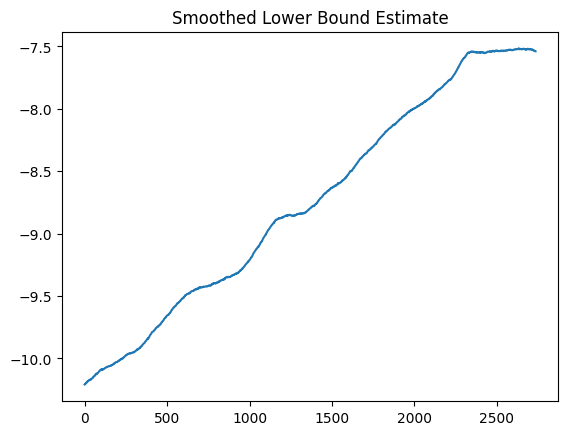

In [27]:
lb_df = pd.DataFrame(np.array(smoothed_LB_estimate))
plt.figure()
lb_df.plot(title = 'Smoothed Lower Bound Estimate', legend = False)

In [28]:
best_lambda_mu

Array([-0.01086878, -0.026341  ,  0.28004354, -0.06085999], dtype=float32)

In [29]:
best_lambda_l

Array([43.74001   , -8.429165  ,  5.63455   , -1.1976329 ,  8.25776   ,
       -1.7058038 ,  2.2061949 ,  0.89585936, -0.21738979,  0.9062819 ],      dtype=float32)

In [30]:
def posterior_mean_estimate(best_lambda_mu, best_lambda_l,key):
    best_mu = best_lambda_mu
    best_vech_l = list(best_lambda_l)
    best_l = jnp.zeros((num_coeffs, num_coeffs))
    for i in range(num_coeffs):
        best_l = best_l.at[i:num_coeffs,i].set(best_vech_l[:num_coeffs - i])
        del best_vech_l[:num_coeffs-i]
    best_Sigma_inv = best_l @ best_l.T
    best_Sigma =  my_inv(best_Sigma_inv)

    best_theta_tilde = random.multivariate_normal(subkeys[3185], mean = best_mu, cov = best_Sigma, shape = (10000,))
    best_alpha = (5 * jnp.exp(best_theta_tilde[:,0]) + 0) / (1 + jnp.exp(best_theta_tilde[:,0]))
    best_beta = (2 * jnp.exp(best_theta_tilde[:,1]) + 0) / (1 + jnp.exp(best_theta_tilde[:,1]))
    best_gamma = (3 * jnp.exp(best_theta_tilde[:,2]) + 0) / (1 + jnp.exp(best_theta_tilde[:,2]))
    best_delta = (1 * jnp.exp(best_theta_tilde[:,3]) + 0) / (1 + jnp.exp(best_theta_tilde[:,3]))

    best_theta = jnp.array([best_alpha, best_beta, best_gamma, best_delta])
    posterior_mean_estimate = jnp.mean(best_theta, axis = 1)
    return posterior_mean_estimate, best_alpha, best_beta, best_gamma, best_delta, best_Sigma_inv

In [31]:
posterior_mean_estimate_vbsl, best_alpha, best_beta, best_gamma, best_delta, best_Sigma_inv = posterior_mean_estimate(best_lambda_mu, best_lambda_l,subkeys[1773])
posterior_mean_estimate_vbsl

Array([2.4857256, 0.9872547, 1.668373 , 0.488285 ], dtype=float32)

In [ ]:
best_lambda_mu_rvbsl = jnp.array([0.01734083,  0.0537256 ,  0.04606311, -0.04144196])
best_lambda_l_rvbsl = jnp.array([9.982896  , -0.17166461, -0.10848538,  0.05607464, 10.008675  ,
        0.04844539, -0.15133595,  9.974069  , -0.13100503,  9.967676])

In [ ]:
posterior_mean_estimate_rvbsl, best_alpha_rvbsl, best_beta_rvbsl, best_gamma_rvbsl, best_delta_rvbsl, best_Sigma_inv_rvbsl = posterior_mean_estimate(best_lambda_mu_rvbsl, best_lambda_l_rvbsl, subkeys[4484])
posterior_mean_estimate_rvbsl

Array([2.5222468, 1.0261194, 1.5342304, 0.489848 ], dtype=float32)

In [ ]:
best_lambda_mu_vbsl_wg = jnp.array([0.6207752 , -0.04571293,  0.09294078, -0.09614888])
best_lambda_l_vbsl_wg = jnp.array([42.661118, -8.544755,  5.3476162, -0.81279236,
        7.5673971, -0.52509522,  1.2861819,  1.2520900,
       -0.024908312,  0.93360078])

In [ ]:
posterior_mean_estimate_vbsl_wg, best_alpha_vbsl_wg, best_beta_vbsl_wg, best_gamma_vbsl_wg, best_delta_vbsl_wg, best_Sigma_inv_vbsl_wg = posterior_mean_estimate(best_lambda_mu_vbsl_wg, best_lambda_l_vbsl_wg,subkeys[1344])
posterior_mean_estimate_vbsl_wg

Array([3.2504666, 0.9759324, 1.5589361, 0.4833069], dtype=float32)

In [ ]:
best_lambda_mu_rvbsl_wg = jnp.array([0.31293595, -0.09478645,  0.4393845 ,  0.08242832])
best_lambda_l_rvbsl_wg = jnp.array([42.653446  , -8.280344  ,  5.442265  , -1.2477309 ,  7.8570576 ,
       -1.3017905 ,  2.3272023 ,  4.4692025 , -0.37170365,  3.0453818 ])

In [ ]:
posterior_mean_estimate_rvbsl_wg, best_alpha_rvbsl_wg, best_beta_rvbsl_wg, best_gamma_rvbsl_wg, best_delta_rvbsl_wg, best_Sigma_inv_rvbsl_wg = posterior_mean_estimate(best_lambda_mu_rvbsl_wg, best_lambda_l_rvbsl_wg, subkeys[3871])
posterior_mean_estimate_rvbsl_wg

Array([2.8875823 , 0.95266306, 1.8209083 , 0.5201327 ], dtype=float32)

In [ ]:
alpha_set = [best_alpha, best_alpha_rvbsl, best_alpha_vbsl_wg, best_alpha_rvbsl_wg]
beta_set = [best_beta, best_beta_rvbsl, best_beta_vbsl_wg, best_beta_rvbsl_wg]
gamma_set = [best_gamma, best_gamma_rvbsl, best_gamma_vbsl_wg, best_gamma_rvbsl_wg]
delta_set = [best_delta, best_delta_rvbsl, best_delta_vbsl_wg, best_delta_rvbsl_wg]

In [ ]:
from sklearn.neighbors import KernelDensity

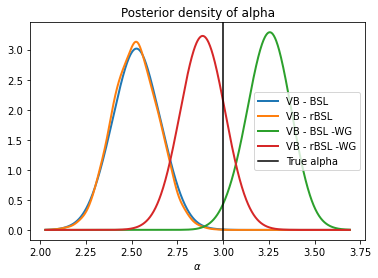

In [ ]:
plt.figure()
x_plot = np.arange(min(np.mean(alpha_set[0])-4*np.std(alpha_set[0]),np.mean(alpha_set[2])-4*np.std(alpha_set[2])), max(np.mean(alpha_set[0])+4*np.std(alpha_set[0]), np.mean(alpha_set[2])+4*np.std(alpha_set[2])), 0.002)

kde_vbsl = KernelDensity(bandwidth=0.0475, kernel='gaussian')
kde_vbsl.fit(alpha_set[0].reshape(-1, 1))
y_plot_vbsl = kde_vbsl.score_samples(x_plot.reshape(-1, 1))

kde_rvbsl = KernelDensity(bandwidth=0.025, kernel='gaussian')
kde_rvbsl.fit(alpha_set[1].reshape(-1, 1))
y_plot_rvbsl = kde_rvbsl.score_samples(x_plot.reshape(-1, 1))

kde_vbsl_wg = KernelDensity(bandwidth=0.05, kernel='gaussian')
kde_vbsl_wg.fit(alpha_set[2].reshape(-1, 1))
y_plot_vbsl_wg = kde_vbsl_wg.score_samples(x_plot.reshape(-1, 1))

kde_rvbsl_wg = KernelDensity(bandwidth=0.1125, kernel='gaussian')
kde_rvbsl_wg.fit(alpha_set[3].reshape(-1, 1))
y_plot_rvbsl_wg = kde_rvbsl_wg.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_vbsl), '-', linewidth=2.0, label = 'VB - BSL')
plt.plot(x_plot, np.exp(y_plot_rvbsl), '-', linewidth=2.0, label = 'VB - rBSL')
plt.plot(x_plot, np.exp(y_plot_vbsl_wg), '-', linewidth=2.0, label = 'VB - BSL -WG')
plt.plot(x_plot, np.exp(y_plot_rvbsl_wg), '-', linewidth=2.0, label = 'VB - rBSL -WG')
# only one line may be specified; full height
plt.axvline(x = 3, ymin = 0, color = 'black', label = 'True alpha')

plt.legend()
plt.xlabel(r'$\alpha$')
plt.title('Posterior density of alpha')
plt.savefig('gnk_alpha.png')


Text(0.5, 1.0, 'Posterior density of beta')

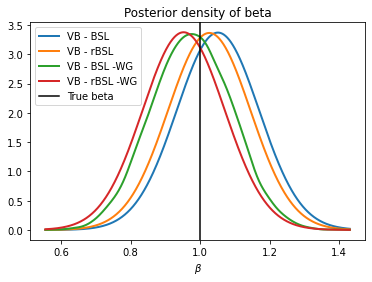

In [ ]:
plt.figure()
x_plot = np.arange(min(np.mean(beta_set[0])-5*np.std(beta_set[0]),np.mean(beta_set[3])-5*np.std(beta_set[3])), max(np.mean(beta_set[0])+6*np.std(beta_set[0]), np.mean(beta_set[3])+6*np.std(beta_set[3])), 0.001)

kde_vbsl = KernelDensity(bandwidth=0.1075, kernel='gaussian')
kde_vbsl.fit(beta_set[0].reshape(-1, 1))
y_plot_vbsl = kde_vbsl.score_samples(x_plot.reshape(-1, 1))

kde_rvbsl = KernelDensity(bandwidth=0.1075, kernel='gaussian')
kde_rvbsl.fit(beta_set[1].reshape(-1, 1))
y_plot_rvbsl = kde_rvbsl.score_samples(x_plot.reshape(-1, 1))

kde_vbsl_wg = KernelDensity(bandwidth=0.02, kernel='gaussian')
kde_vbsl_wg.fit(beta_set[2].reshape(-1, 1))
y_plot_vbsl_wg = kde_vbsl_wg.score_samples(x_plot.reshape(-1, 1))

kde_rvbsl_wg = KernelDensity(bandwidth=0.0875, kernel='gaussian')
kde_rvbsl_wg.fit(beta_set[3].reshape(-1, 1))
y_plot_rvbsl_wg = kde_rvbsl_wg.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_vbsl), '-', linewidth=2.0, label = 'VB - BSL')
plt.plot(x_plot, np.exp(y_plot_rvbsl), '-', linewidth=2.0, label = 'VB - rBSL')
plt.plot(x_plot, np.exp(y_plot_vbsl_wg), '-', linewidth=2.0, label = 'VB - BSL -WG')
plt.plot(x_plot, np.exp(y_plot_rvbsl_wg), '-', linewidth=2.0, label = 'VB - rBSL -WG')
# only one line may be specified; full height
plt.axvline(x = 1, ymin = 0, color = 'black', label = 'True beta')

plt.legend()
plt.xlabel(r'$\beta$')
plt.title('Posterior density of beta')


Text(0.5, 1.0, 'Posterior density of gamma')

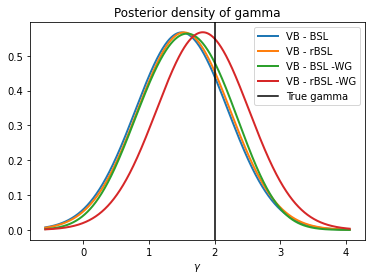

In [ ]:
plt.figure()
x_plot = np.arange(min(np.mean(gamma_set[0])-15*np.std(gamma_set[0]),np.mean(gamma_set[3])-15*np.std(gamma_set[3])), max(np.mean(gamma_set[0])+14*np.std(gamma_set[0]), np.mean(gamma_set[3])+14*np.std(gamma_set[3])), 0.002)

kde_vbsl = KernelDensity(bandwidth=0.7, kernel='gaussian')
kde_vbsl.fit(gamma_set[0].reshape(-1, 1))
y_plot_vbsl = kde_vbsl.score_samples(x_plot.reshape(-1, 1))

kde_rvbsl = KernelDensity(bandwidth=0.7, kernel='gaussian')
kde_rvbsl.fit(gamma_set[1].reshape(-1, 1))
y_plot_rvbsl = kde_rvbsl.score_samples(x_plot.reshape(-1, 1))

kde_vbsl_wg = KernelDensity(bandwidth=0.425, kernel='gaussian')
kde_vbsl_wg.fit(gamma_set[2].reshape(-1, 1))
y_plot_vbsl_wg = kde_vbsl_wg.score_samples(x_plot.reshape(-1, 1))

kde_rvbsl_wg = KernelDensity(bandwidth=0.685, kernel='gaussian')
kde_rvbsl_wg.fit(gamma_set[3].reshape(-1, 1))
y_plot_rvbsl_wg = kde_rvbsl_wg.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_vbsl), '-', linewidth=2.0, label = 'VB - BSL')
plt.plot(x_plot, np.exp(y_plot_rvbsl), '-', linewidth=2.0, label = 'VB - rBSL')
plt.plot(x_plot, np.exp(y_plot_vbsl_wg), '-', linewidth=2.0, label = 'VB - BSL -WG')
plt.plot(x_plot, np.exp(y_plot_rvbsl_wg), '-', linewidth=2.0, label = 'VB - rBSL -WG')

# only one line may be specified; full height
plt.axvline(x = 2, ymin = 0, color = 'black', label = 'True gamma')

plt.legend()
plt.xlabel(r'$\gamma$')
plt.title('Posterior density of gamma')


Text(0.5, 1.0, 'Posterior density of delta')

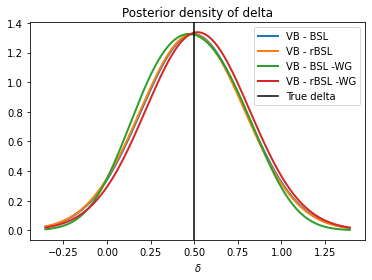

In [ ]:
plt.figure()
x_plot = np.arange(min(np.mean(delta_set[0])-11*np.std(delta_set[0]),np.mean(delta_set[3])-11*np.std(delta_set[3])), max(np.mean(delta_set[0])+11*np.std(delta_set[0]), np.mean(delta_set[3])+11*np.std(delta_set[3])), 0.001)

kde_vbsl = KernelDensity(bandwidth=0.3, kernel='gaussian')
kde_vbsl.fit(delta_set[0].reshape(-1, 1))
y_plot_vbsl = kde_vbsl.score_samples(x_plot.reshape(-1, 1))

kde_rvbsl = KernelDensity(bandwidth=0.3, kernel='gaussian')
kde_rvbsl.fit(delta_set[1].reshape(-1, 1))
y_plot_rvbsl = kde_rvbsl.score_samples(x_plot.reshape(-1, 1))

kde_vbsl_wg = KernelDensity(bandwidth=0.175, kernel='gaussian')
kde_vbsl_wg.fit(delta_set[2].reshape(-1, 1))
y_plot_vbsl_wg = kde_vbsl_wg.score_samples(x_plot.reshape(-1, 1))

kde_rvbsl_wg = KernelDensity(bandwidth=0.2875, kernel='gaussian')
kde_rvbsl_wg.fit(delta_set[3].reshape(-1, 1))
y_plot_rvbsl_wg = kde_rvbsl_wg.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_vbsl), '-', linewidth=2.0, label = 'VB - BSL')
plt.plot(x_plot, np.exp(y_plot_rvbsl), '-', linewidth=2.0, label = 'VB - rBSL')
plt.plot(x_plot, np.exp(y_plot_vbsl_wg), '-', linewidth=2.0, label = 'VB - BSL -WG')
plt.plot(x_plot, np.exp(y_plot_rvbsl_wg), '-', linewidth=2.0, label = 'VB - rBSL -WG')

# only one line may be specified; full height
plt.axvline(x = 0.5, ymin = 0, color = 'black', label = 'True delta')

plt.legend()
plt.xlabel(r'$\delta$')
plt.title('Posterior density of delta')
